# Сегментация

 Научимся решать задачу сегментации объектов на изображении.

![](1.png)

## Задача семантической сегментации

![](2.png)

### Постановка задачи

 - Данные: изображение и его золотой стандарт сегментации
 - Пример датасетов: PASCAL VOC 2007 и 2012, CITYSCAPES, OXFORDIIITPET

![](3.jpeg)
![](4.png)

### Метрики качества

 - Попиксельная доля верных ответов:
$$\text{Accuracy}(y, a) = \dfrac{1}{n}\sum\limits_{i=1}^{n}[y_i = a_i]$$
 - Мера Жаккара:
$$J_k(y, a) = \dfrac{\sum\limits_{i=1}^{n}[y_i = k][a_i = k]}{\sum\limits_{i=1}^{n}\max([y_i = k], [a_i = k])}$$

![](5.png)

### Функция потерь

Функция потерь абсолютно такая же как и для классификации, только мы классифицируем каждый пиксель и соответственно суммируем ошибку по всем пикселям.

## Архитектуры нейронных сетей для семантической сегментации

### Fully convolutional network

https://arxiv.org/abs/1411.4038

![](6.png)

 - Берем AlexNet
 - Только сверточные слои оставляем
 - Тензор с последнего слоя преобразуем с помощью сверток 1х1 в тензор такого же размера, только с нужным числом каналов (K по числу классов)
 - Повышаем разрешение

![](7.png)

#### Минусы?

 - Тензор на последнем слое маленький
 - Теряется информация о том, где объект, есть только информация, что он там был
 - Объекты похожи на пятна

### U-Net

https://arxiv.org/abs/1505.04597

![](8.png)

## Практика!

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet

dataset = OxfordIIITPet('seminar_4/data', target_types='segmentation', download=True)

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=394x500>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=394x500>)

In [ ]:
x = torch.zeros(2, 1, 2, 1, 2)
display(x)
torch.Size([2, 1, 2, 1, 2])
y = torch.squeeze(x)
display( y)
torch.Size([2, 2, 2])
y = torch.squeeze(x, 0)
y.size()
torch.Size([2, 1, 2, 1, 2])
y = torch.squeeze(x, 1)
y.size()
torch.Size([2, 2, 1, 2])
y = torch.squeeze(x, (1, 2, 3))

tensor([[[[[0., 0.]],

          [[0., 0.]]]],



        [[[[0., 0.]],

          [[0., 0.]]]]])

tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])

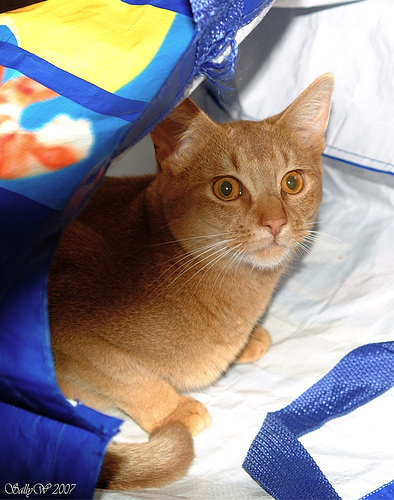

In [ ]:
dataset[0][0]

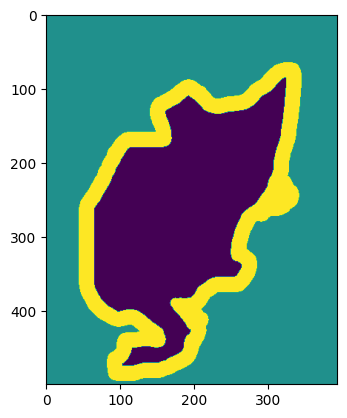

In [ ]:
plt.imshow(dataset[0][1])

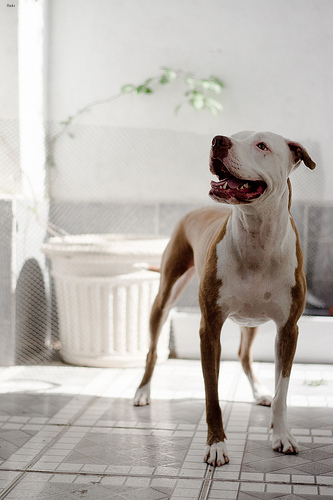

In [ ]:
dataset[100][0]

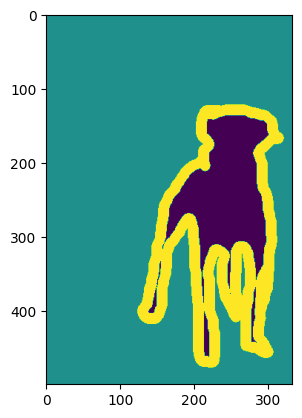

In [ ]:
plt.imshow(dataset[100][1])

In [ ]:
transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.ToTensor(),
    ]
)

target_transform = T.Compose(
    [
        T.Resize((128, 128)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('seminar_4/data', transform=transform, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('seminar_4/data', transform=transform, split='test', target_transform=target_transform, target_types='segmentation')

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=8, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_dataset[0][0].shape, train_dataset[0][1].shape

(torch.Size([3, 128, 128]), torch.Size([1, 128, 128]))

In [ ]:
torch.unique(train_dataset[0][1])

tensor([0, 1, 2])

In [ ]:
from tqdm import tqdm
!pip install torchmetrics

import torchmetrics

def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=3, ignore_index=2).to(device)

    for x, y in tqdm(train_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()
        iou_metric.update(output, y)

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy, iou_metric.compute().item()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 96.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0
    iou_metric = torchmetrics.JaccardIndex(task='multiclass', num_classes=3, ignore_index=2).to(device)

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()
        iou_metric.update(output, y)

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy, iou_metric.compute().item()

In [ ]:
from IPython.display import clear_output


def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
import numpy as np
from PIL import Image


@torch.inference_mode()
def visualize(model, batch):
    model.eval()

    xs, ys = batch

    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):
        prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(24, 8), facecolor='white')

        ax[0].imshow(to_pil(x))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= 9:
            break

In [ ]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_iou_history, valid_iou_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_iou = train(model)
        valid_loss, valid_accuracy, valid_iou = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_iou_history.append(train_iou)
        valid_iou_history.append(valid_iou)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_iou_history, valid_iou_history,
            title
        )

        visualize(model, next(iter(valid_loader)))

In [ ]:
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    """
    Makes UNet block
    :param in_channels: input channels
    :param out_channels: output channels
    :return: UNet block
    """
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)

        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)

        self.bottleneck = conv_plus_conv(base_channels * 2, base_channels * 2)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)

        # LATENT SPACE DIMENSION DIM = N // 4
        # SOME MANIPULATION MAYBE
        x = self.bottleneck(x)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)
        # SOME MANIPULATION MAYBE
        # LATENT SPACE DIMENSION DIM = N // 4

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x).squeeze()  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
# print(torch.cuda.get_device_name())

loss_fn = nn.CrossEntropyLoss()

cuda:0


In [ ]:
from torch.optim import Adam
from tqdm.notebook import tqdm

model = UNET().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
!pip install -q torchinfo
from torchinfo import summary

summary(model,
        input_size=(64, 3, 128, 128), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
UNET (UNET)                              [64, 3, 128, 128]    [64, 3, 128, 128]    --                   True
├─Sequential (down1)                     [64, 3, 128, 128]    [64, 16, 128, 128]   --                   True
│    └─Conv2d (0)                        [64, 3, 128, 128]    [64, 16, 128, 128]   448                  True
│    └─BatchNorm2d (1)                   [64, 16, 128, 128]   [64, 16, 128, 128]   32                   True
│    └─LeakyReLU (2)                     [64, 16, 128, 128]   [64, 16, 128, 128]   --                   --
│    └─Conv2d (3)                        [64, 16, 128, 128]   [64, 16, 128, 128]   2,320                True
│    └─BatchNorm2d (4)                   [64, 16, 128, 128]   [64, 16, 128, 128]   32                   True
│    └─LeakyReLU (5)                     [64, 16, 128, 128]   [64, 16, 128, 128]   --                   --
├─MaxPool2d (downs

In [ ]:
plt.rcParams.update({'font.size': 16})

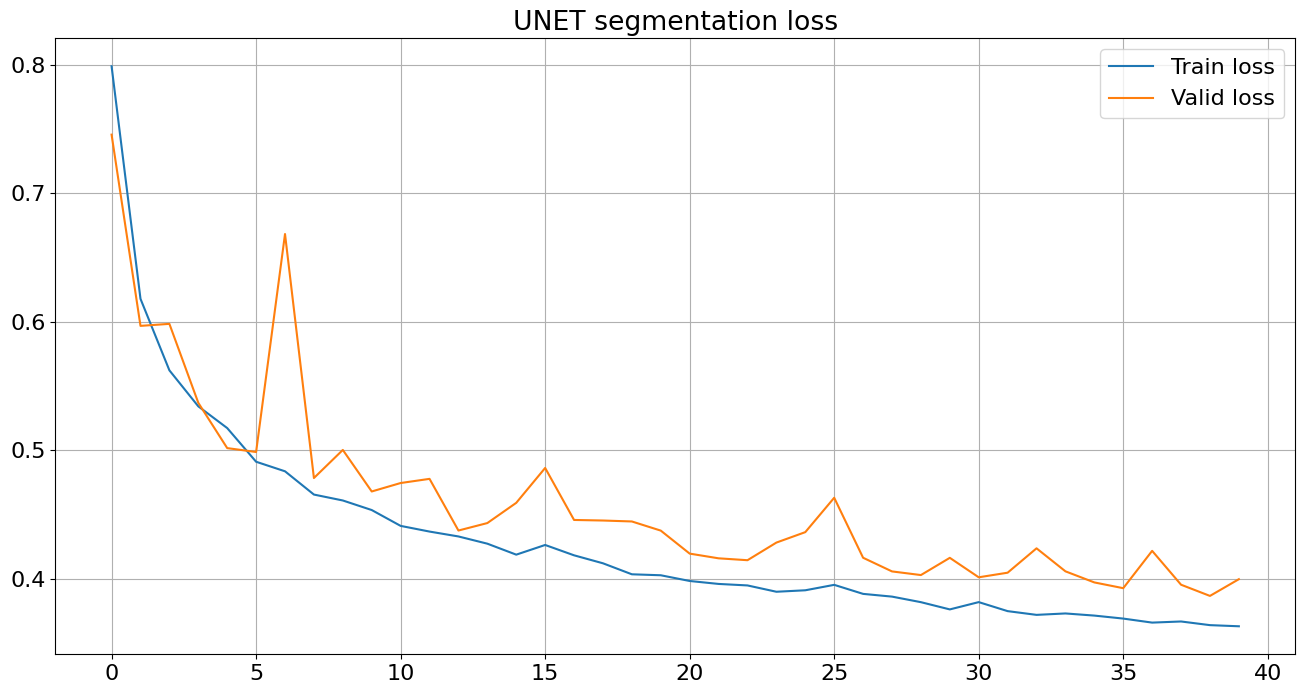

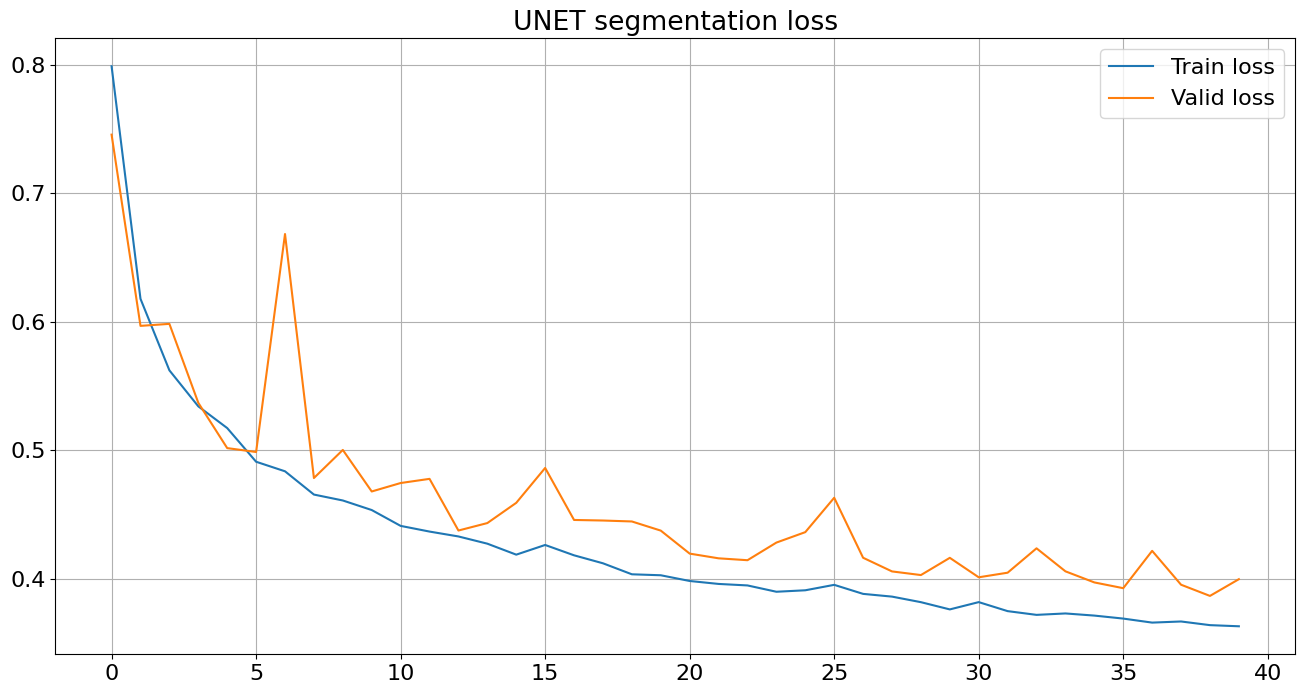

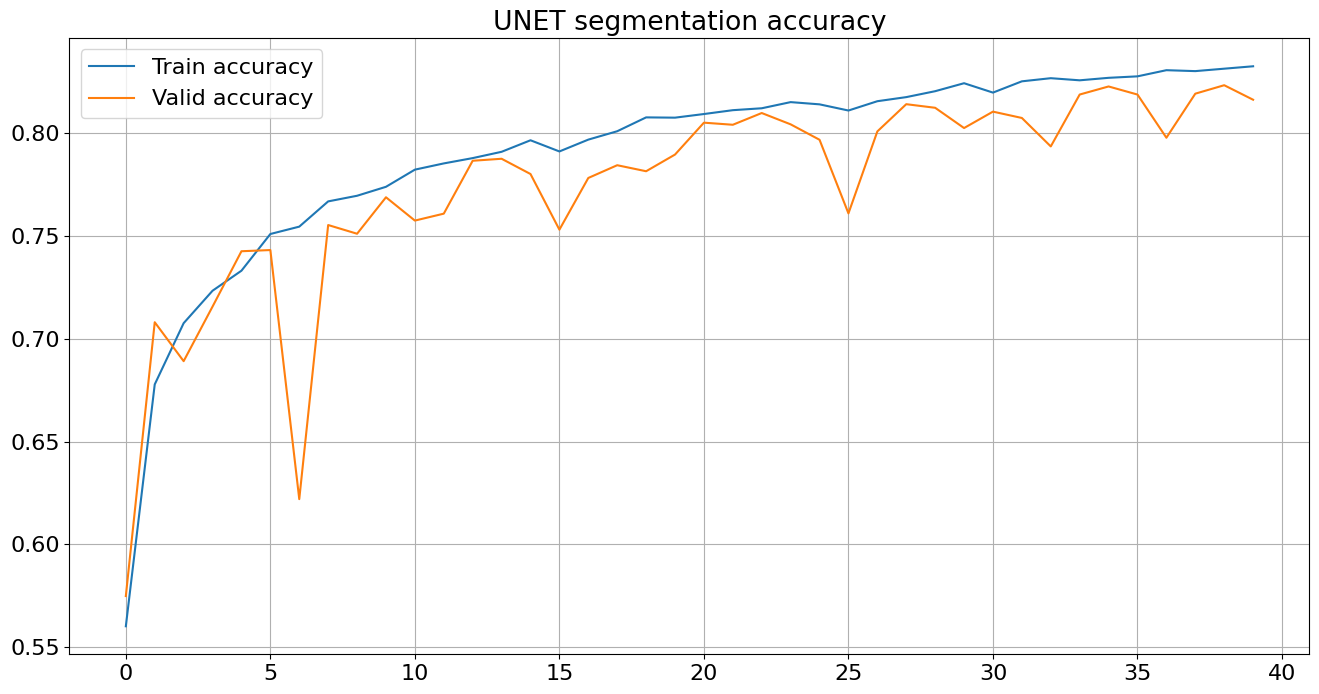

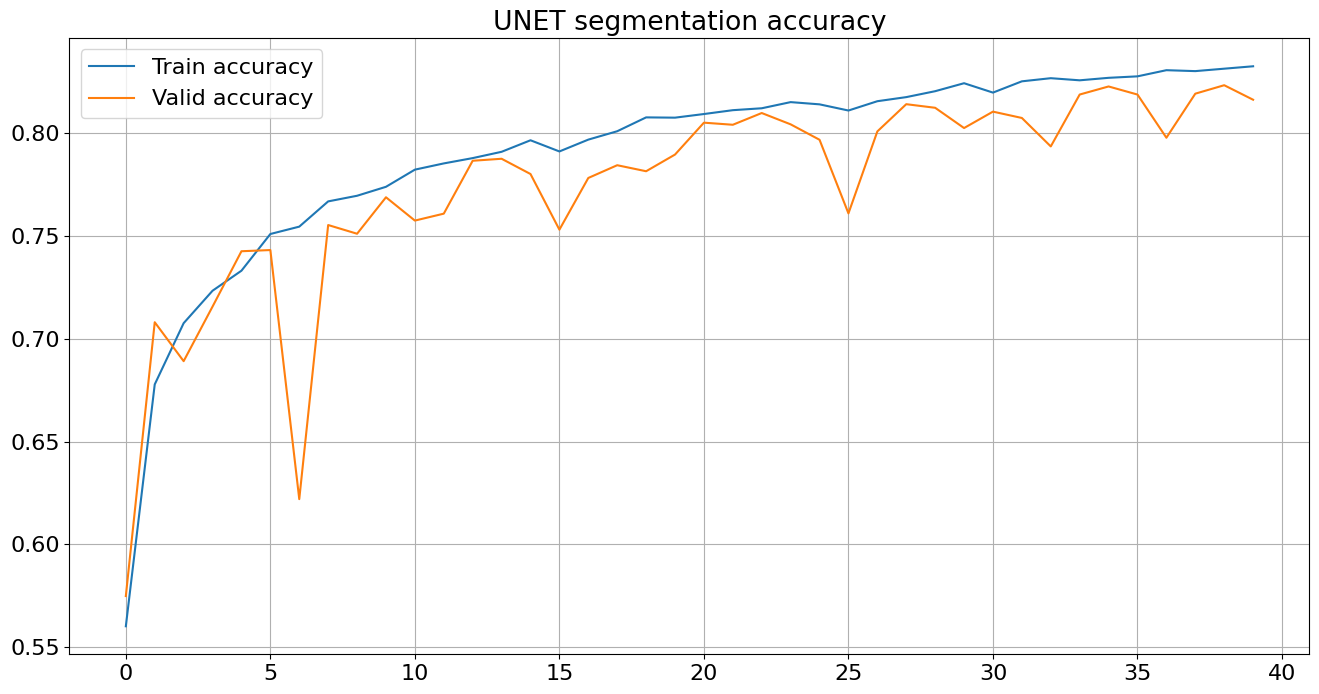

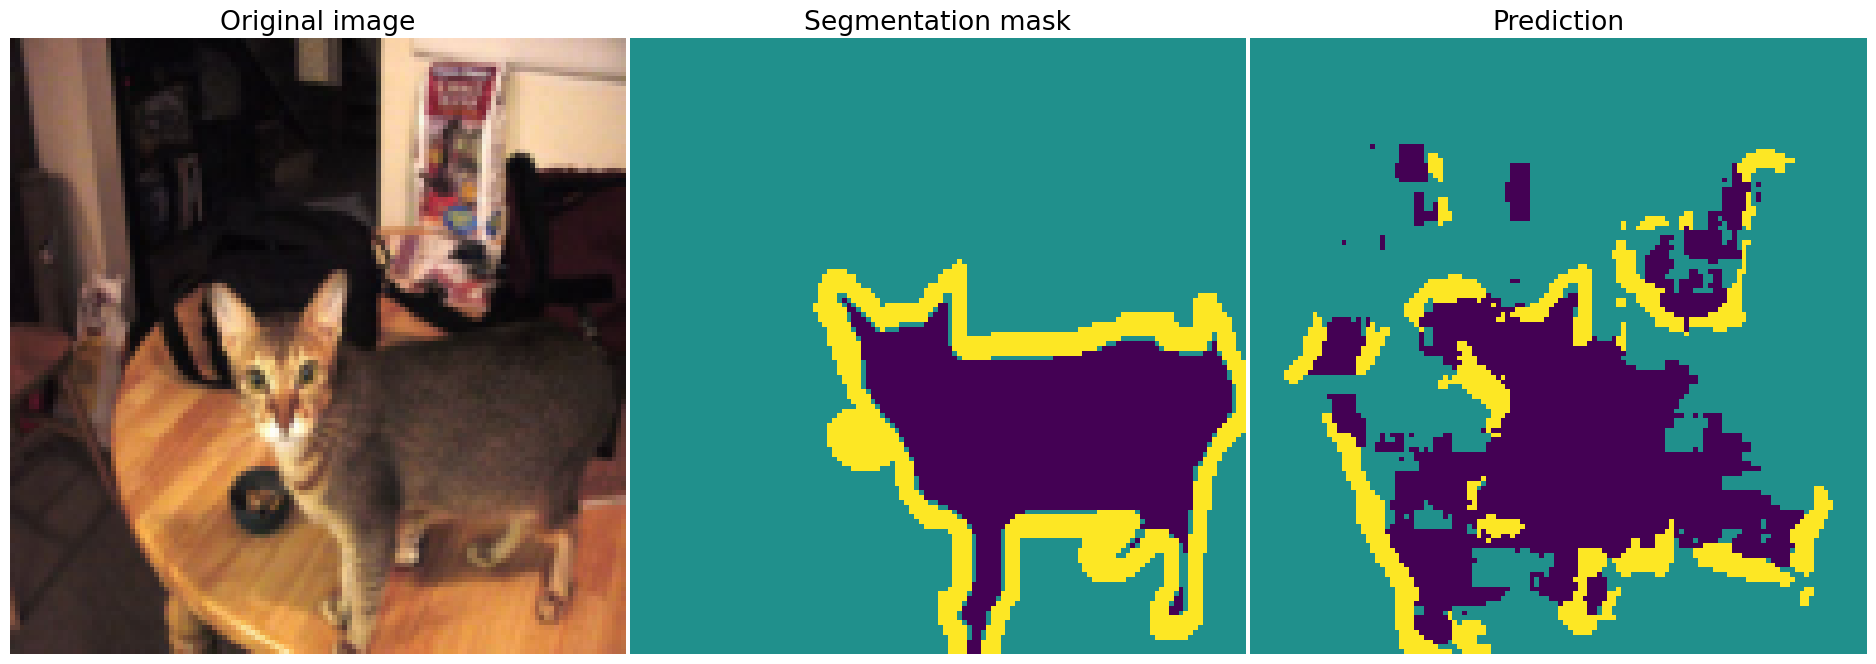

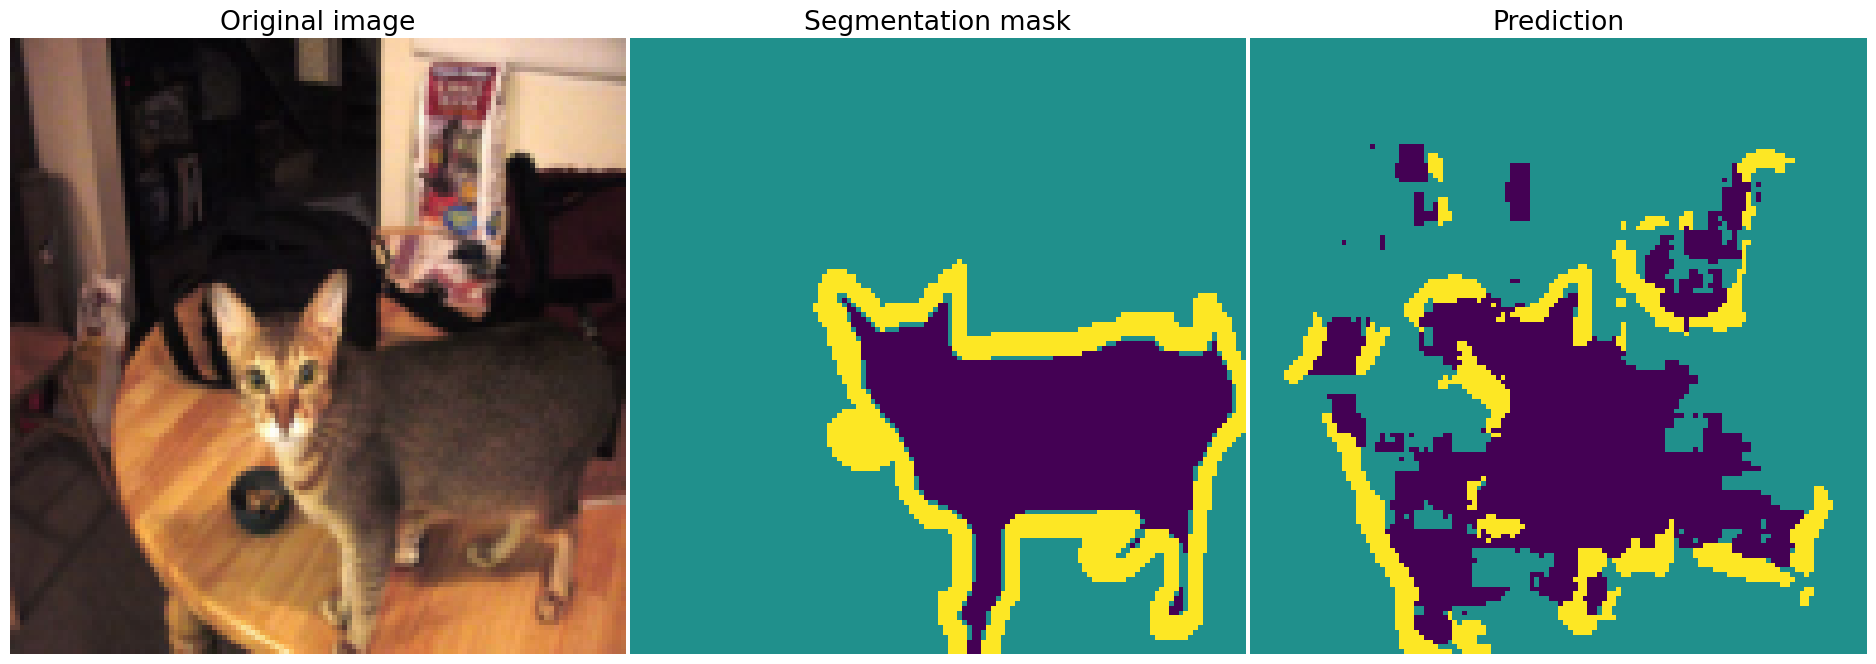

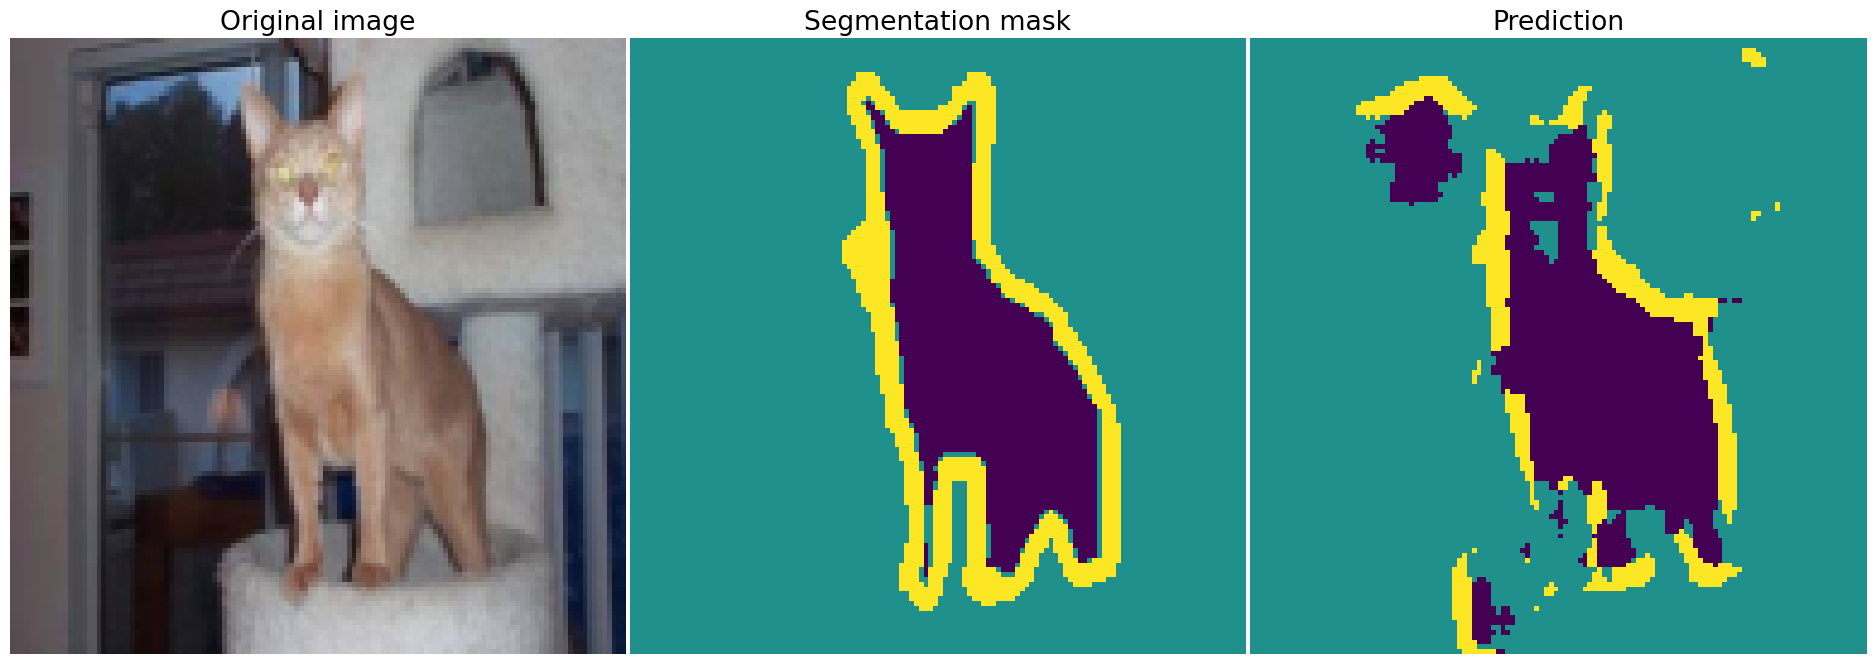

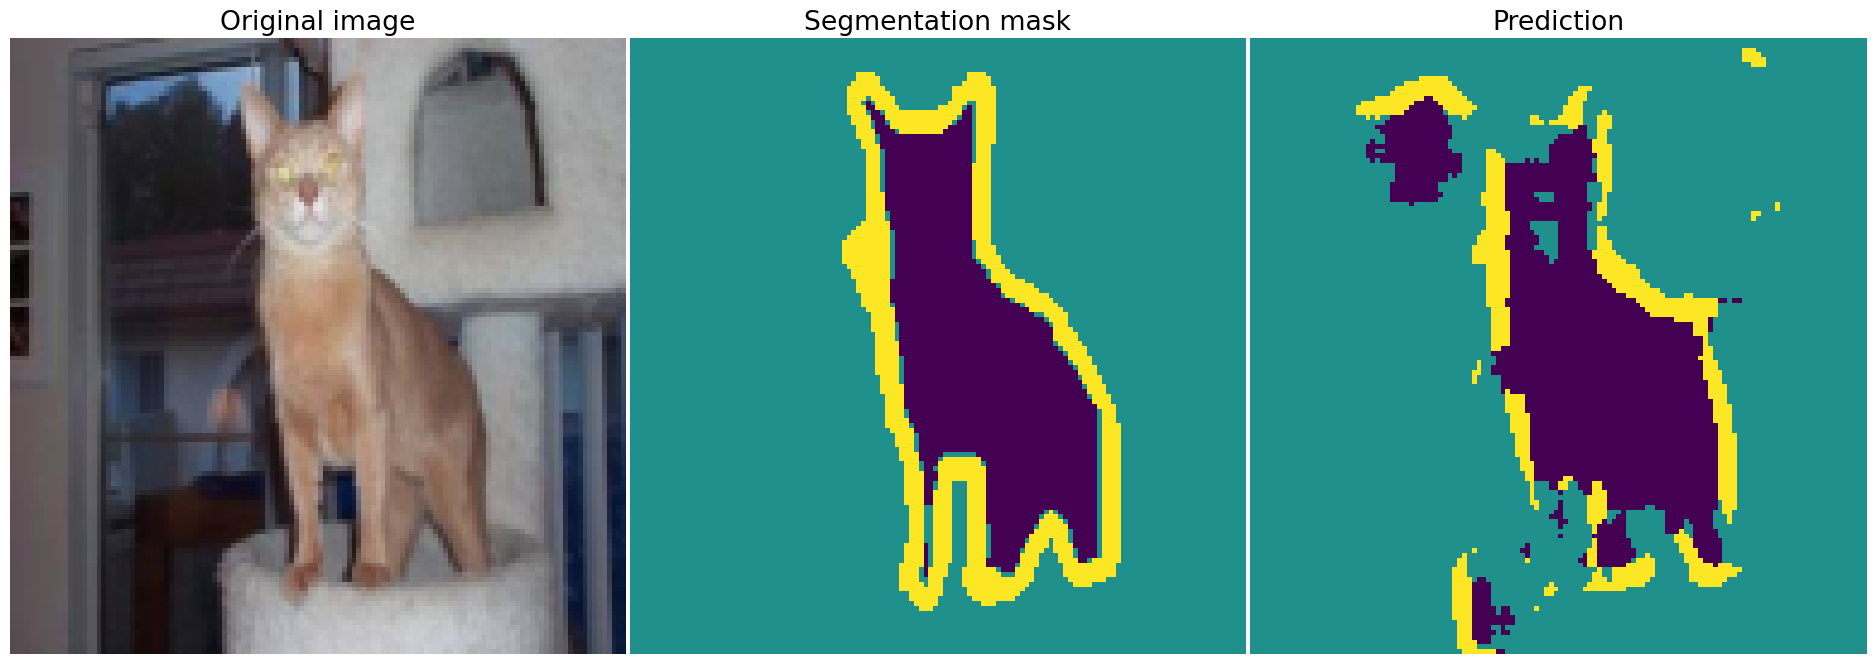

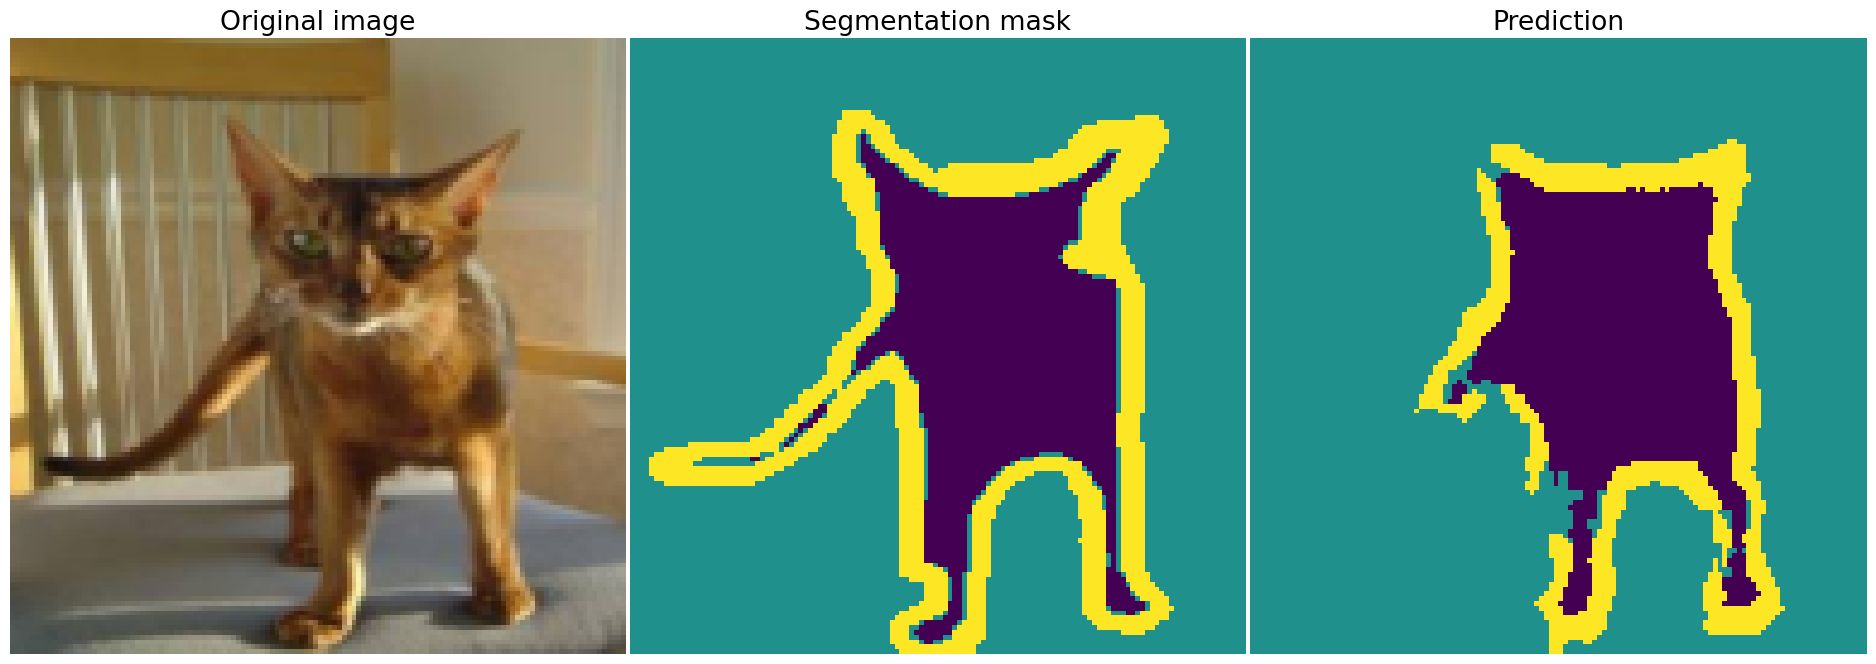

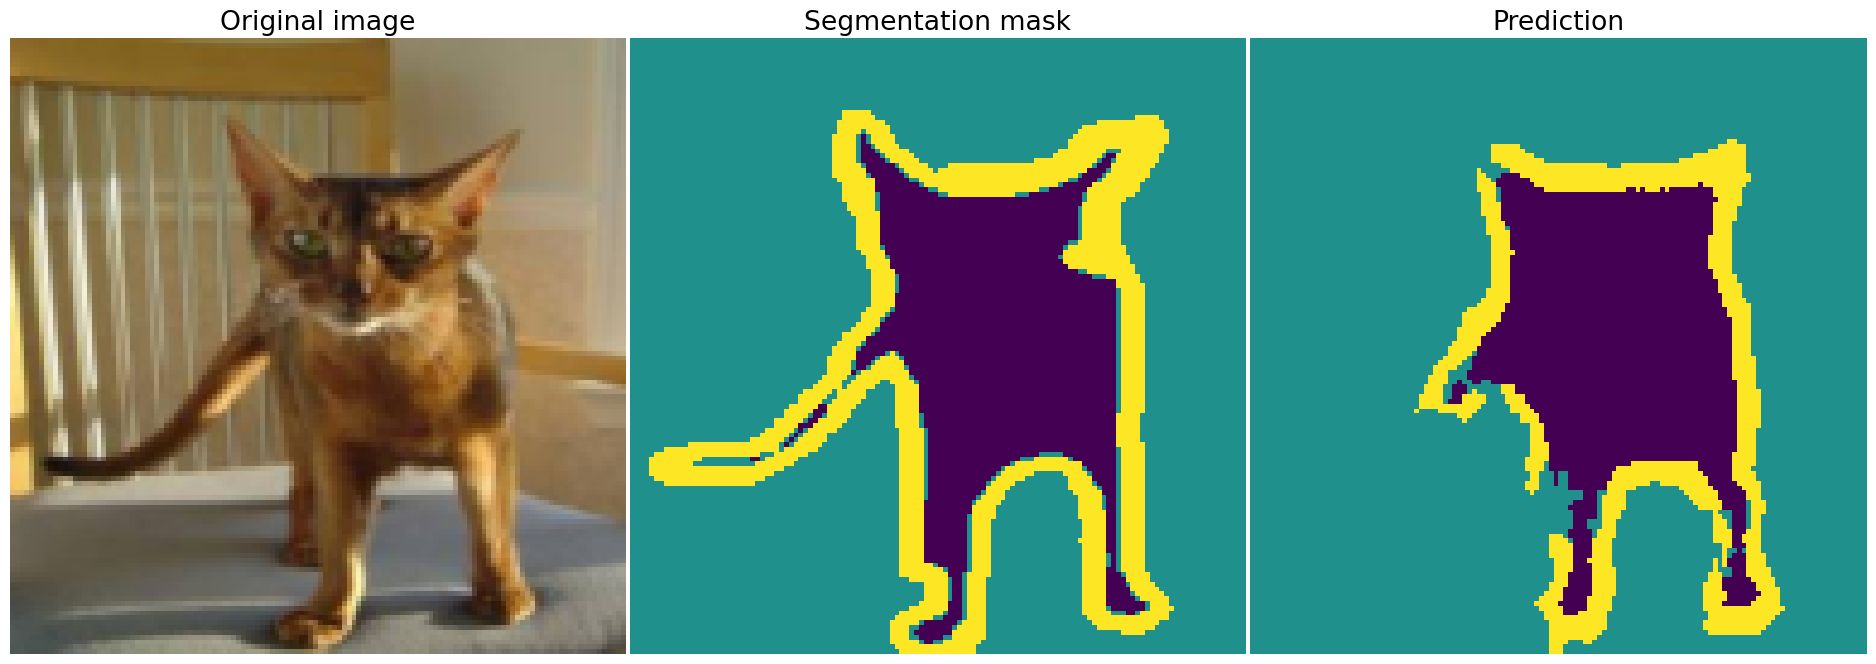

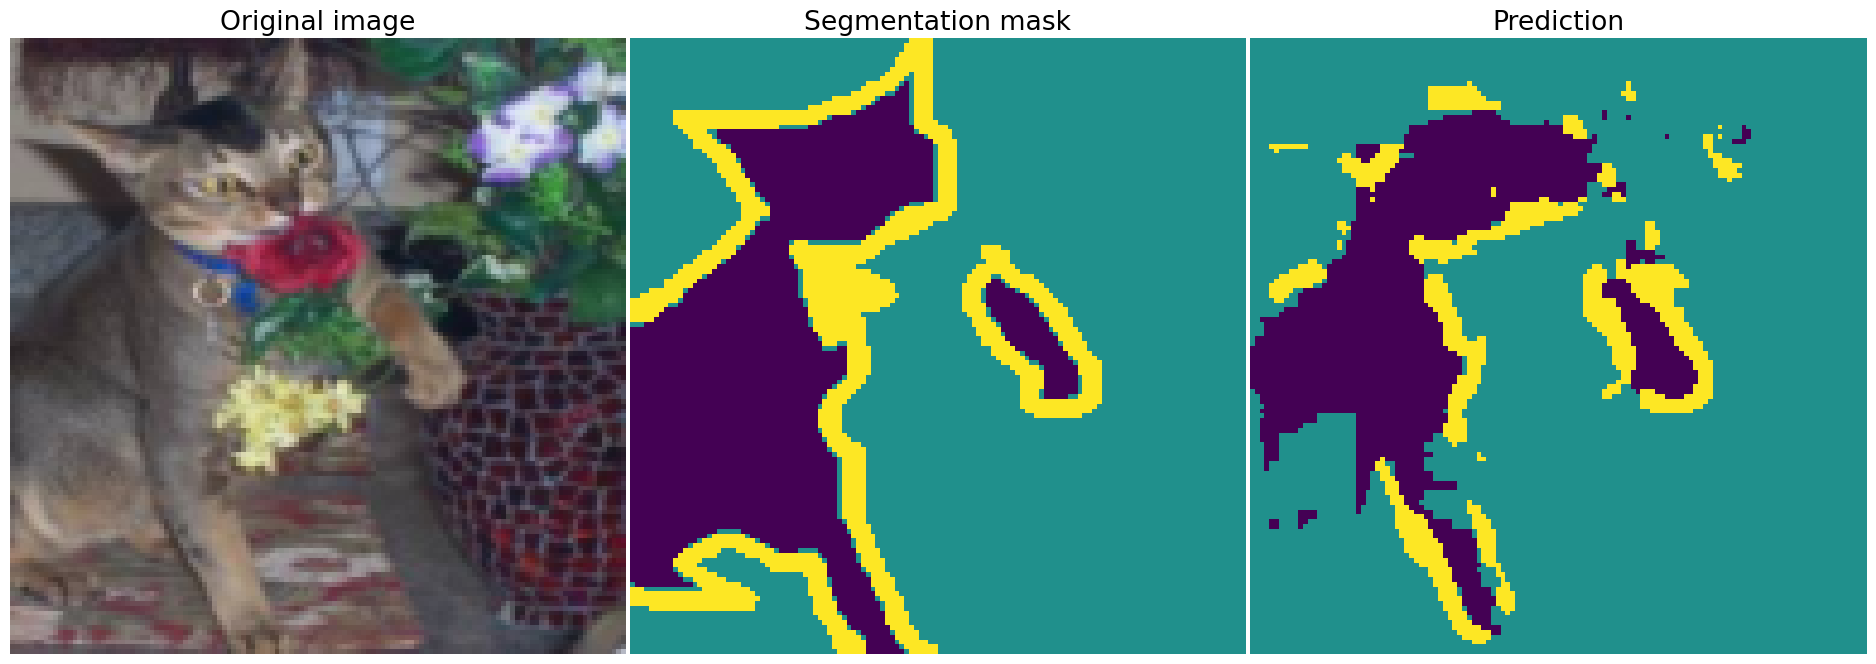

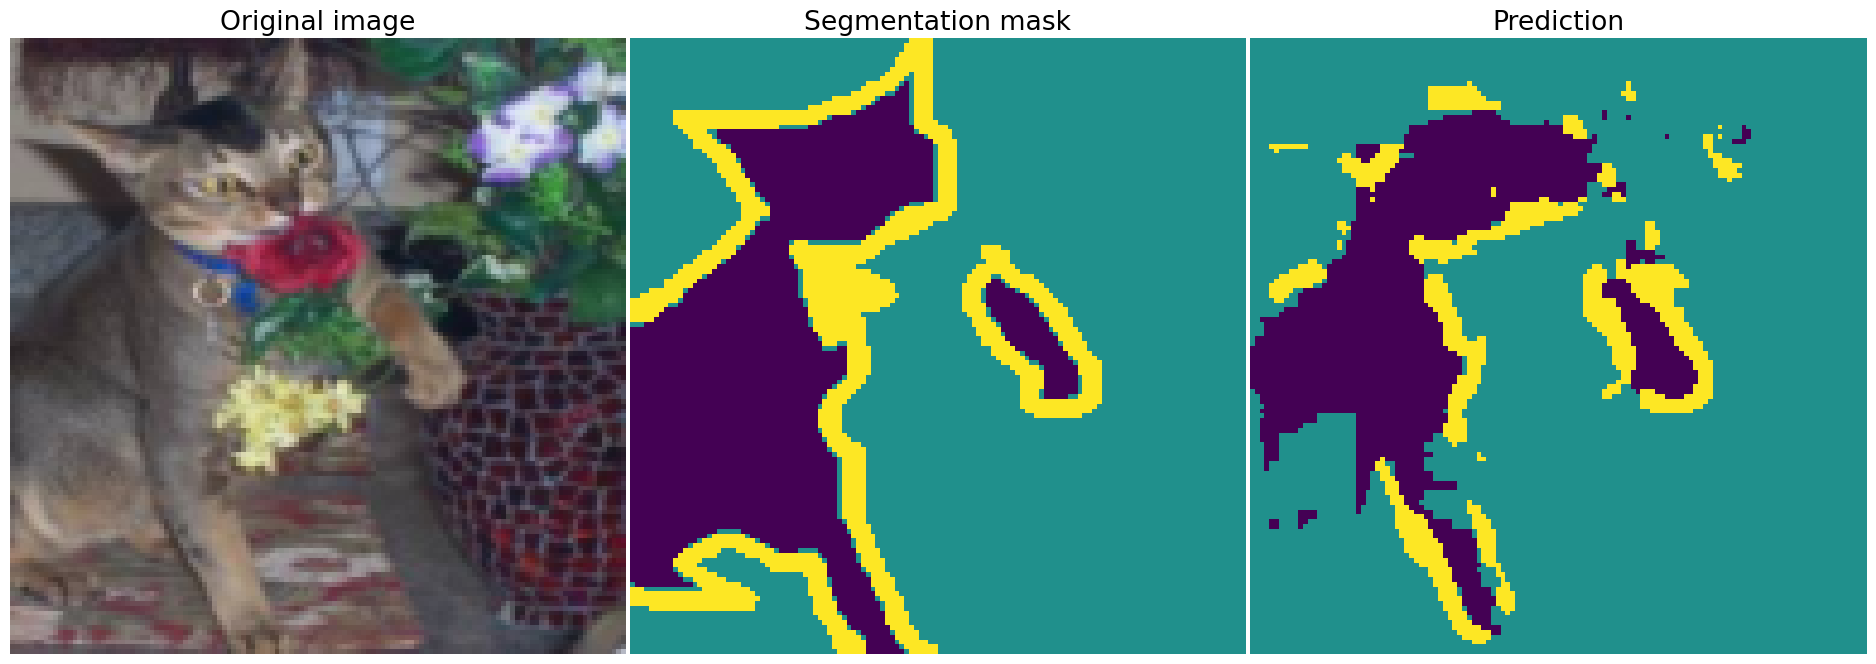

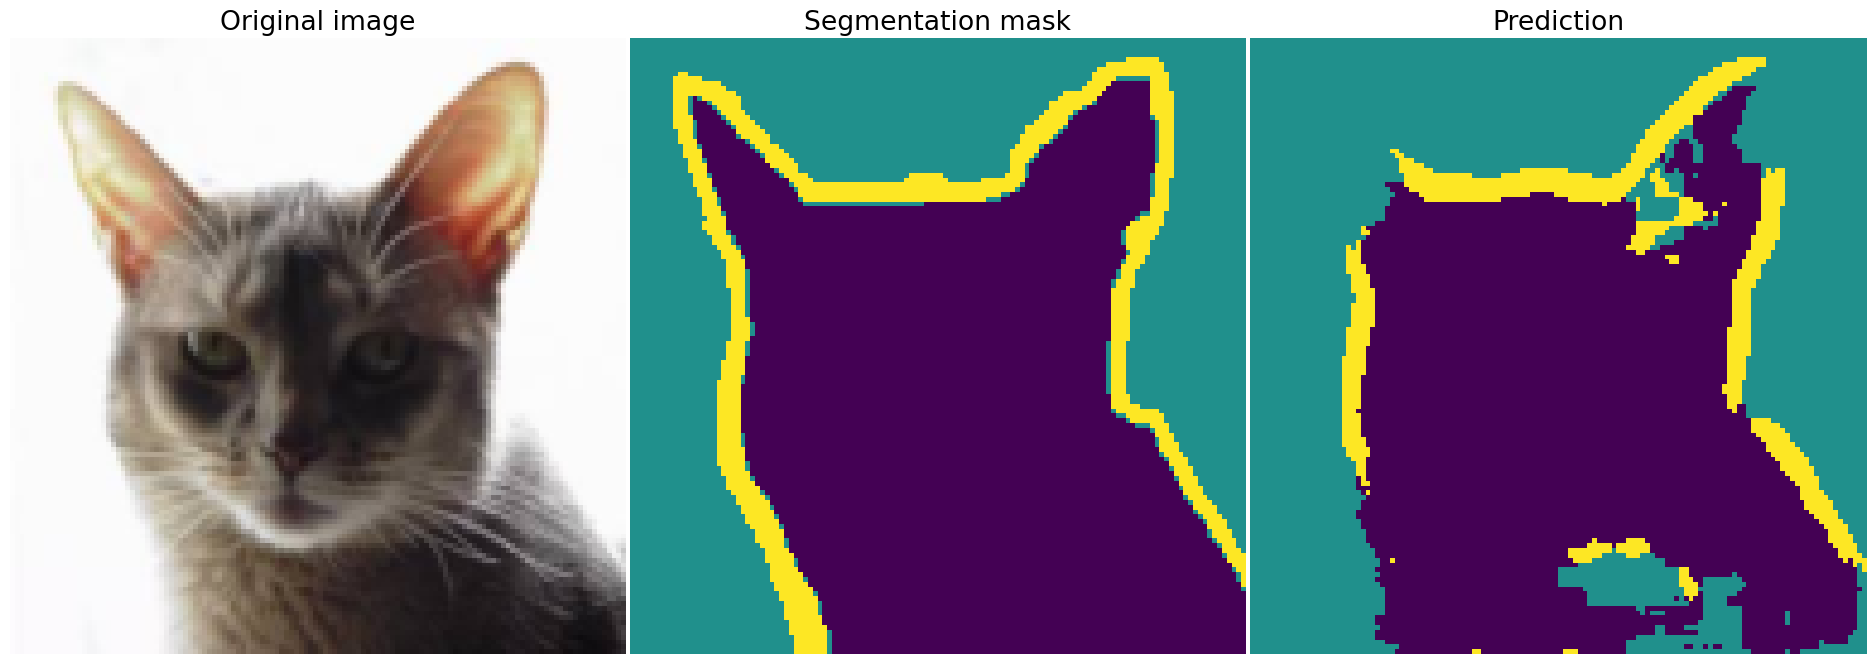

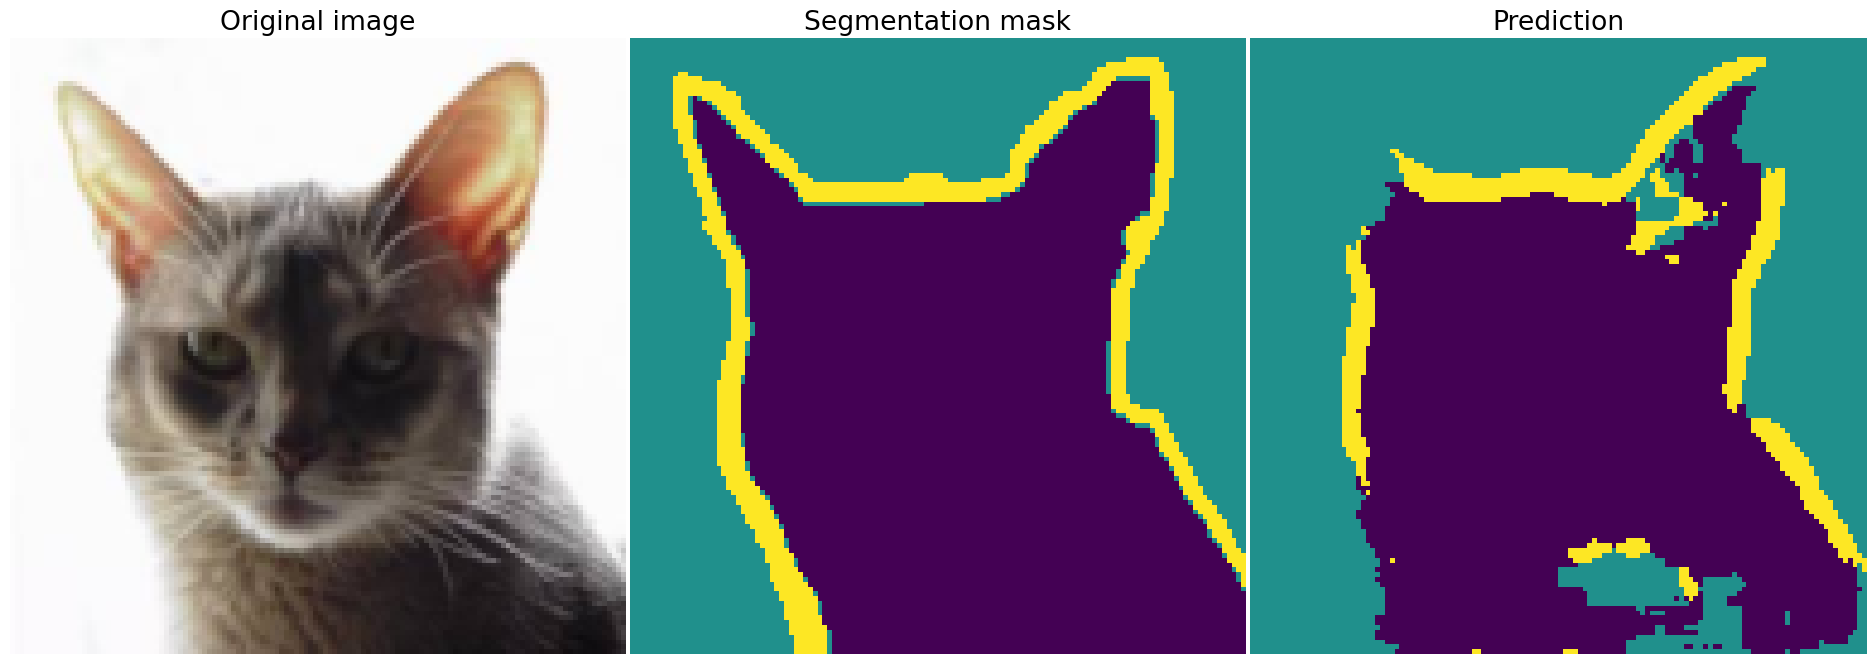

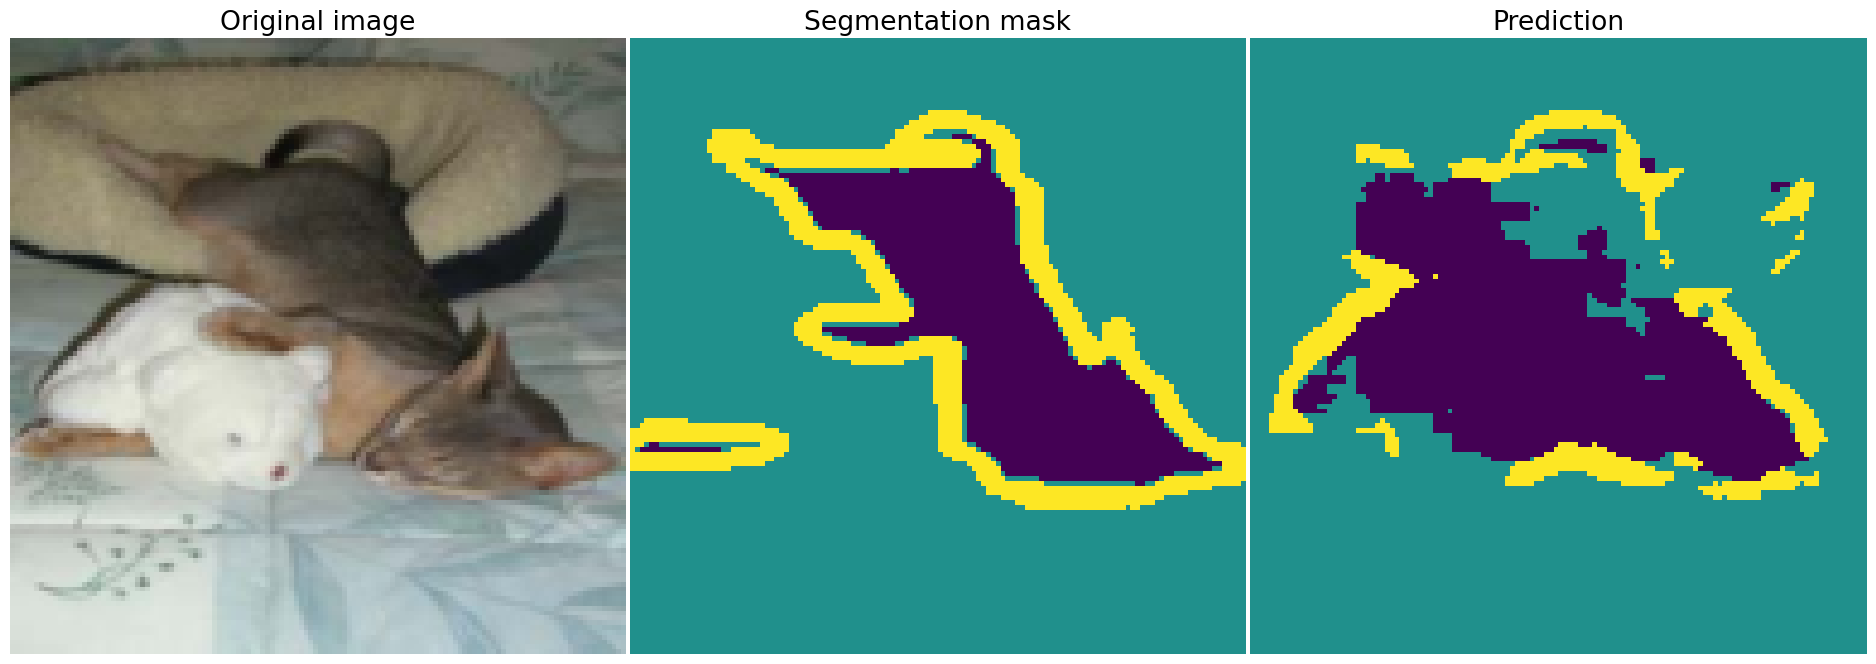

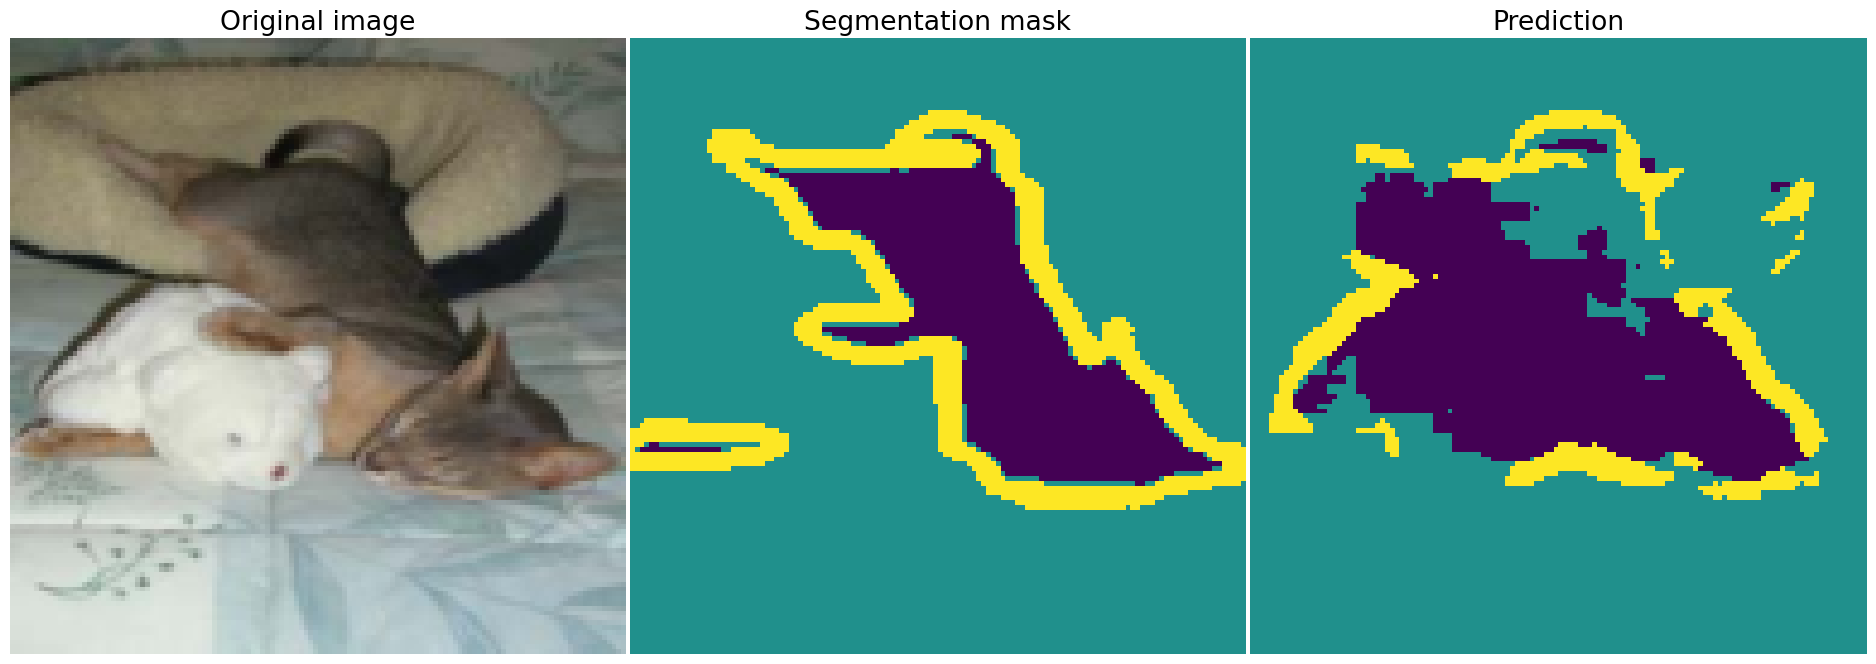

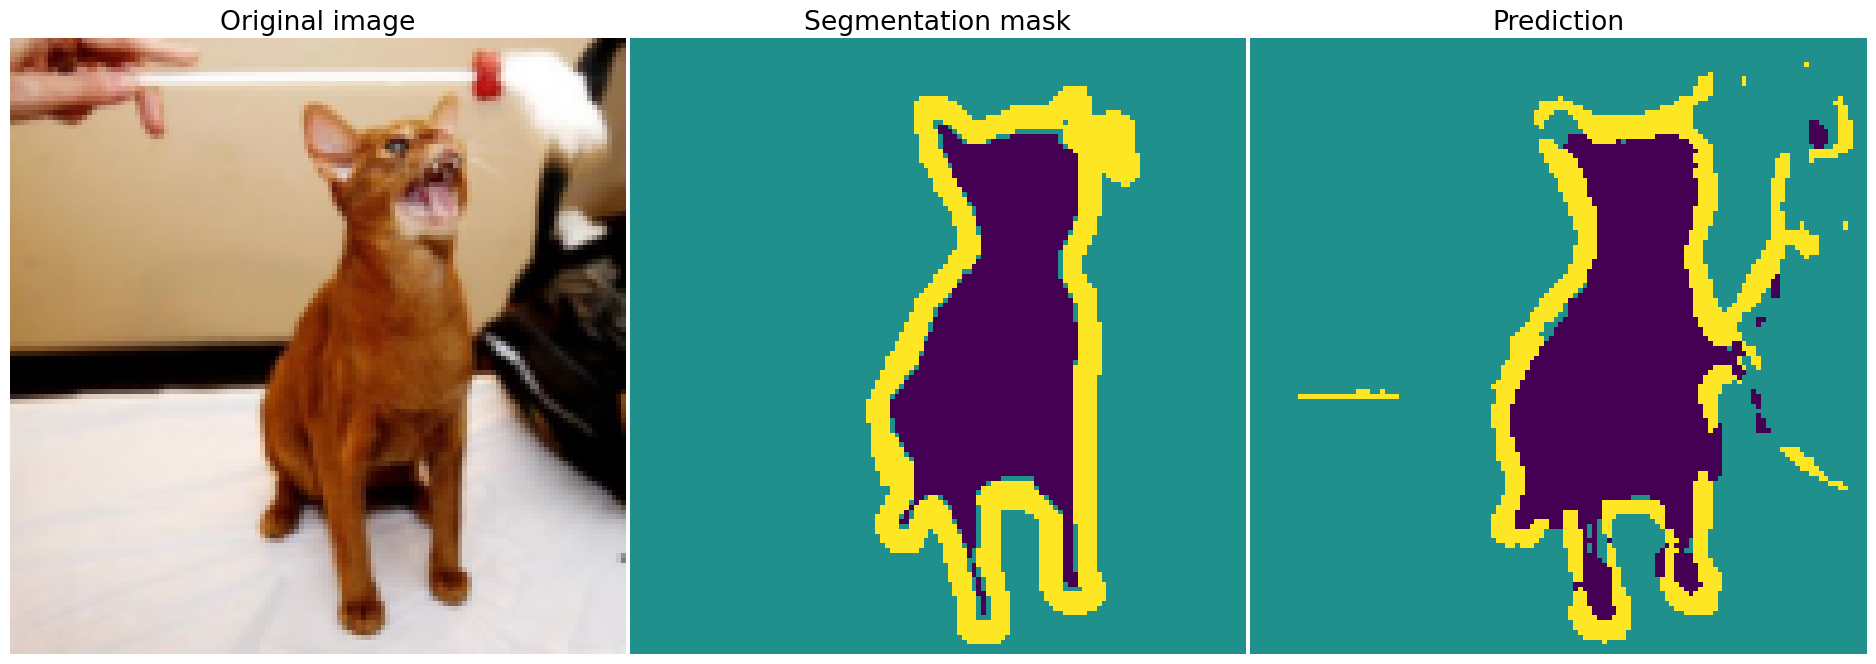

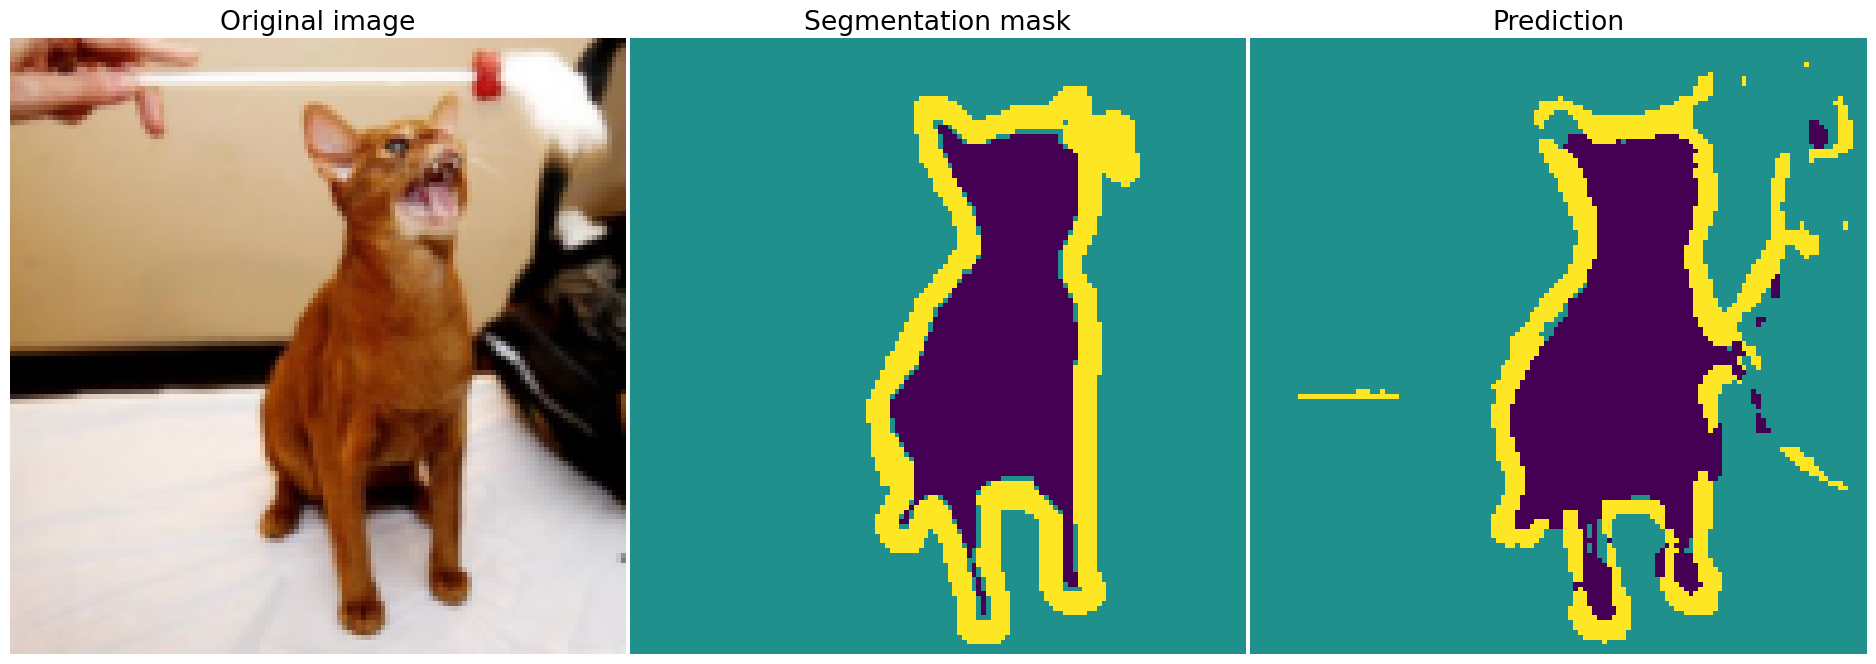

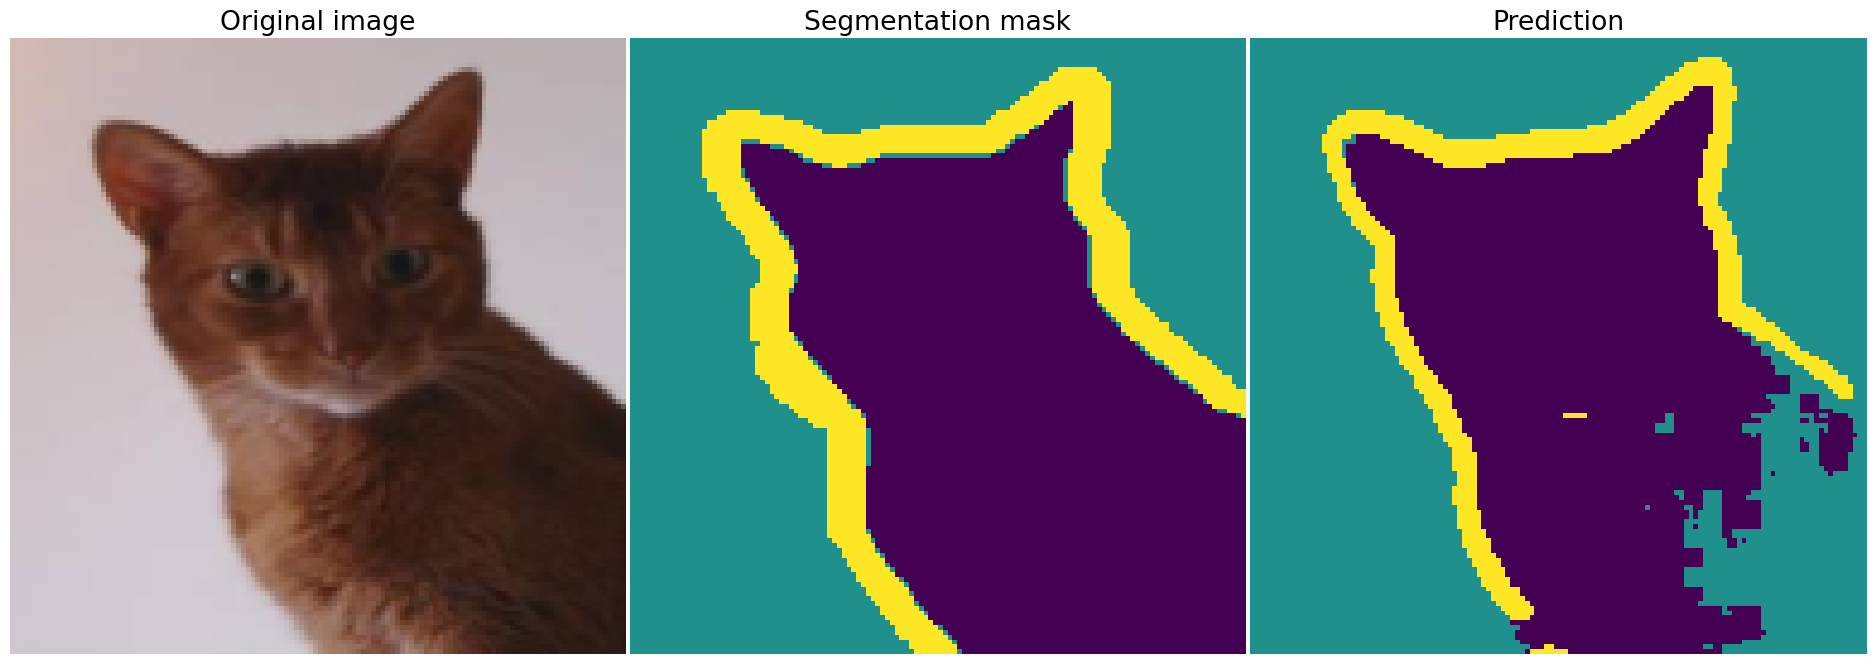

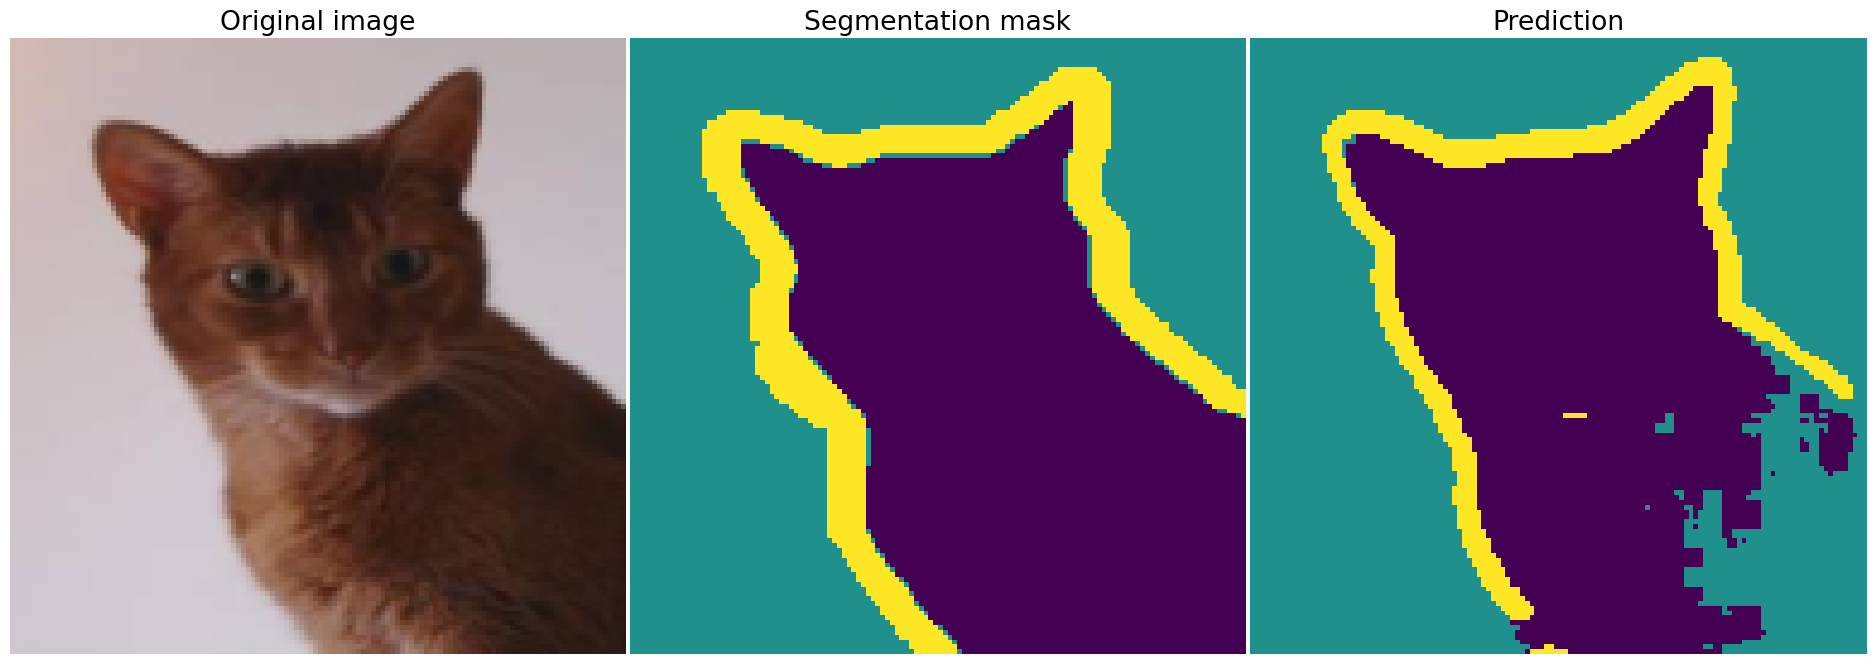

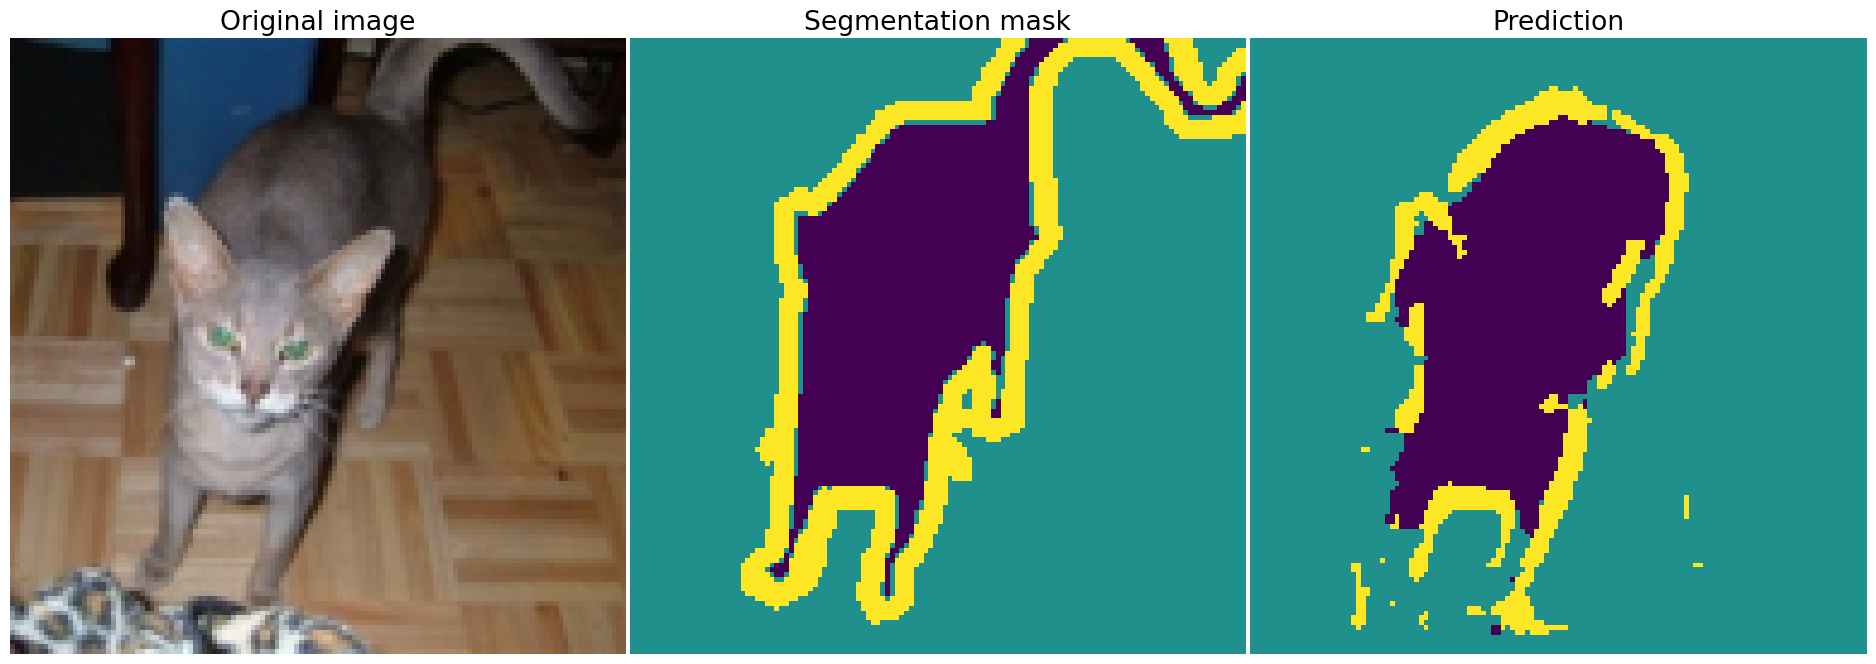

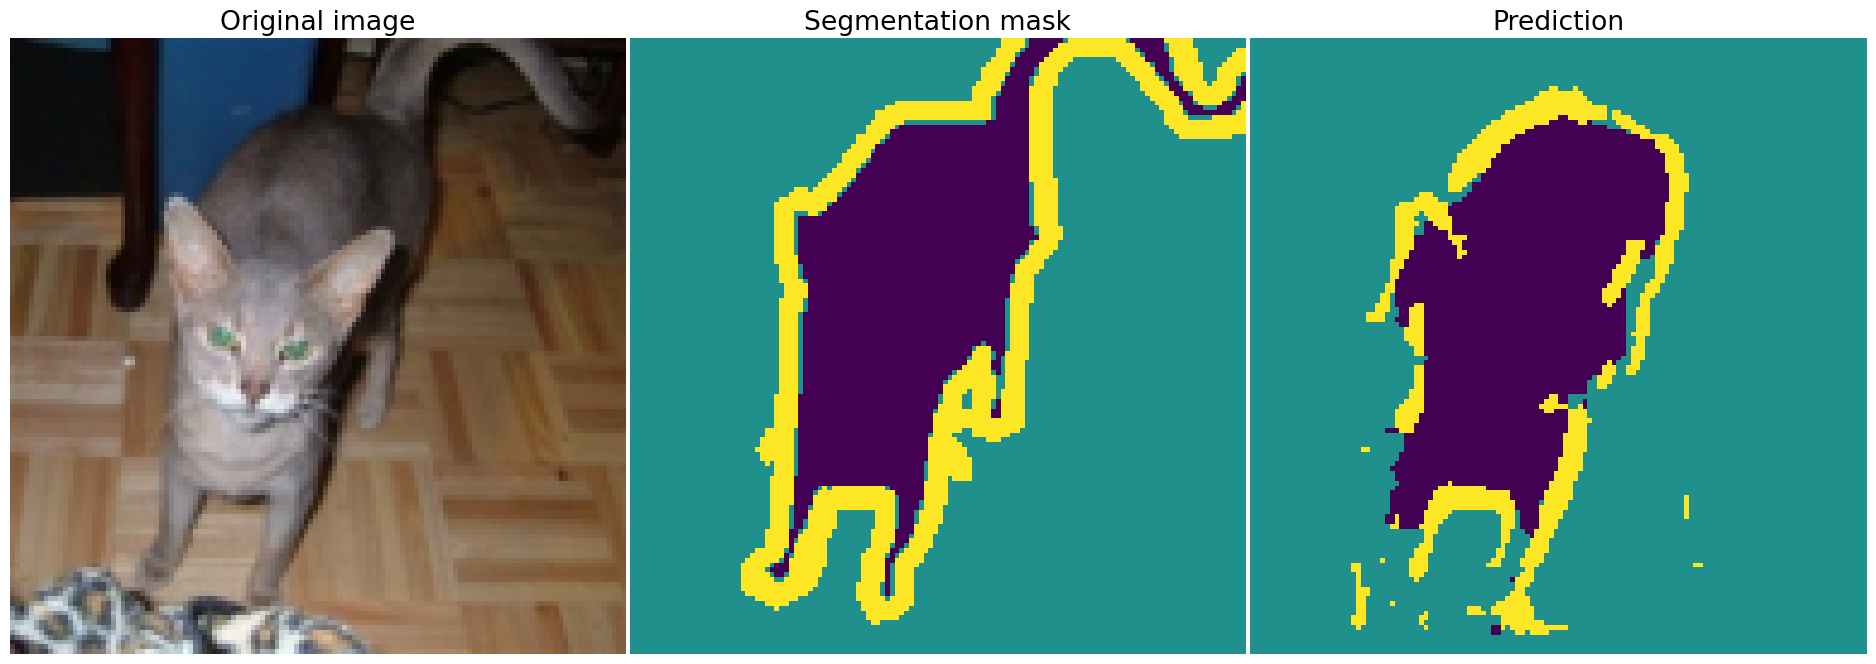

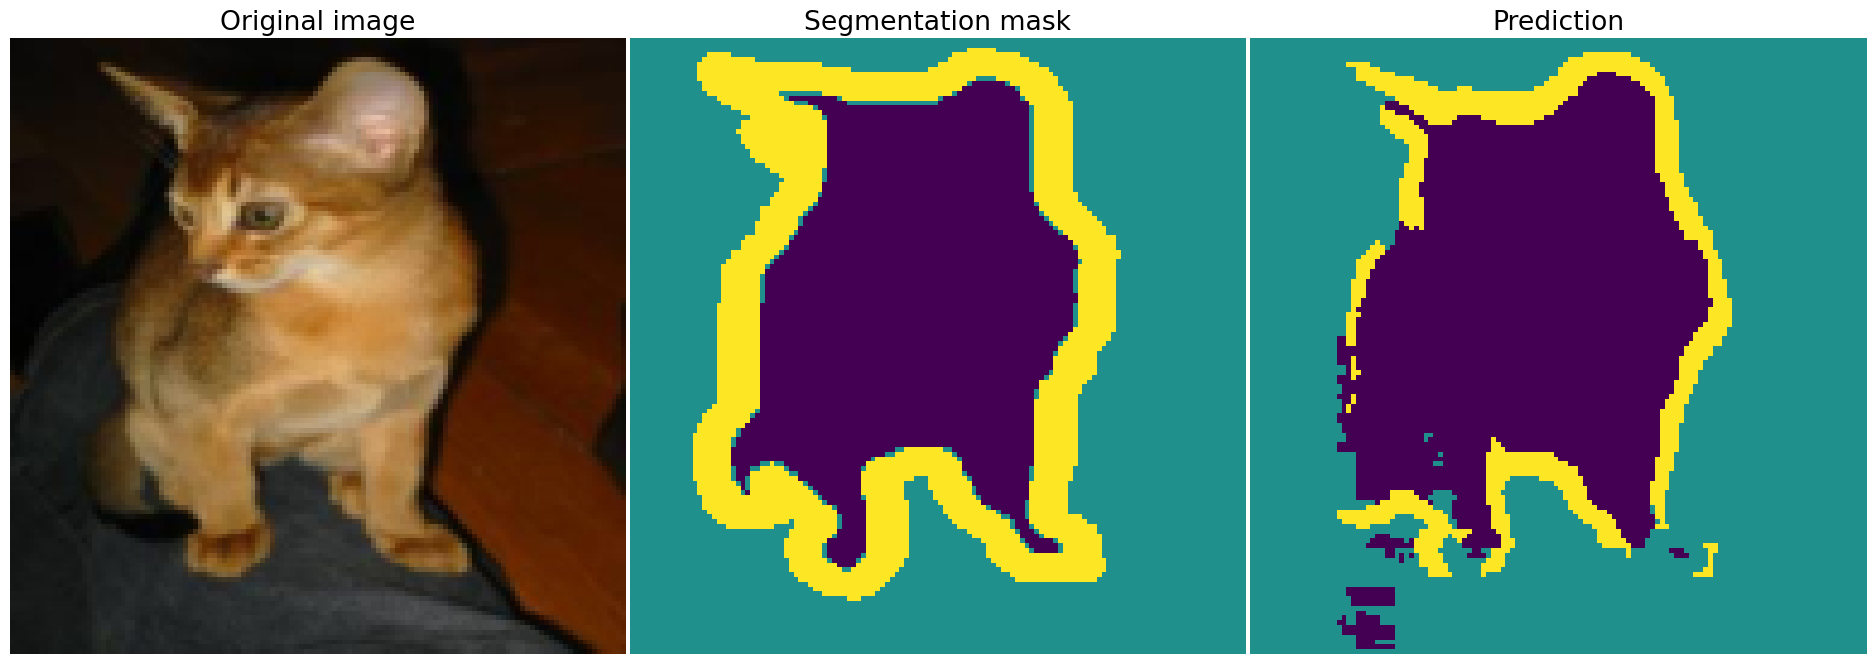

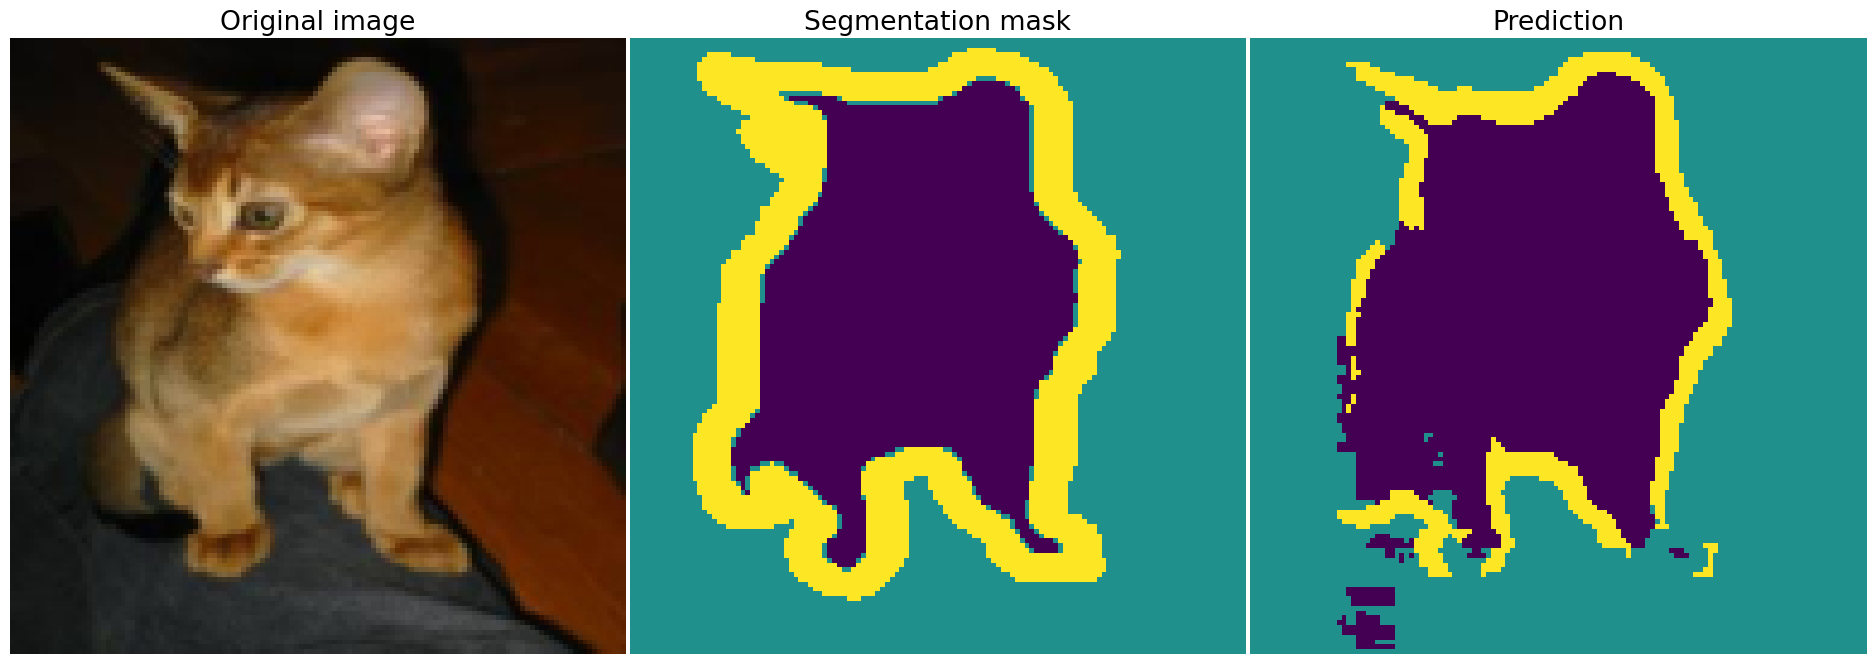

In [ ]:
whole_train_valid_cycle(model, 40, 'UNET segmentation')

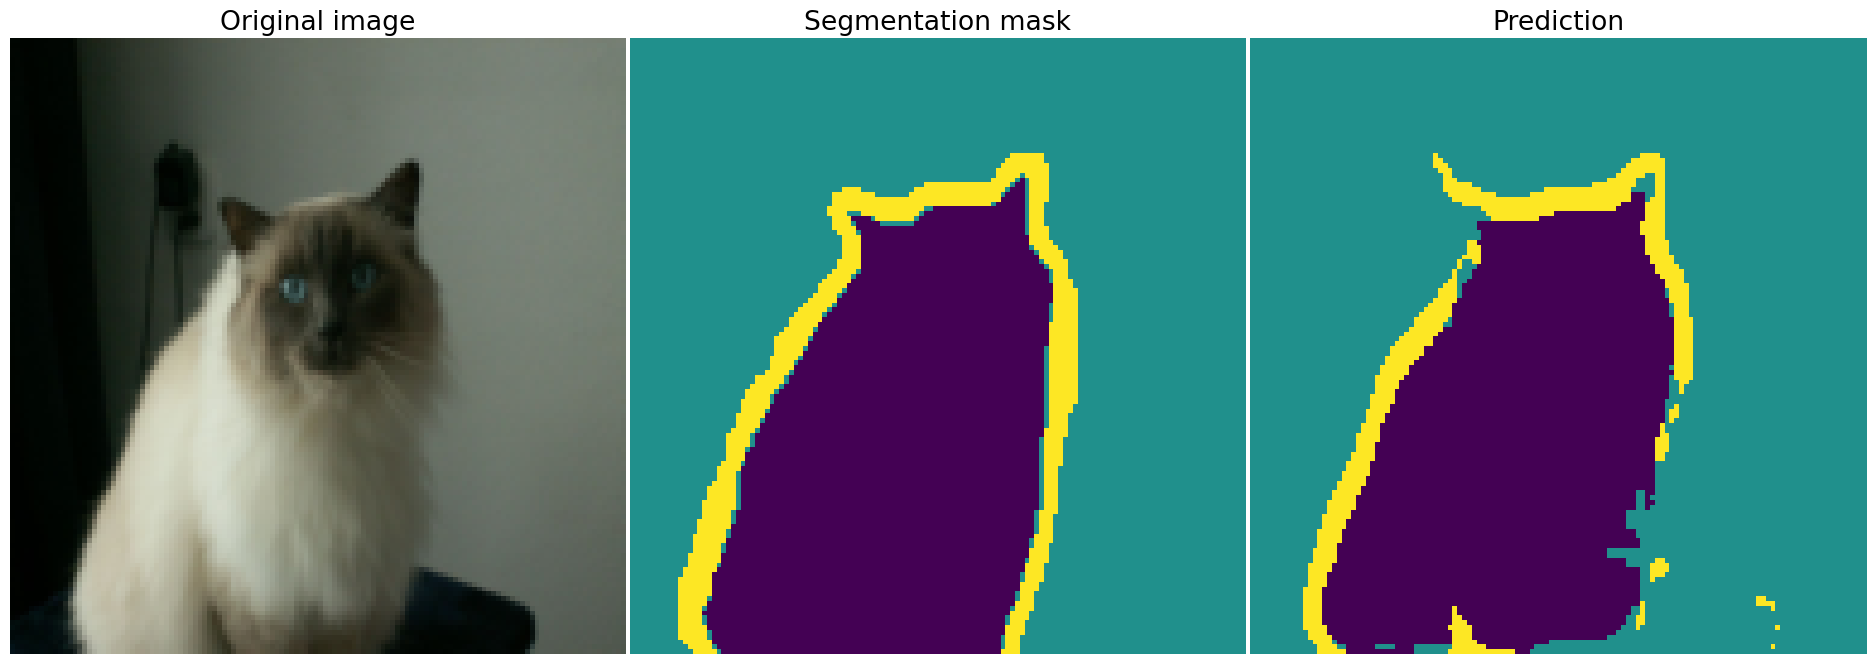

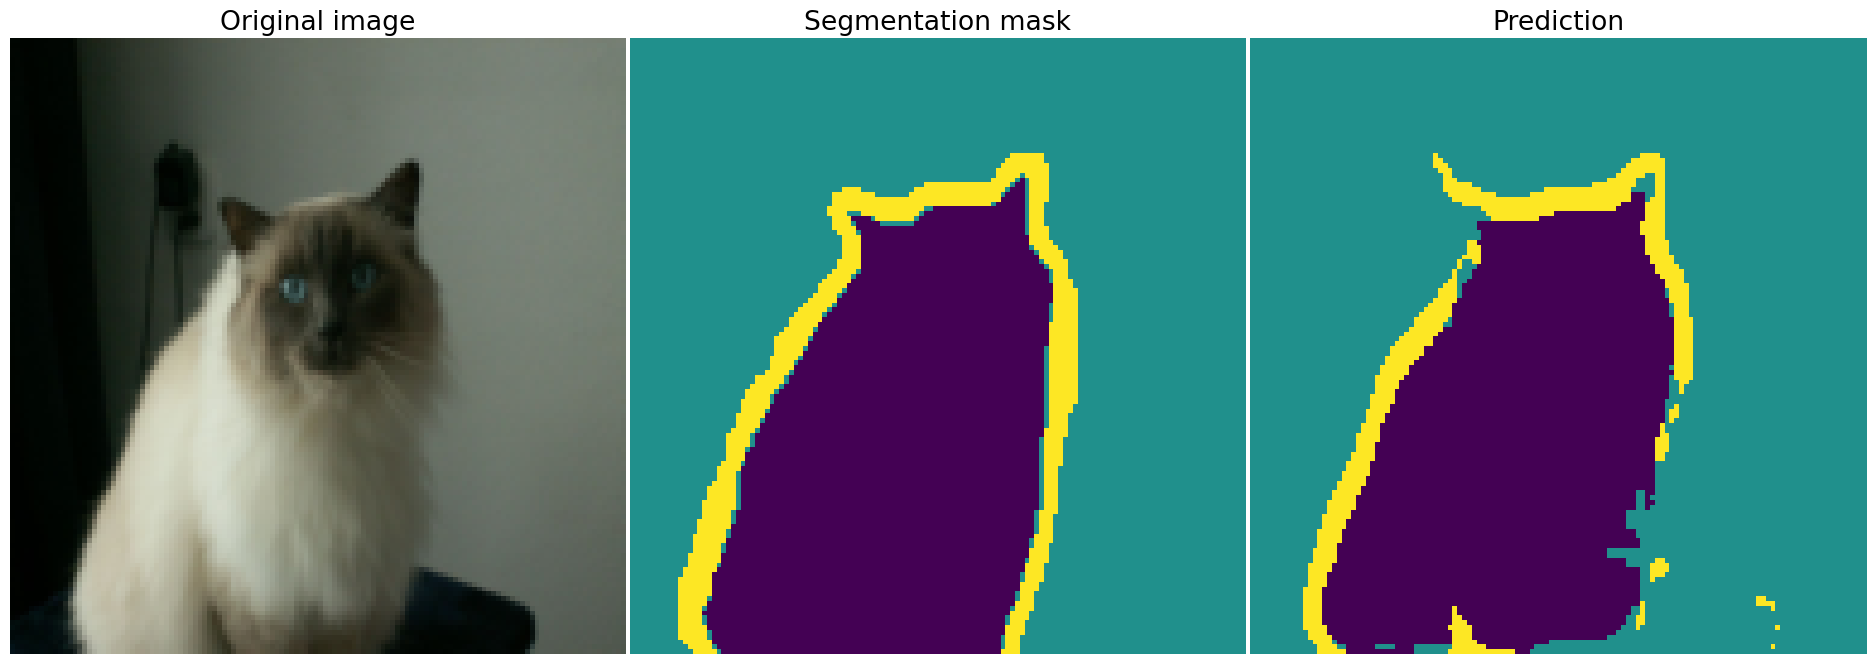

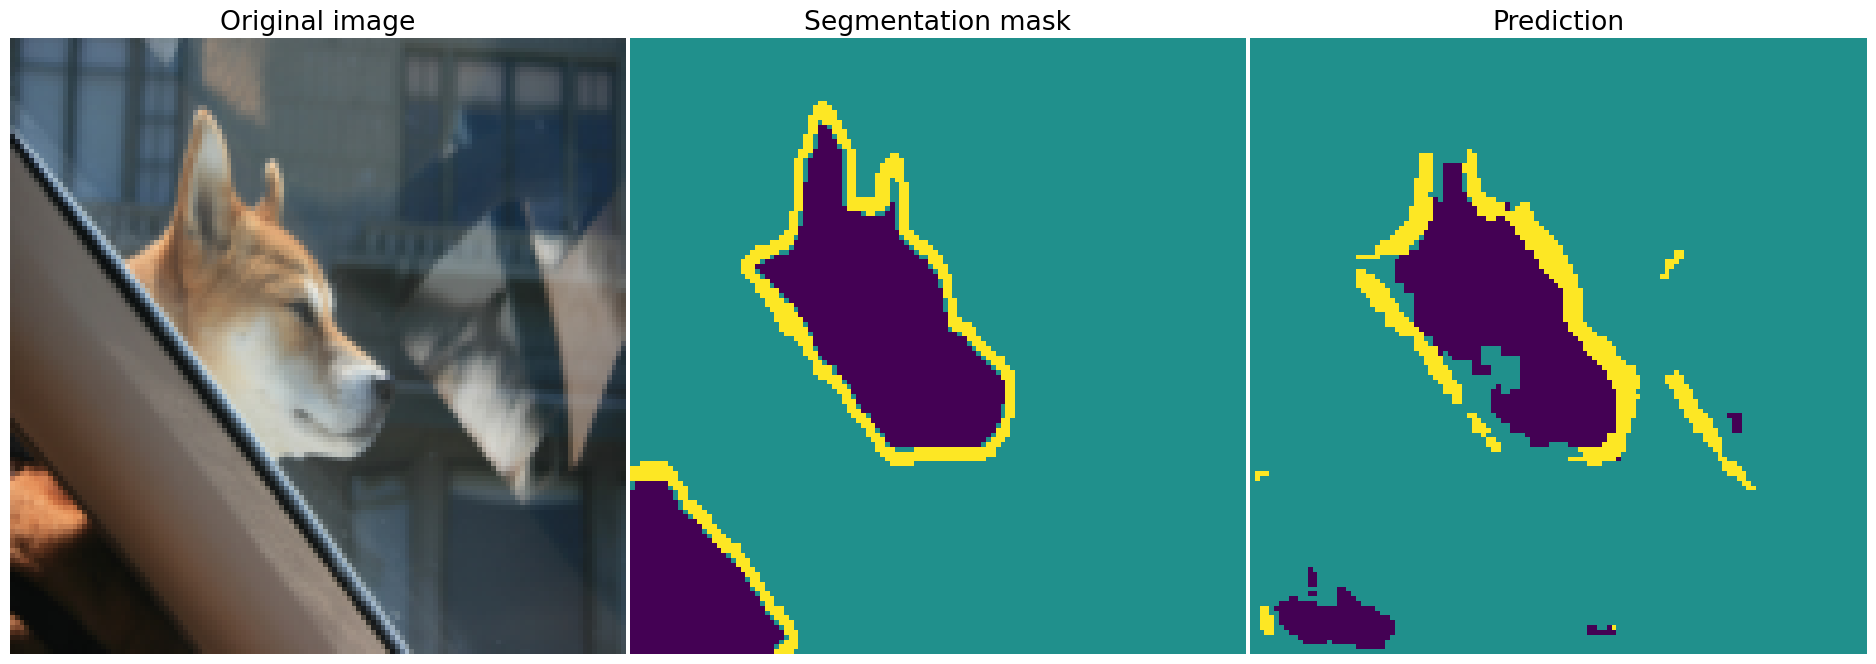

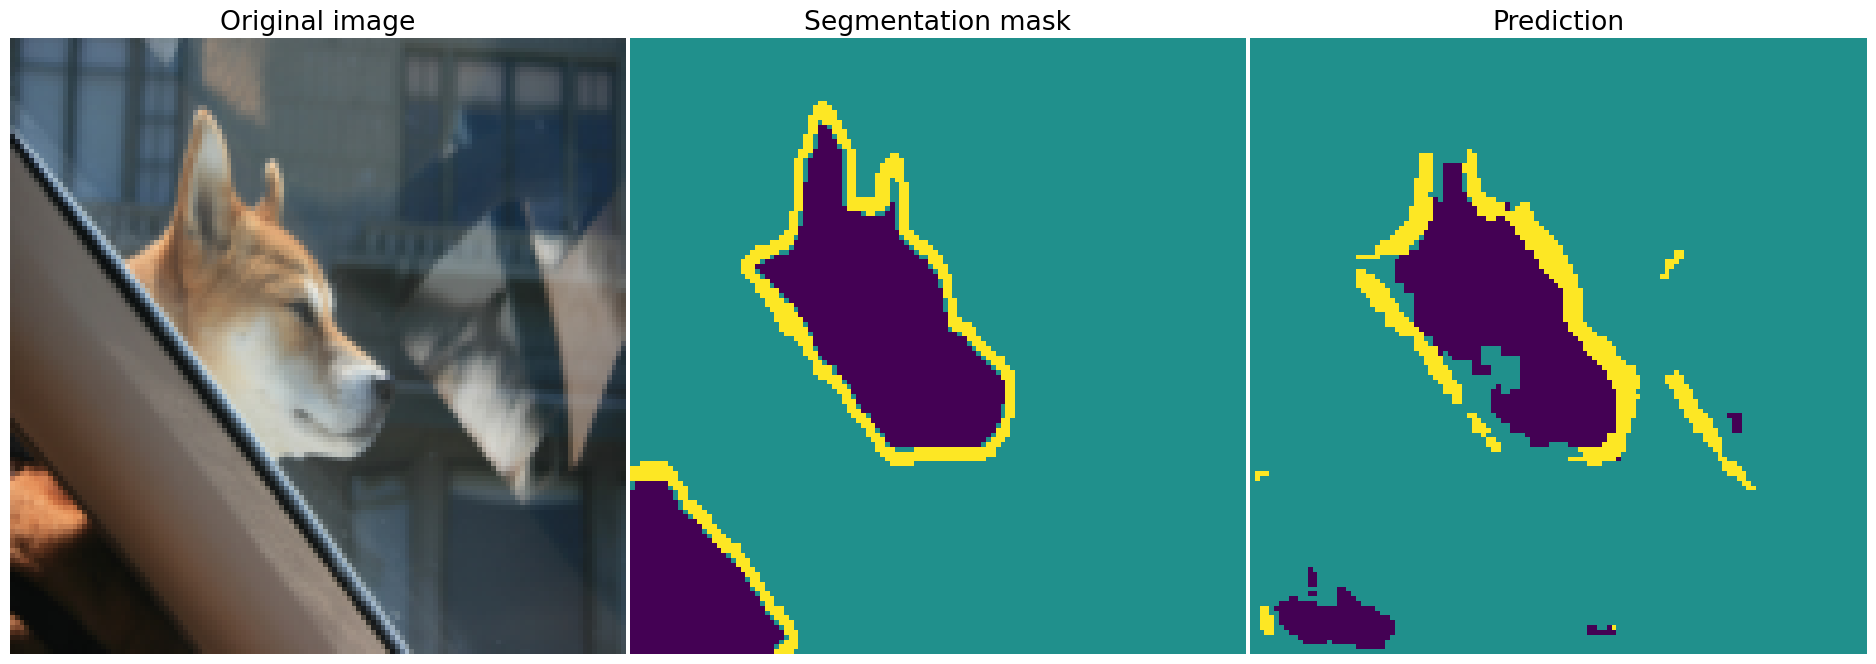

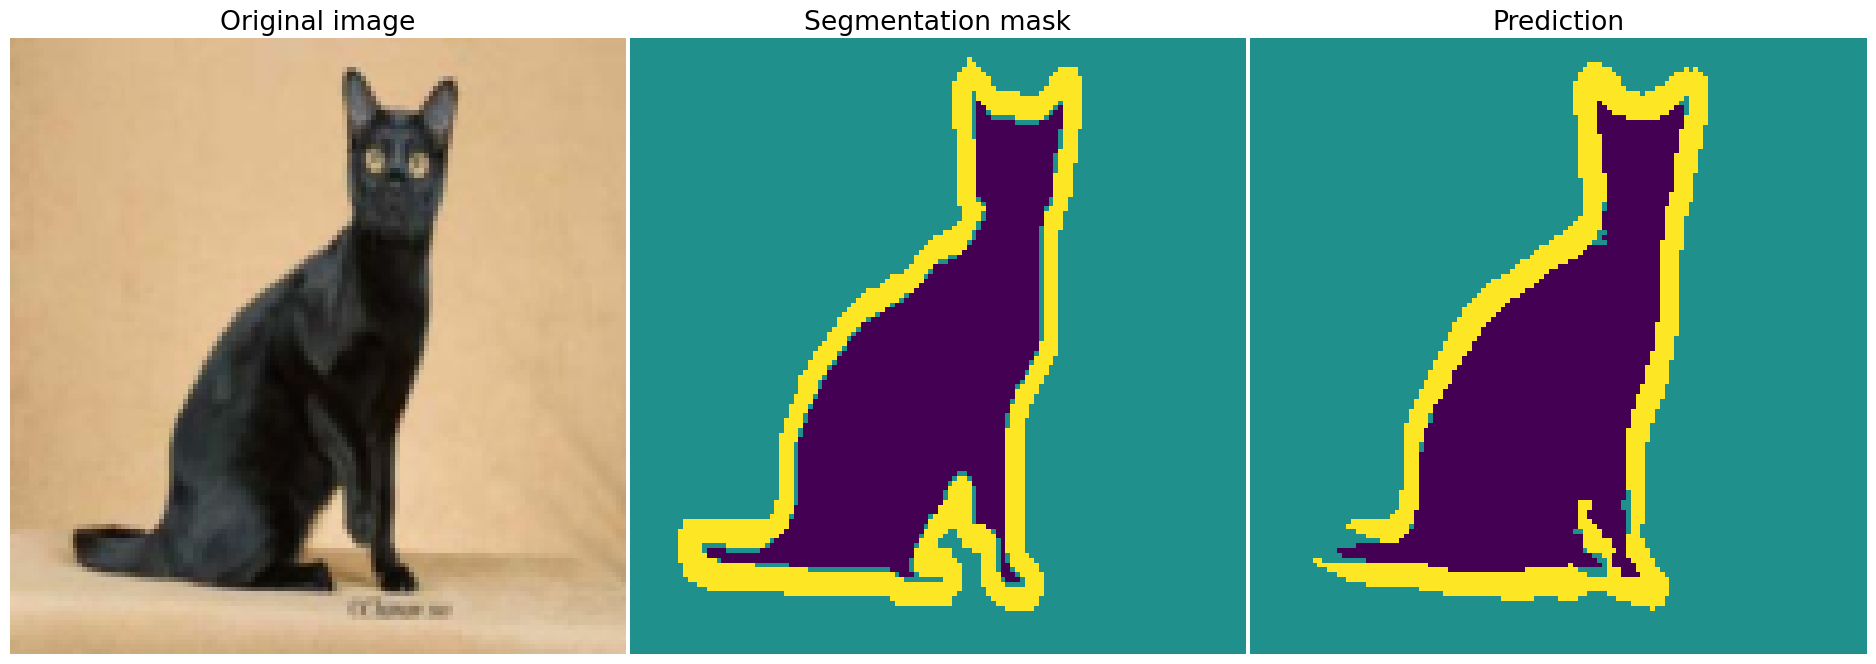

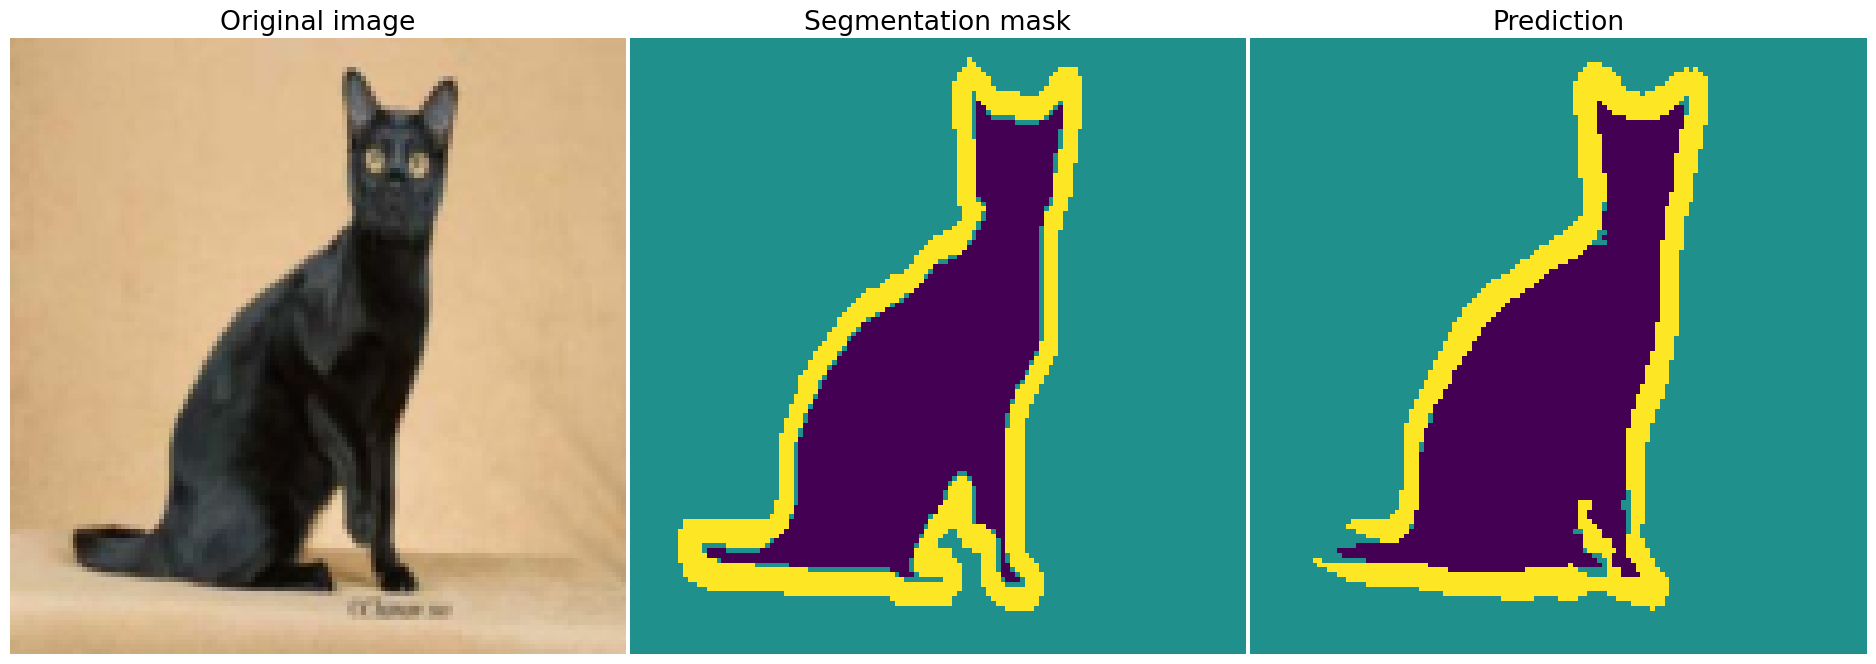

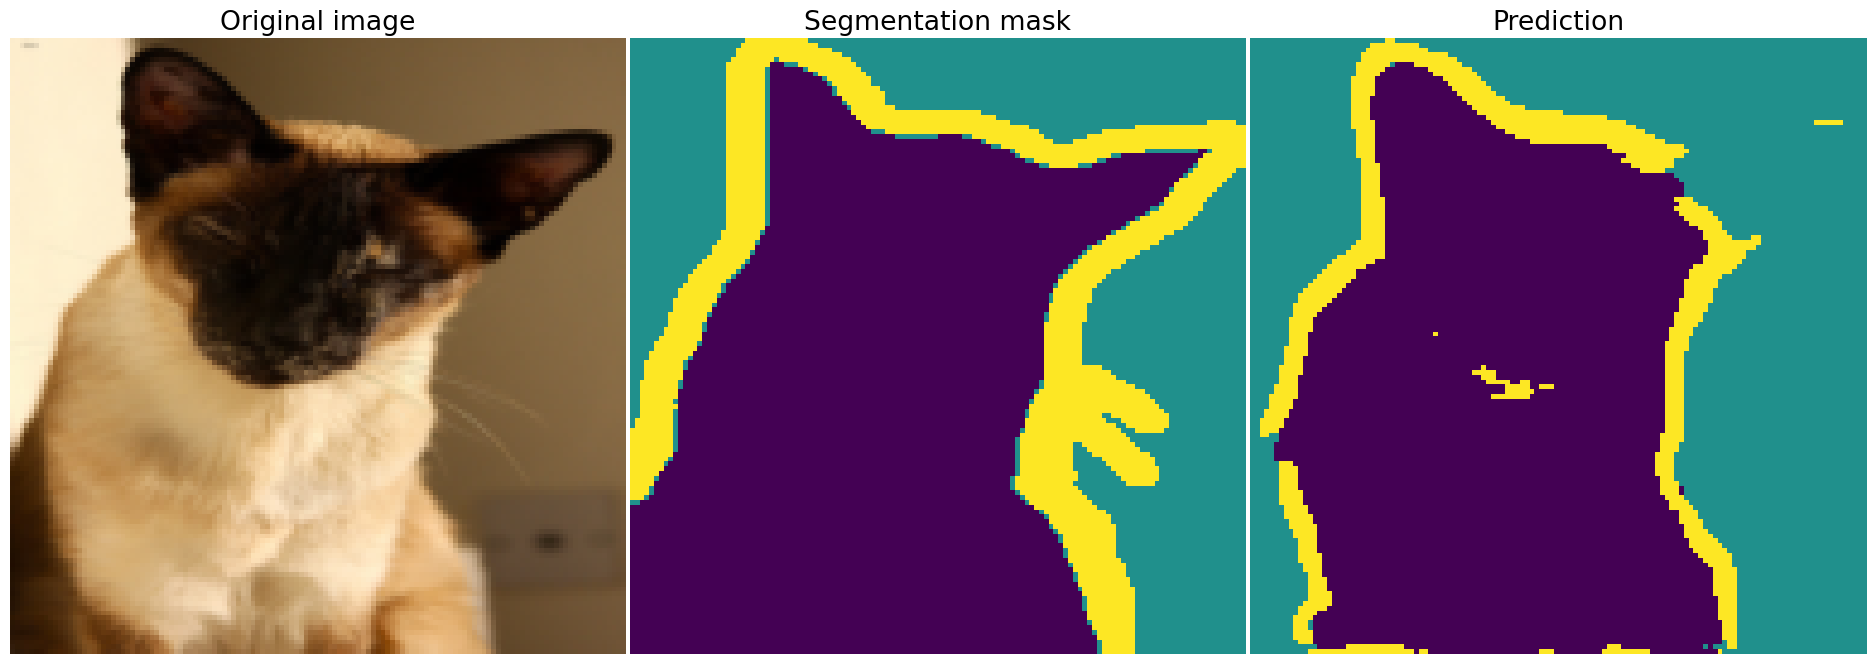

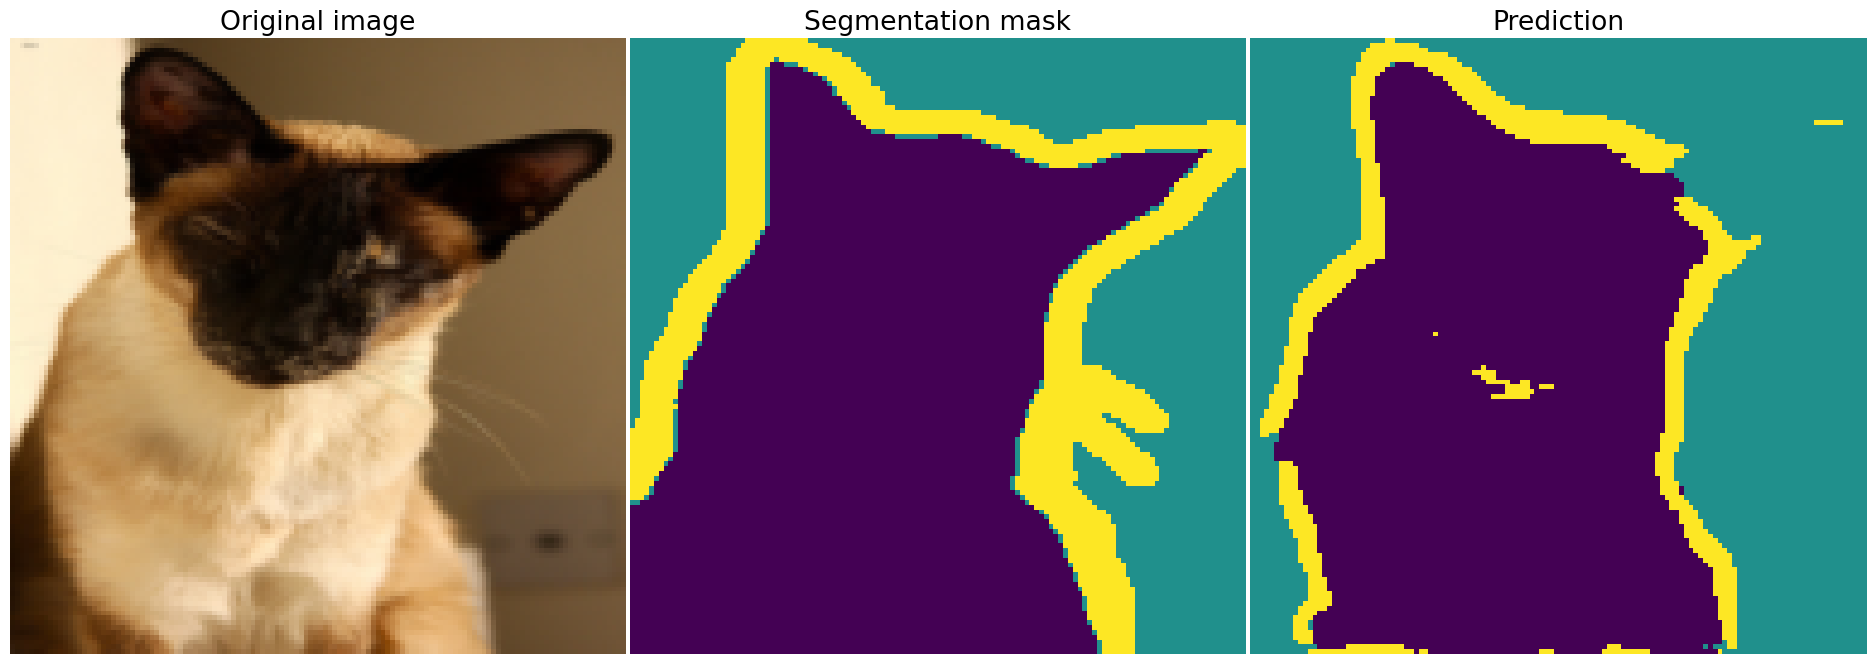

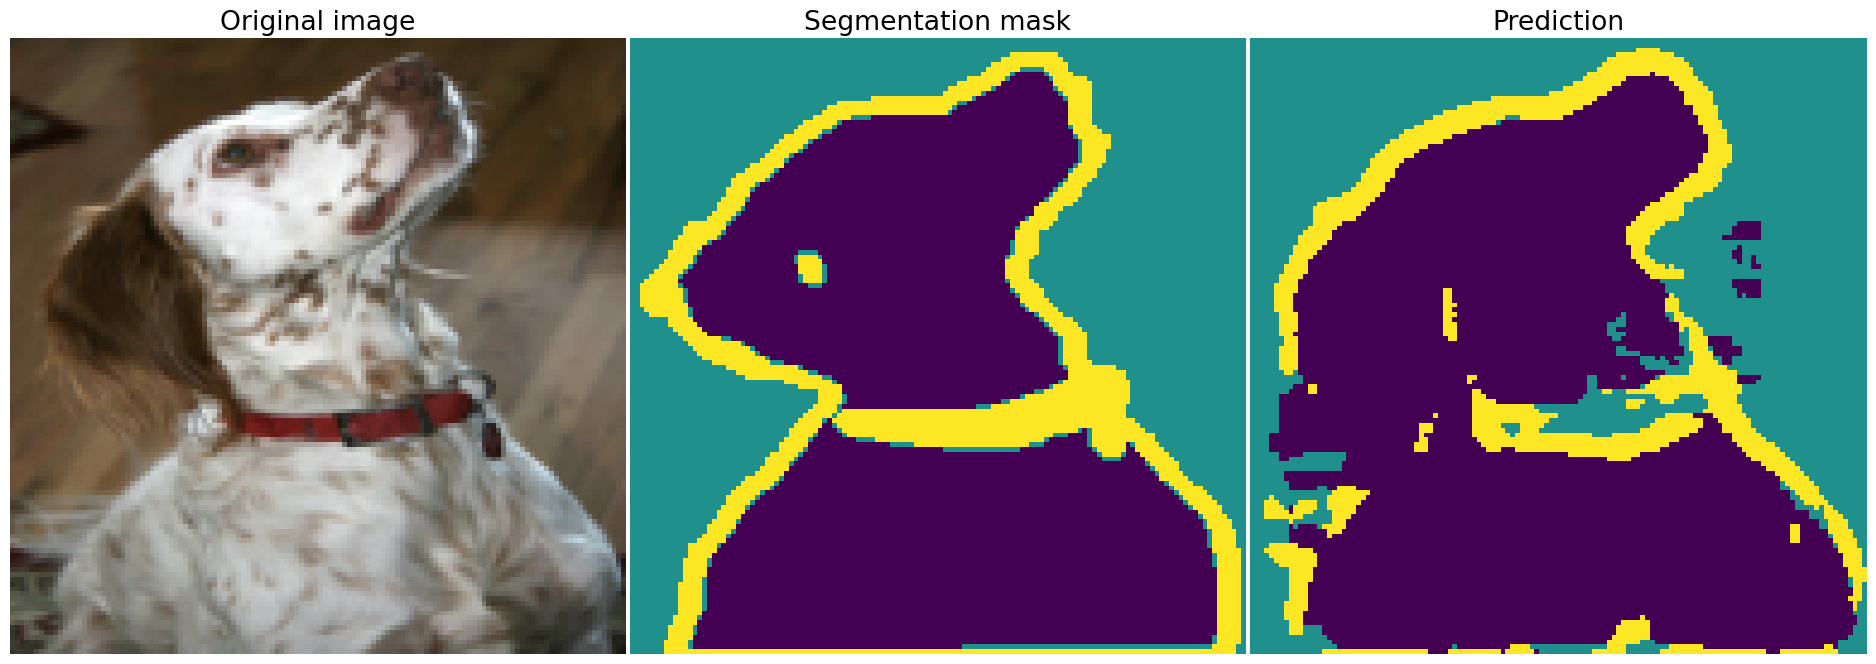

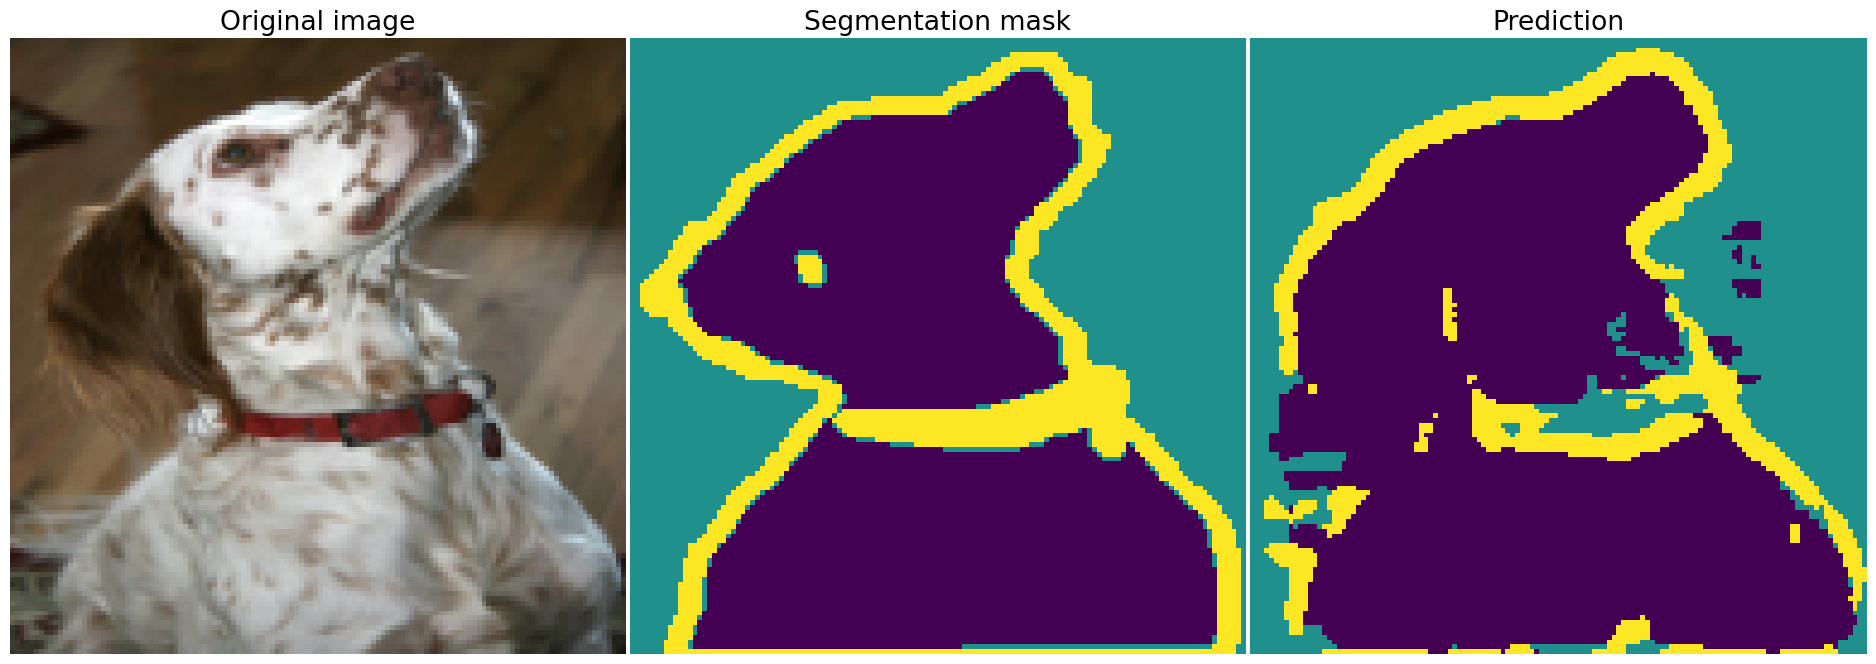

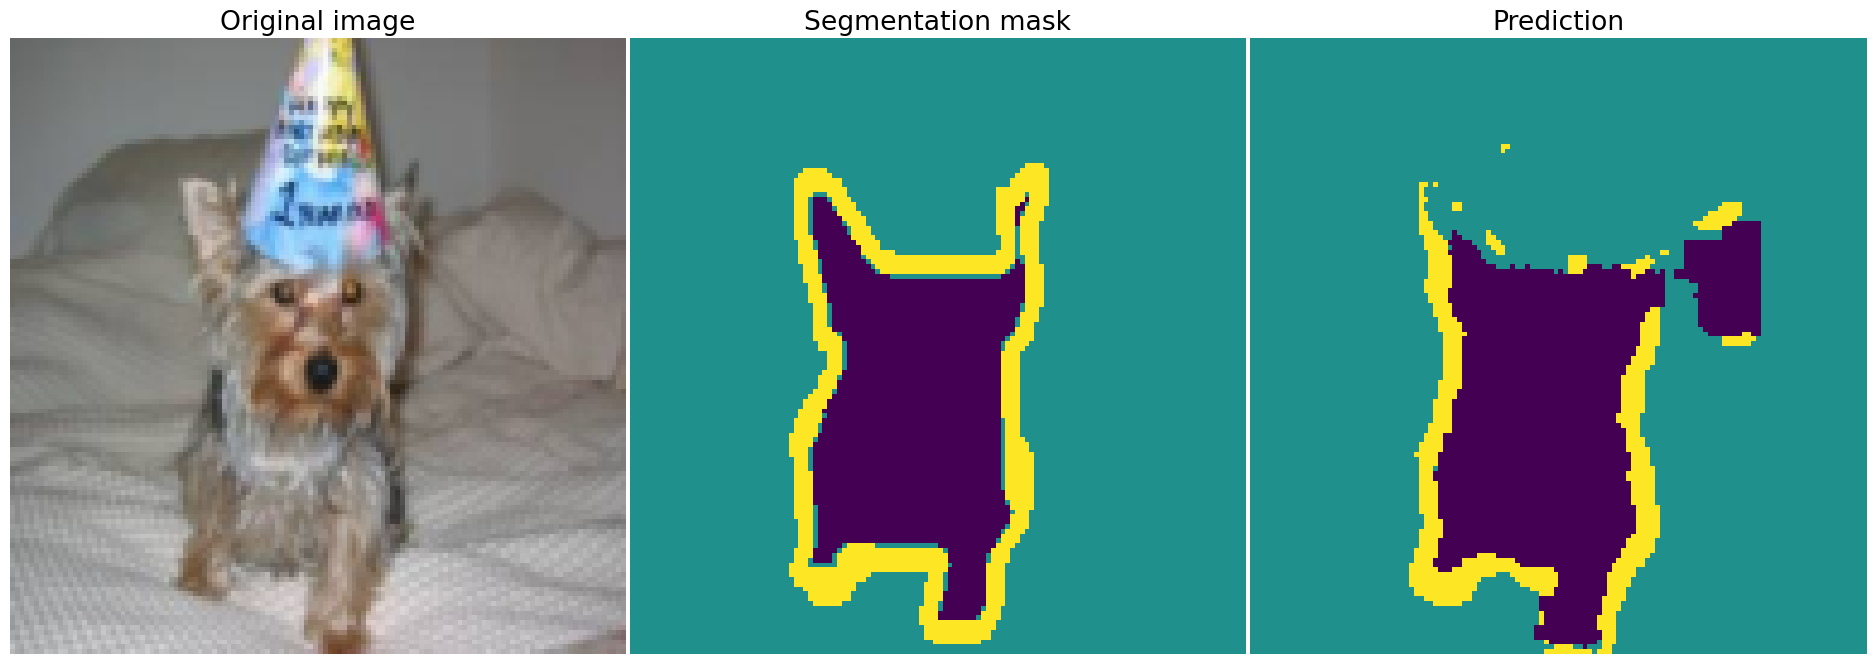

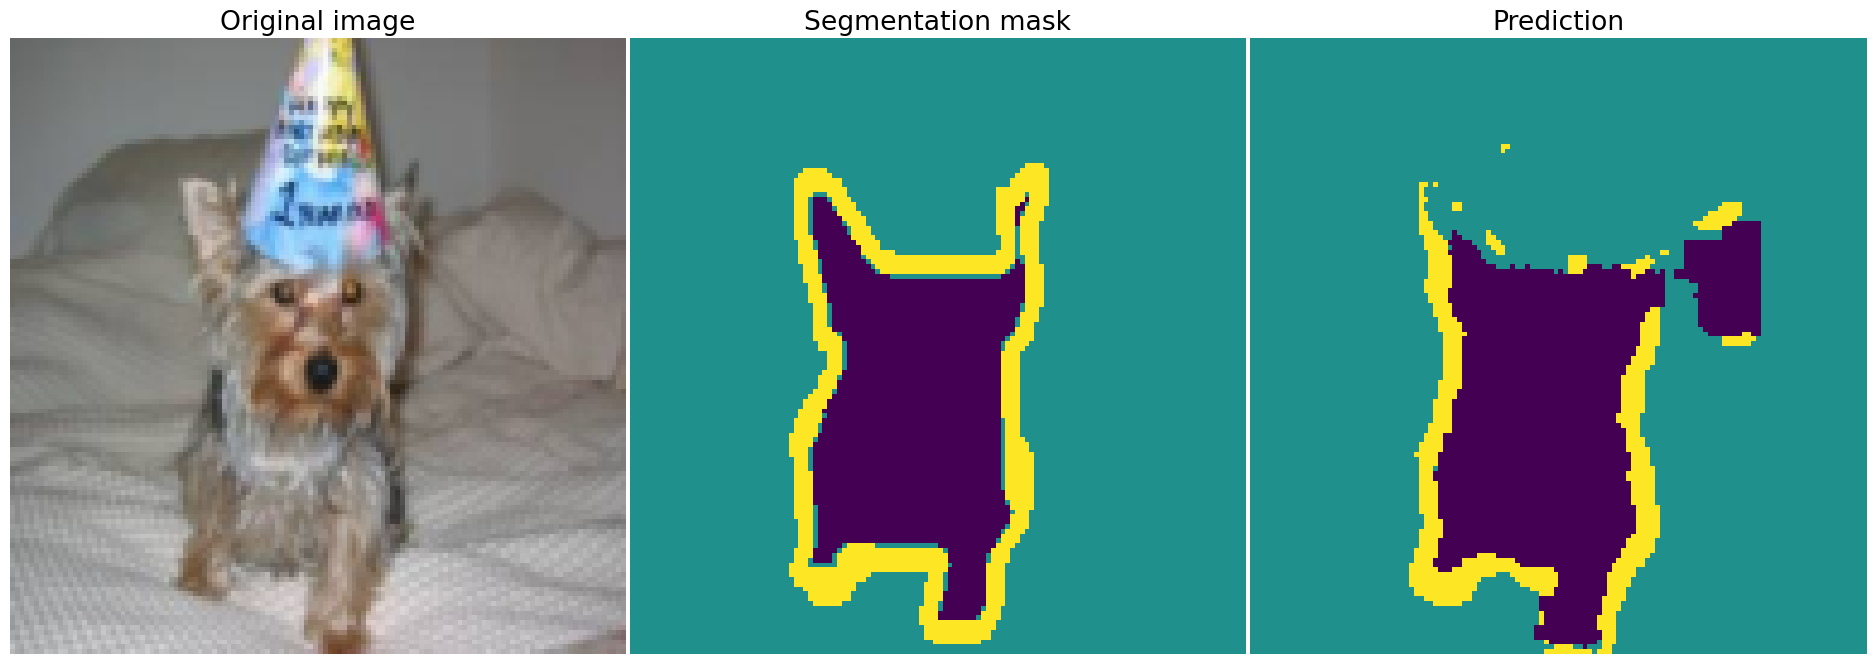

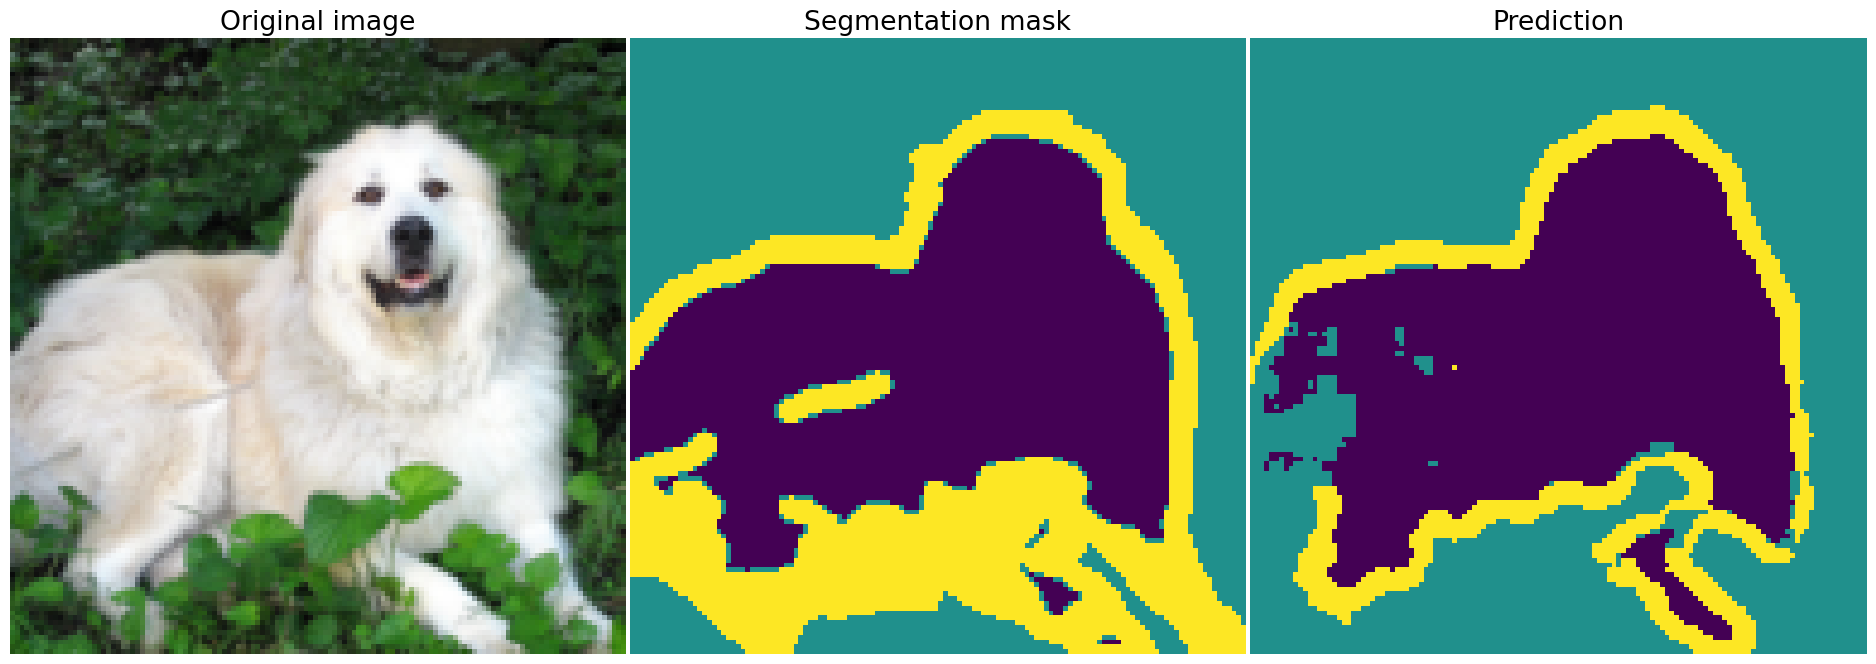

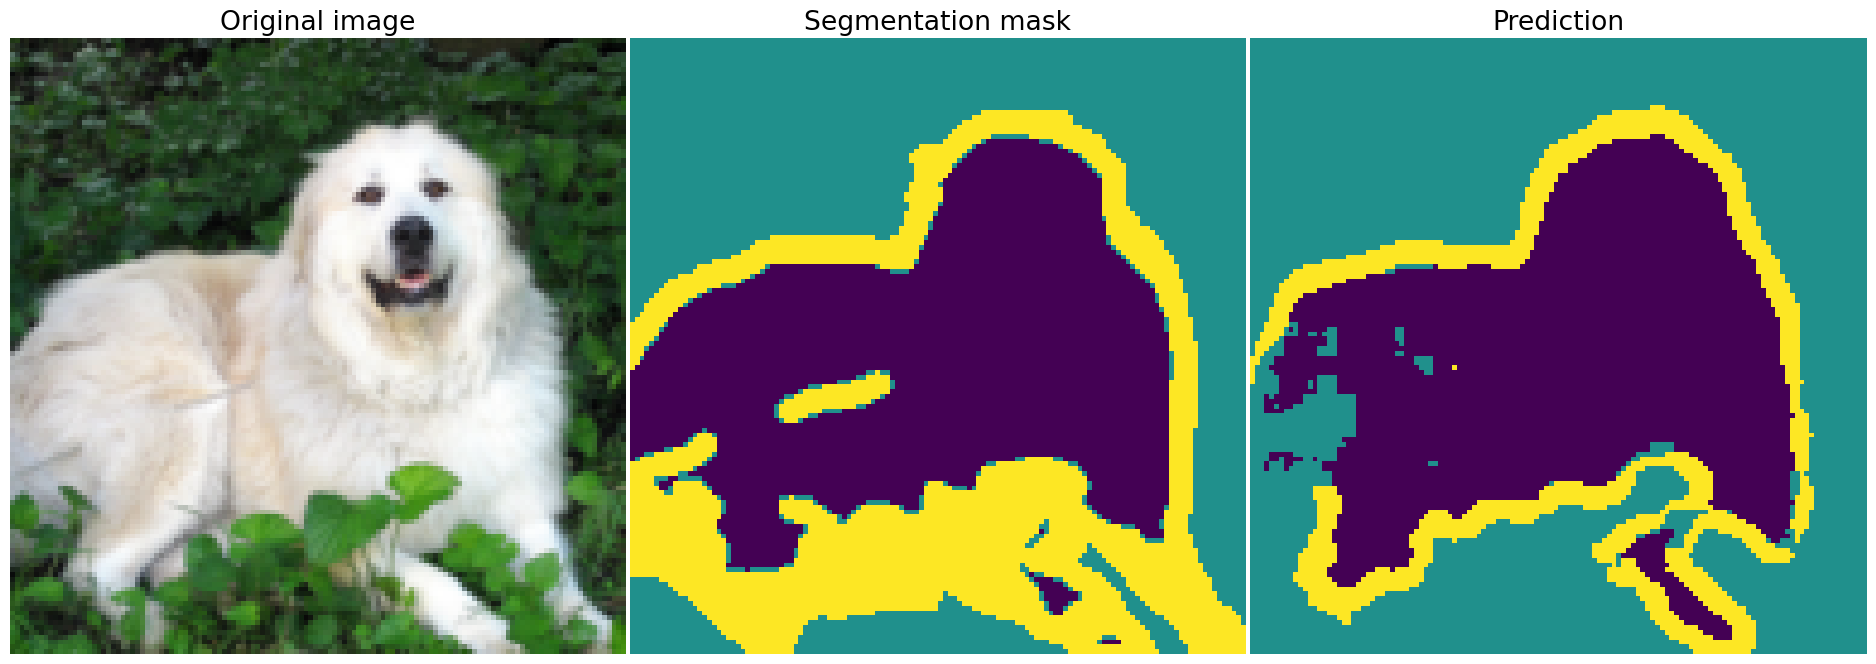

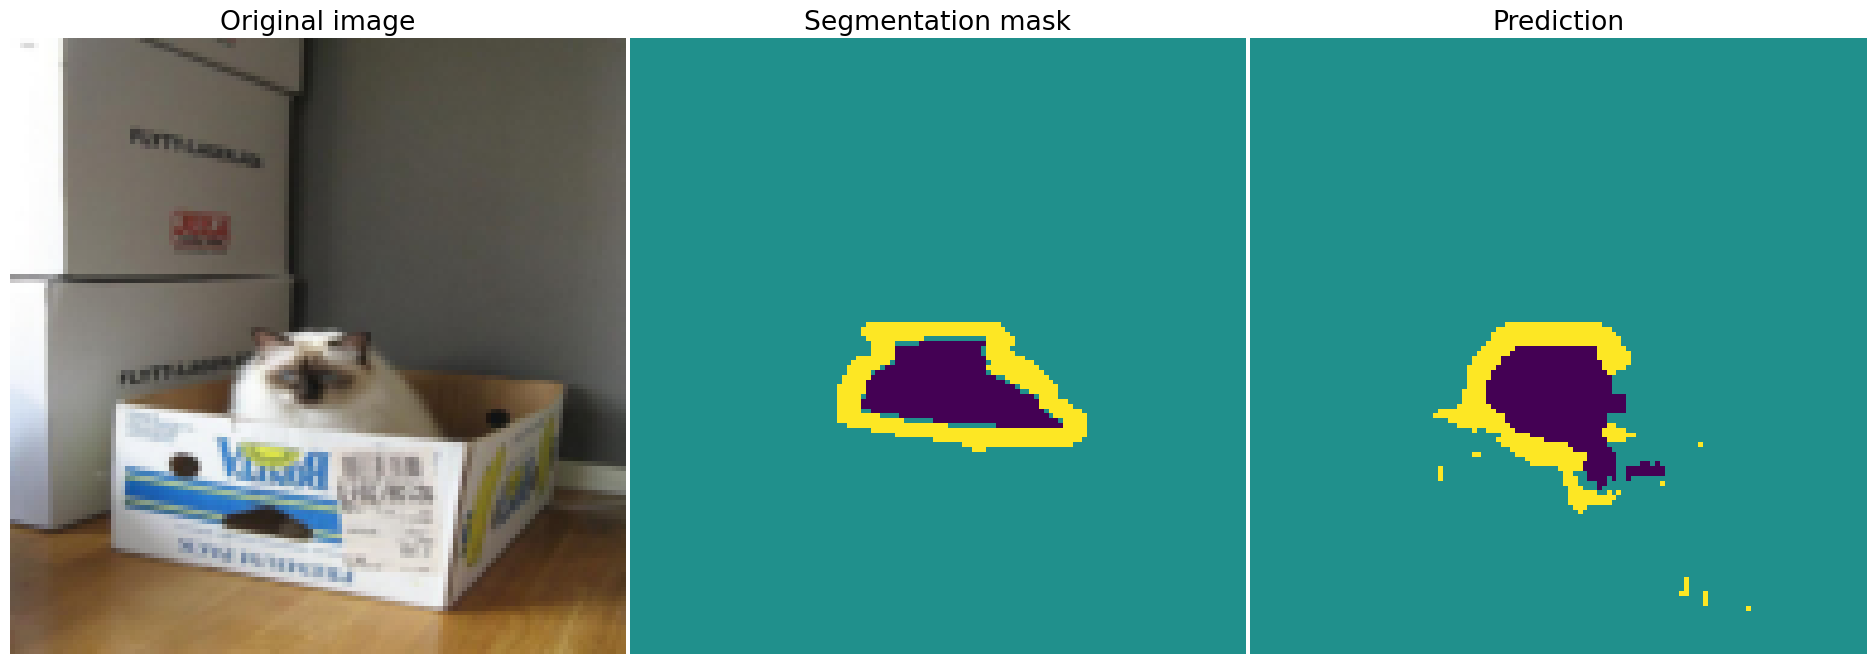

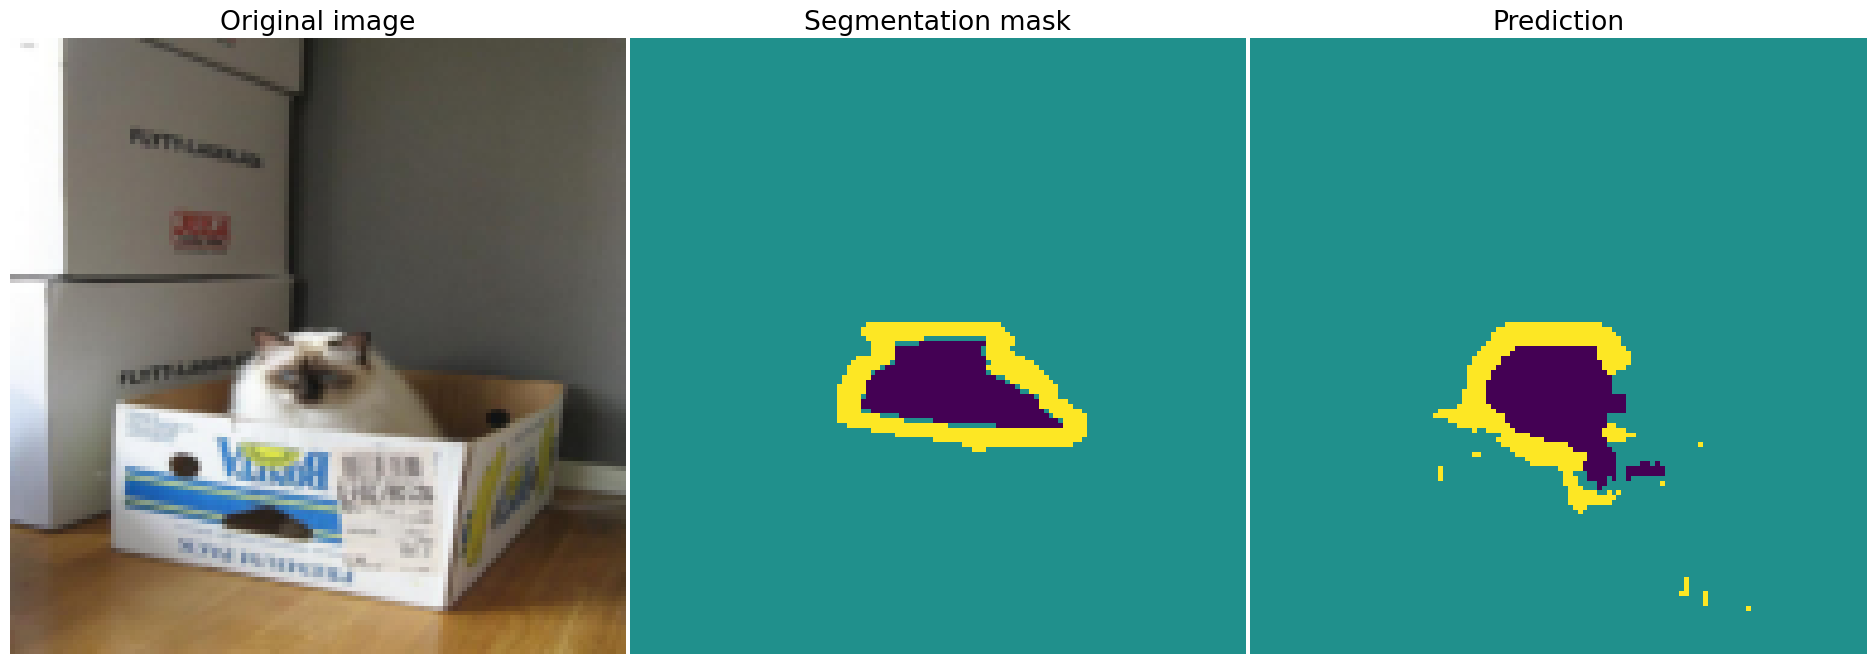

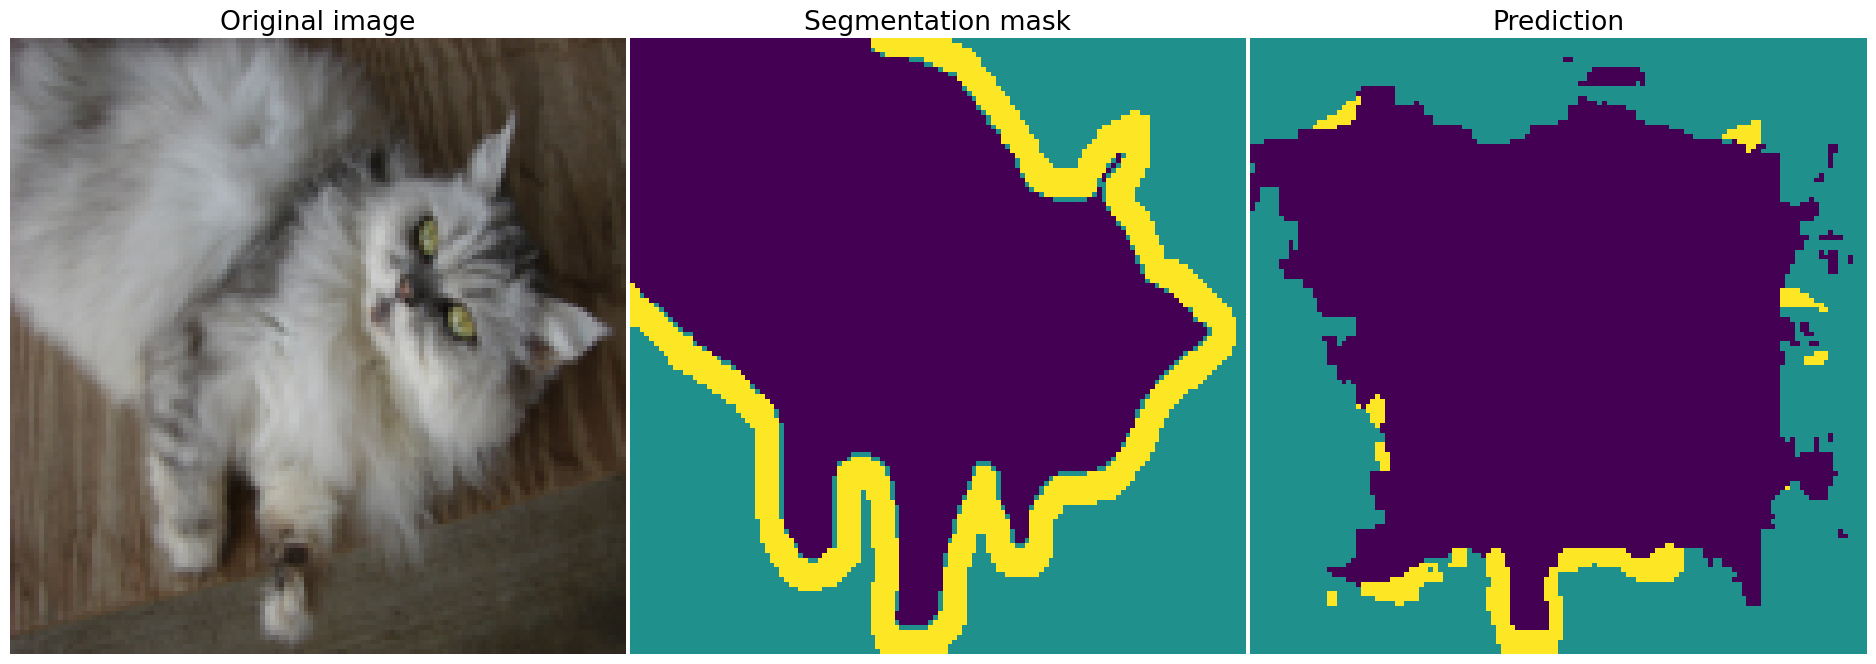

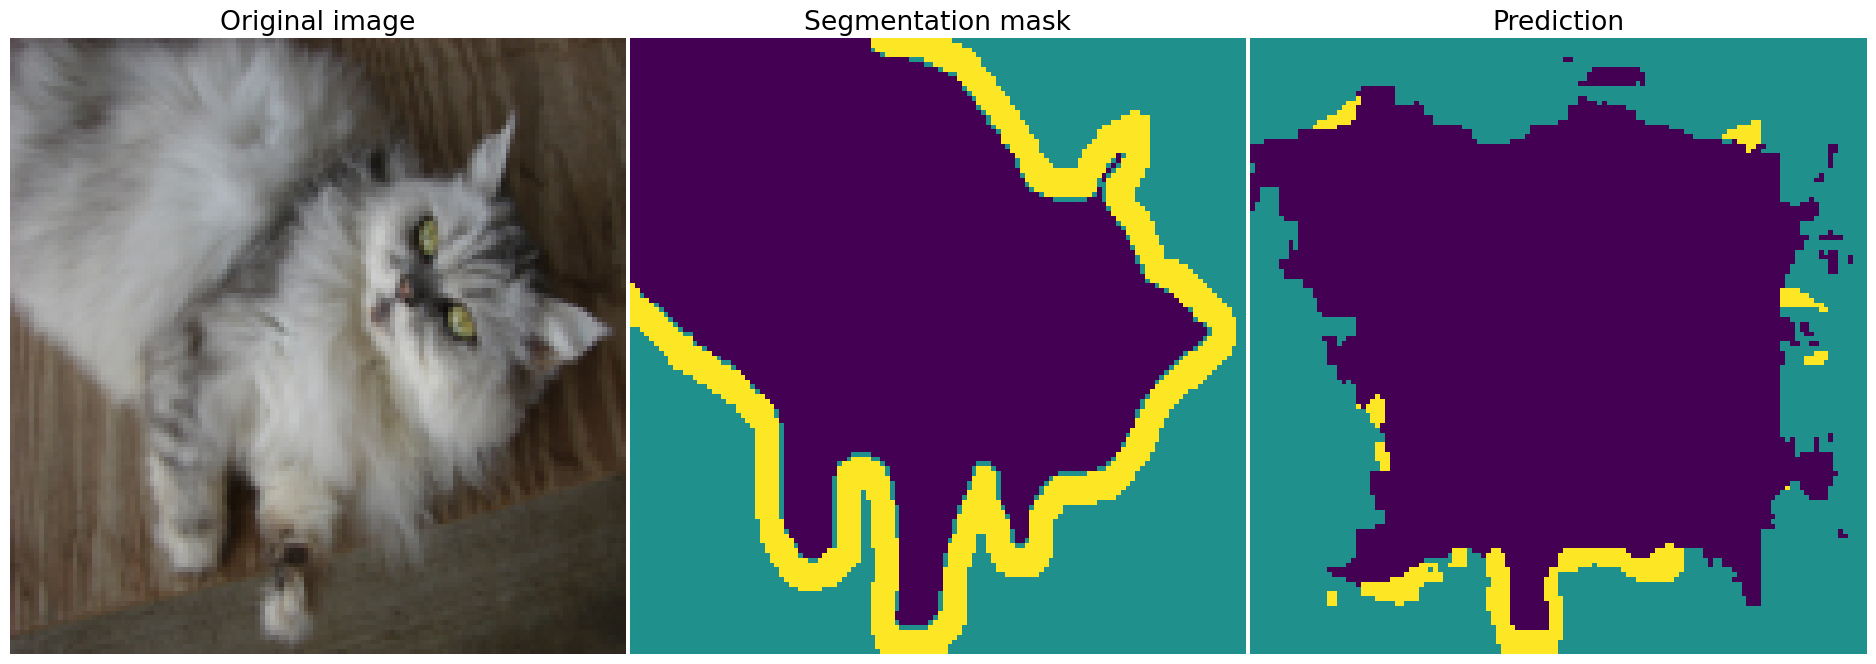

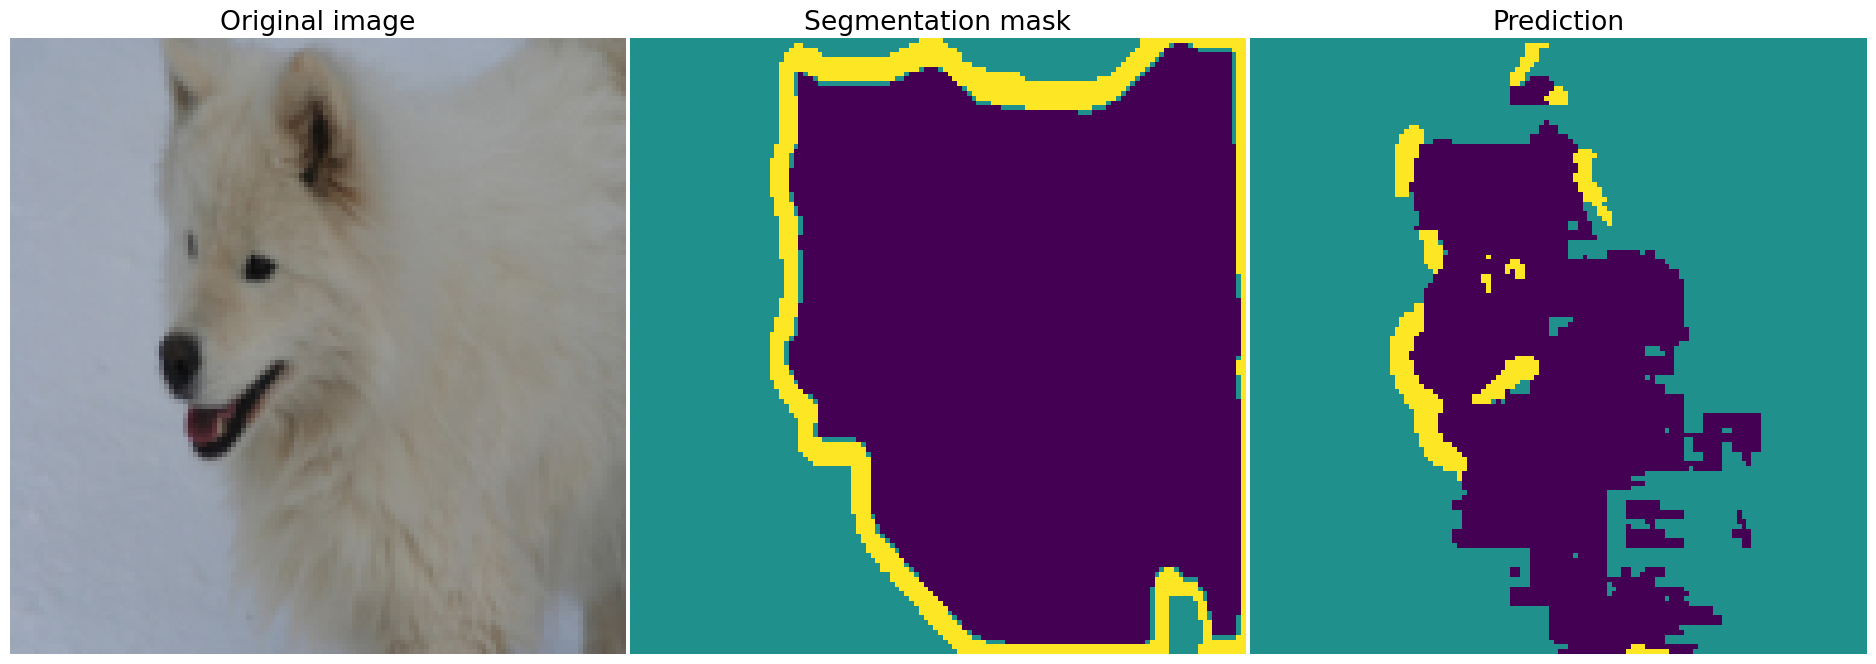

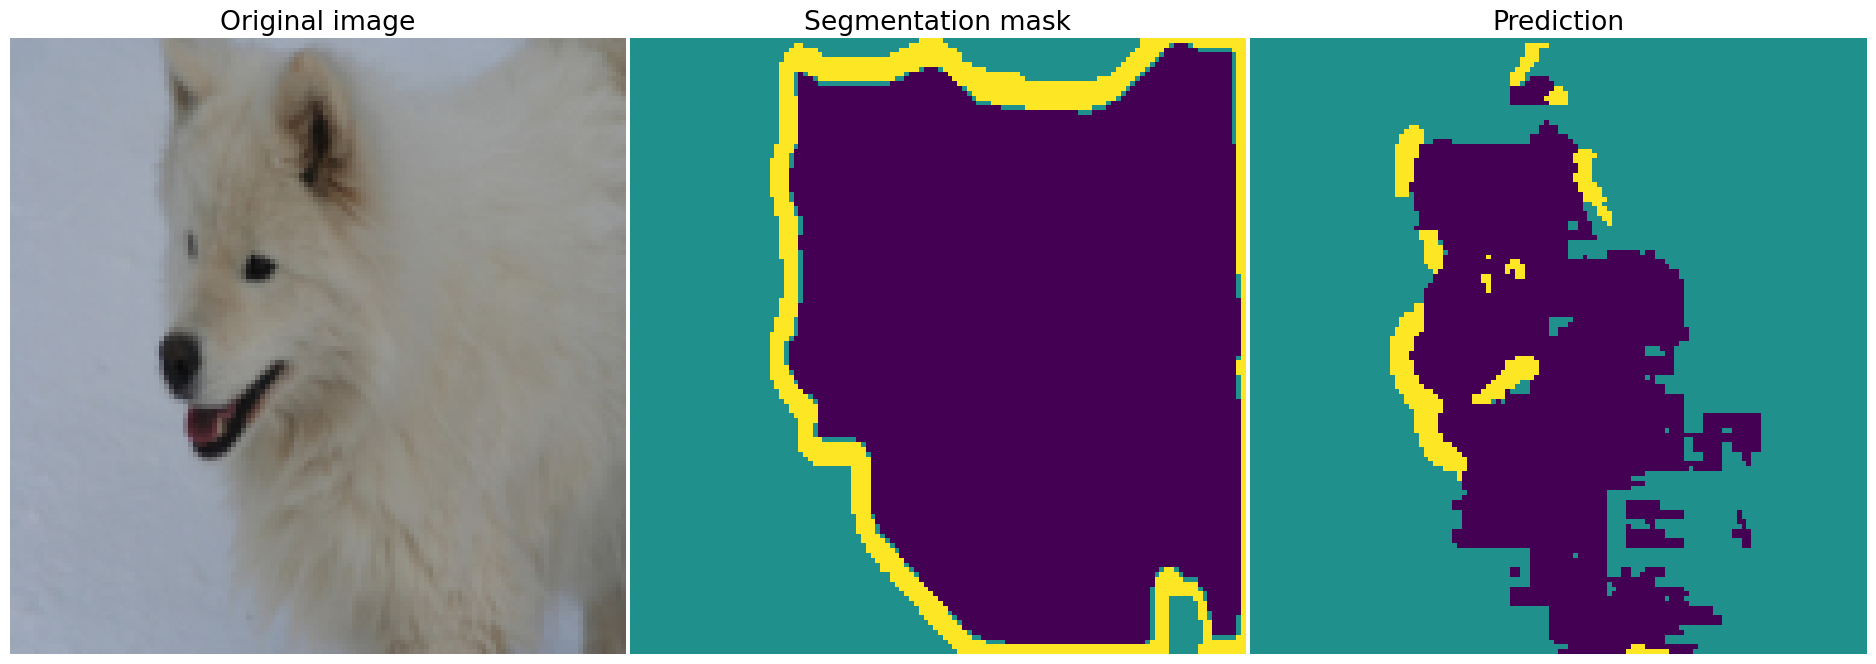

In [ ]:
visualize(model, next(iter(train_loader)))

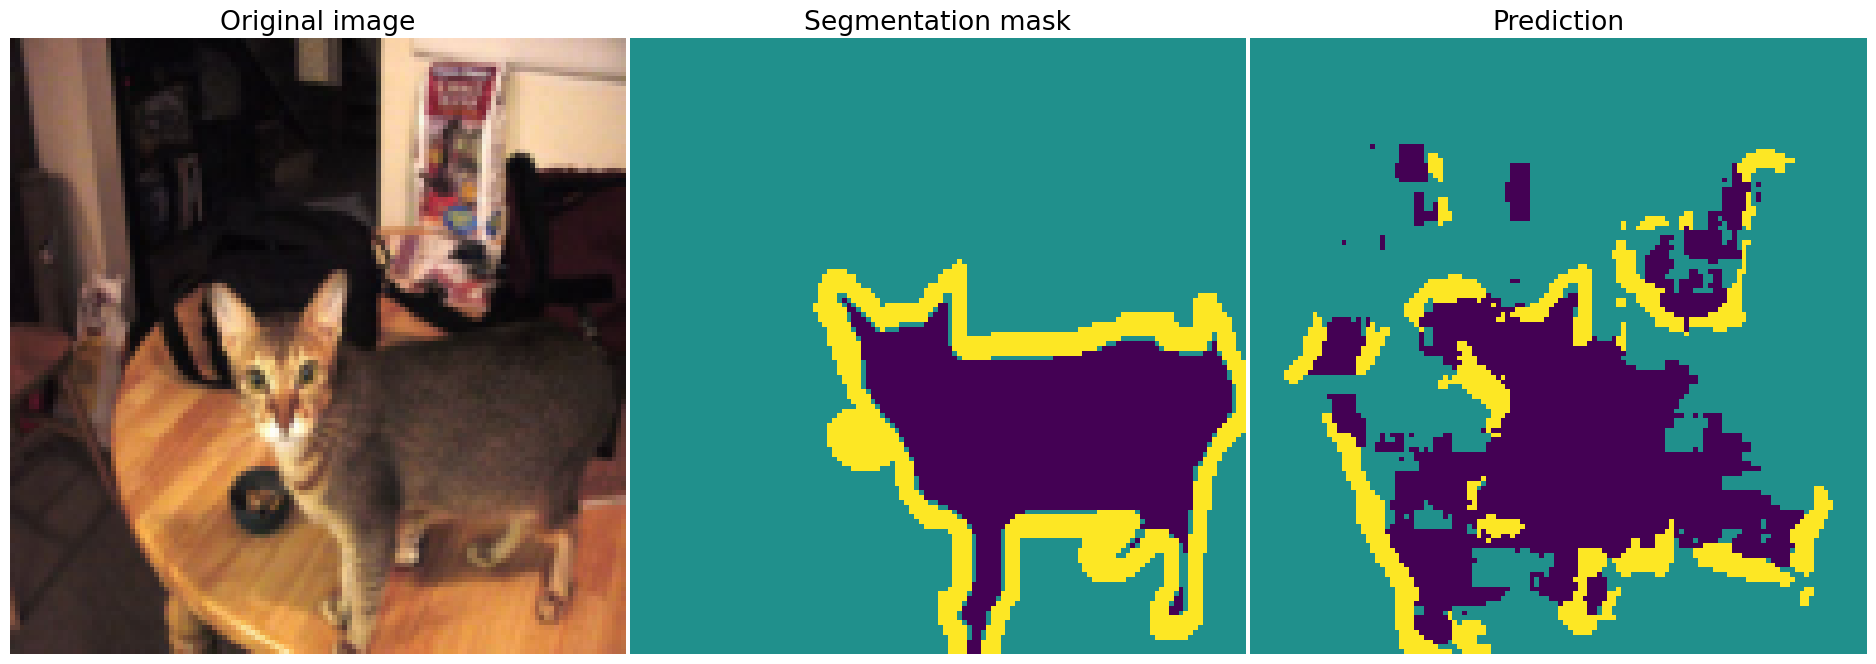

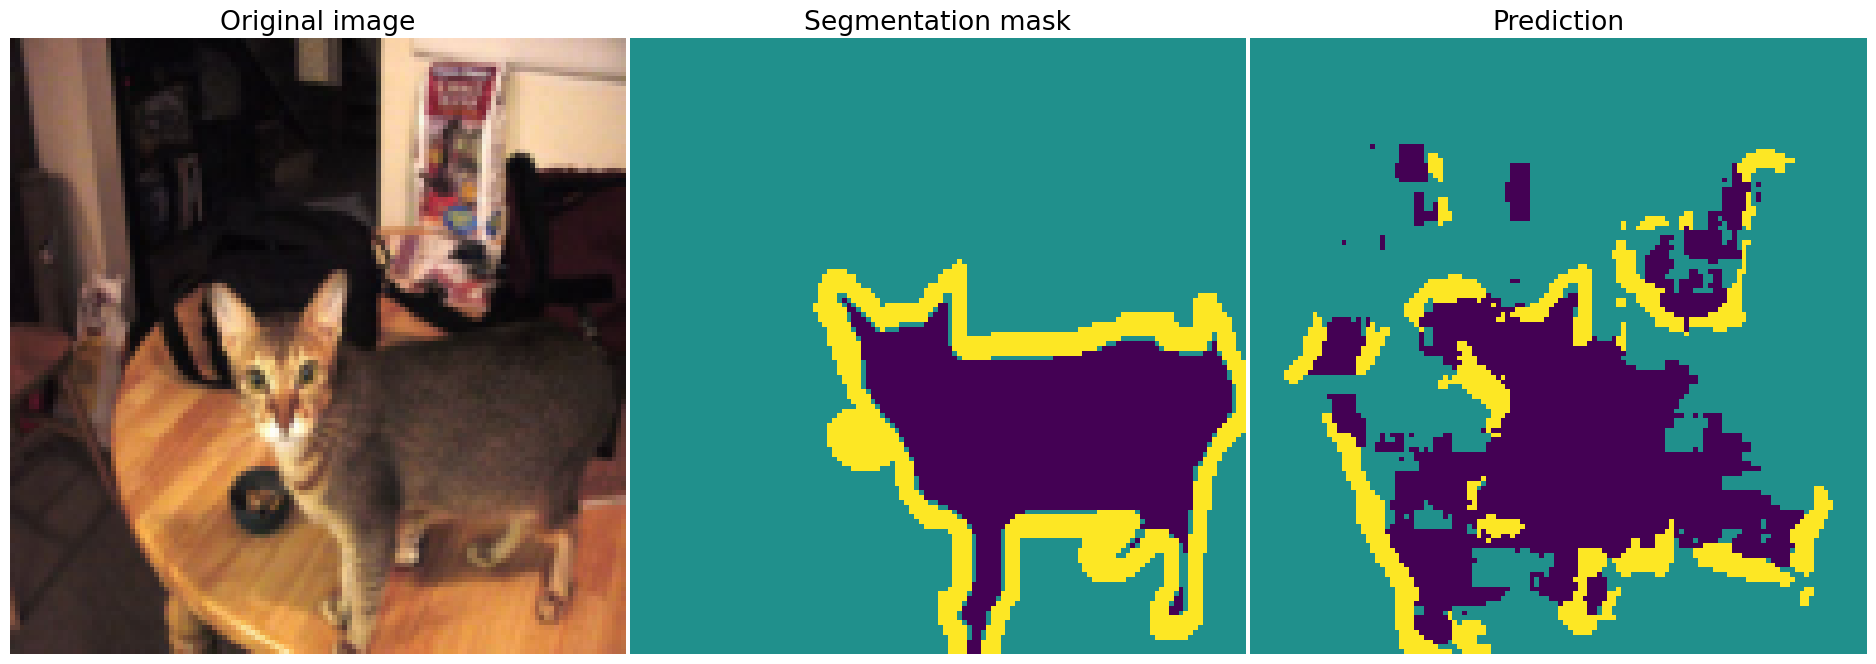

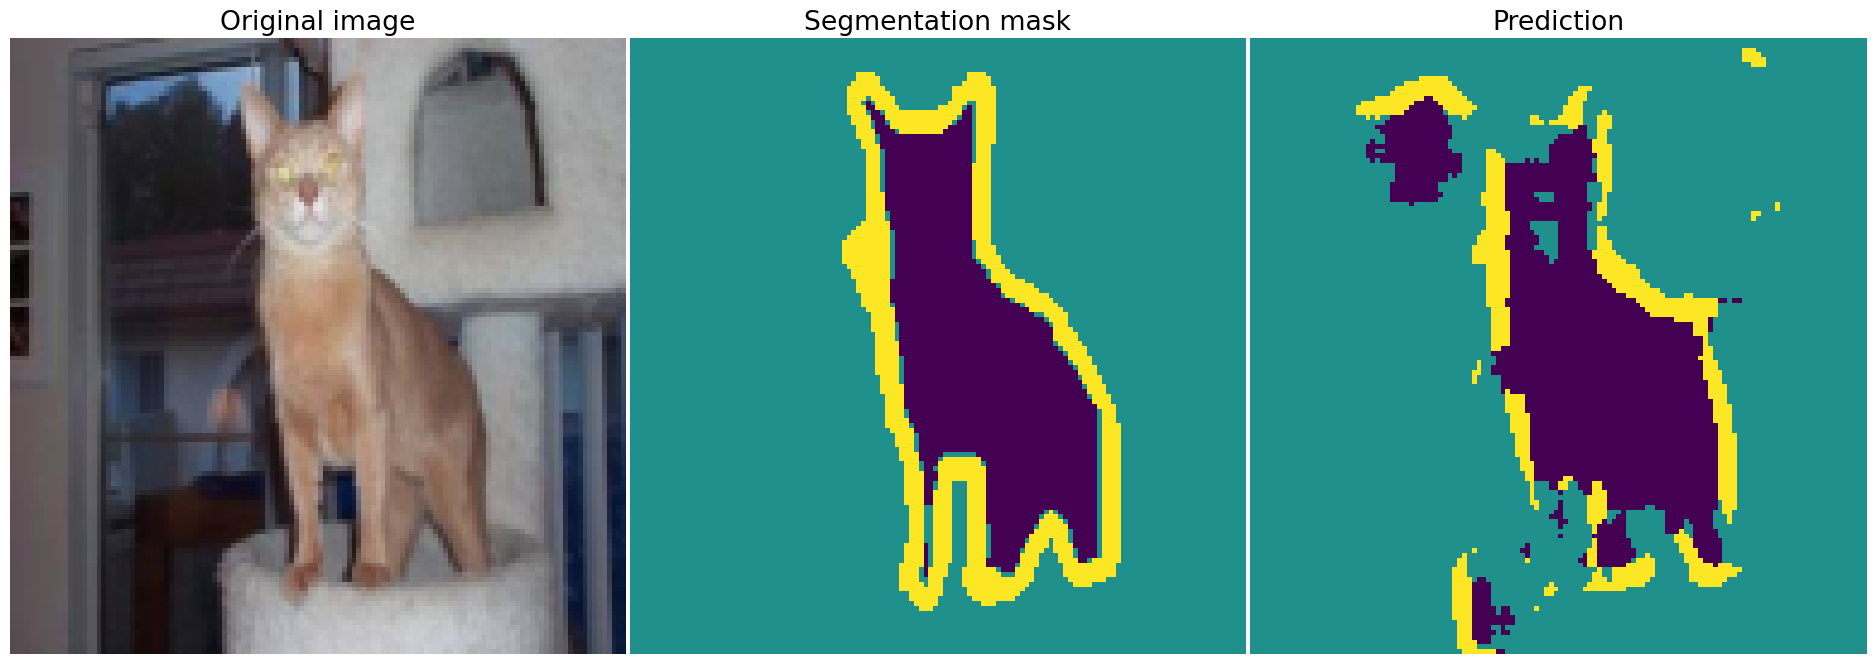

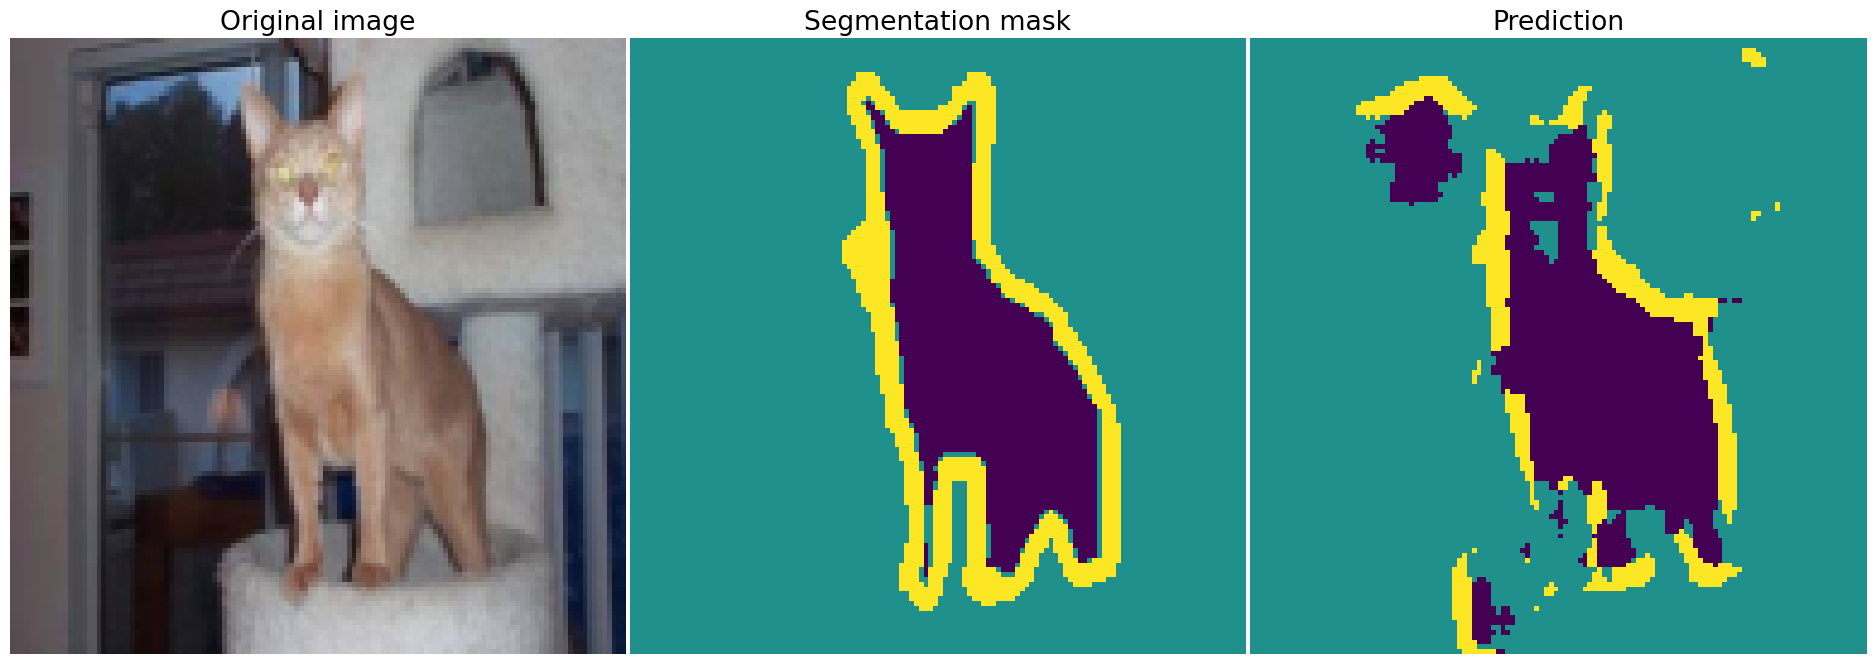

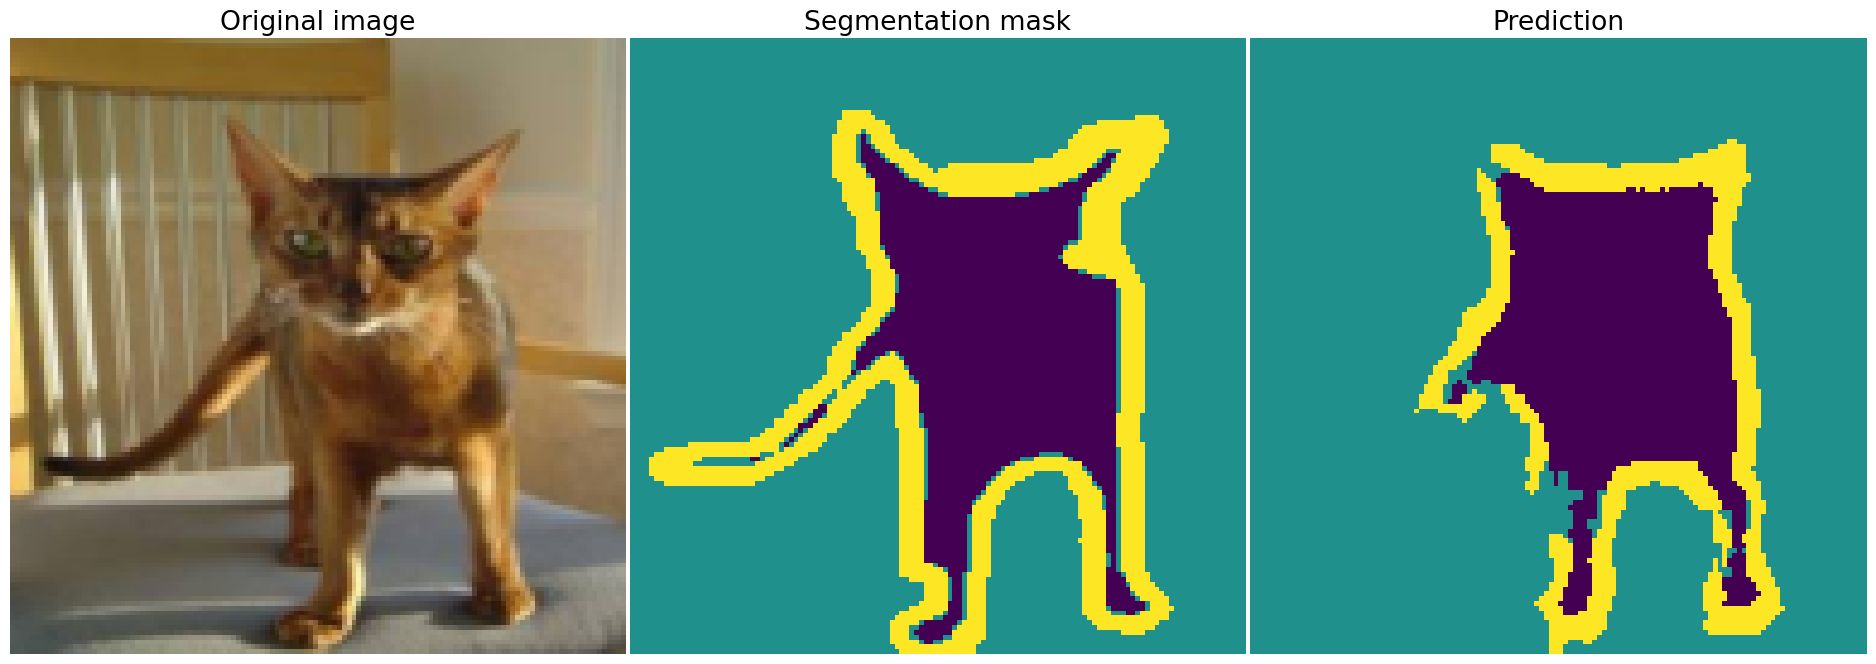

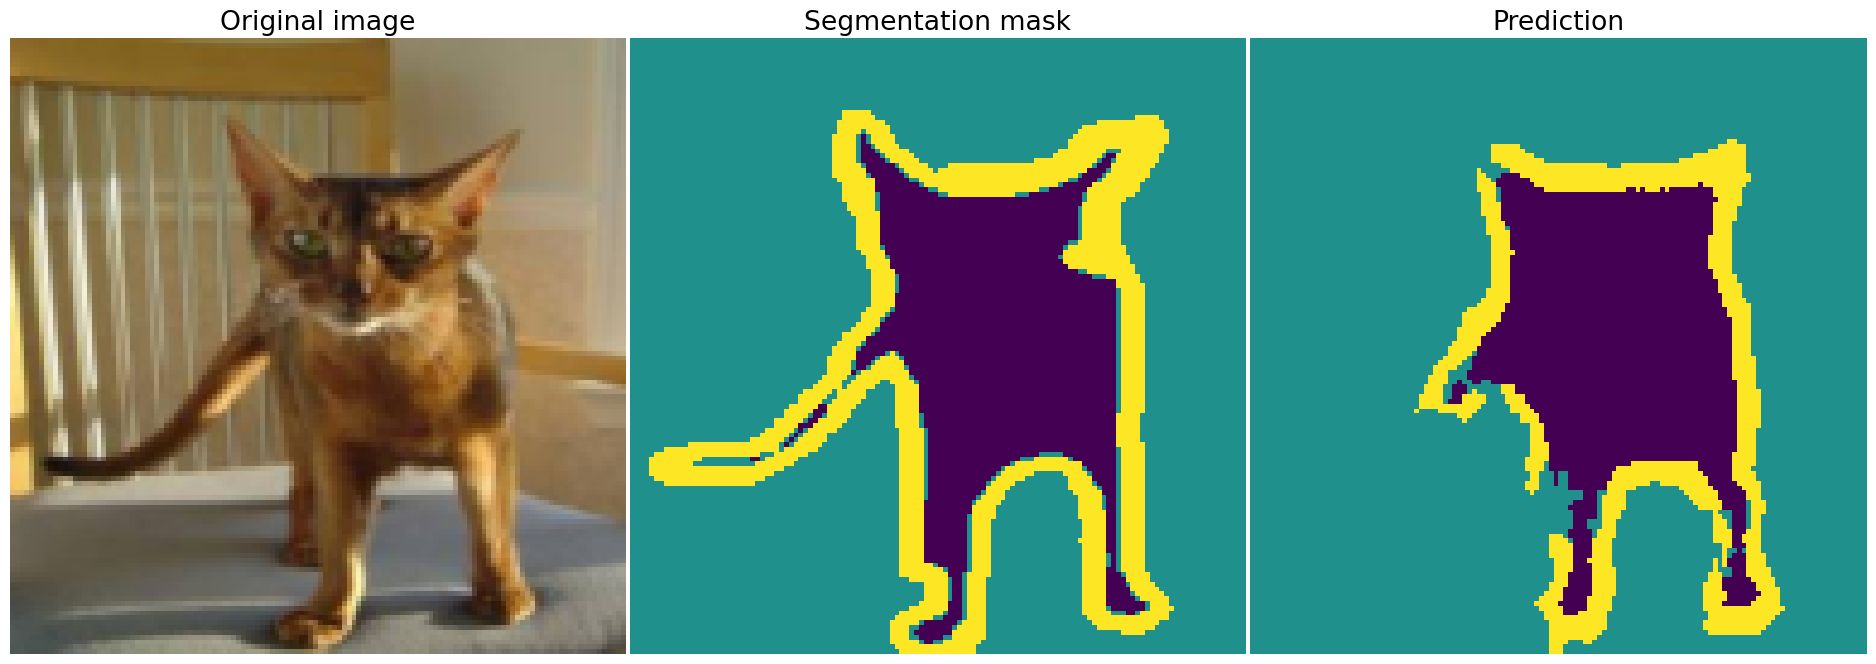

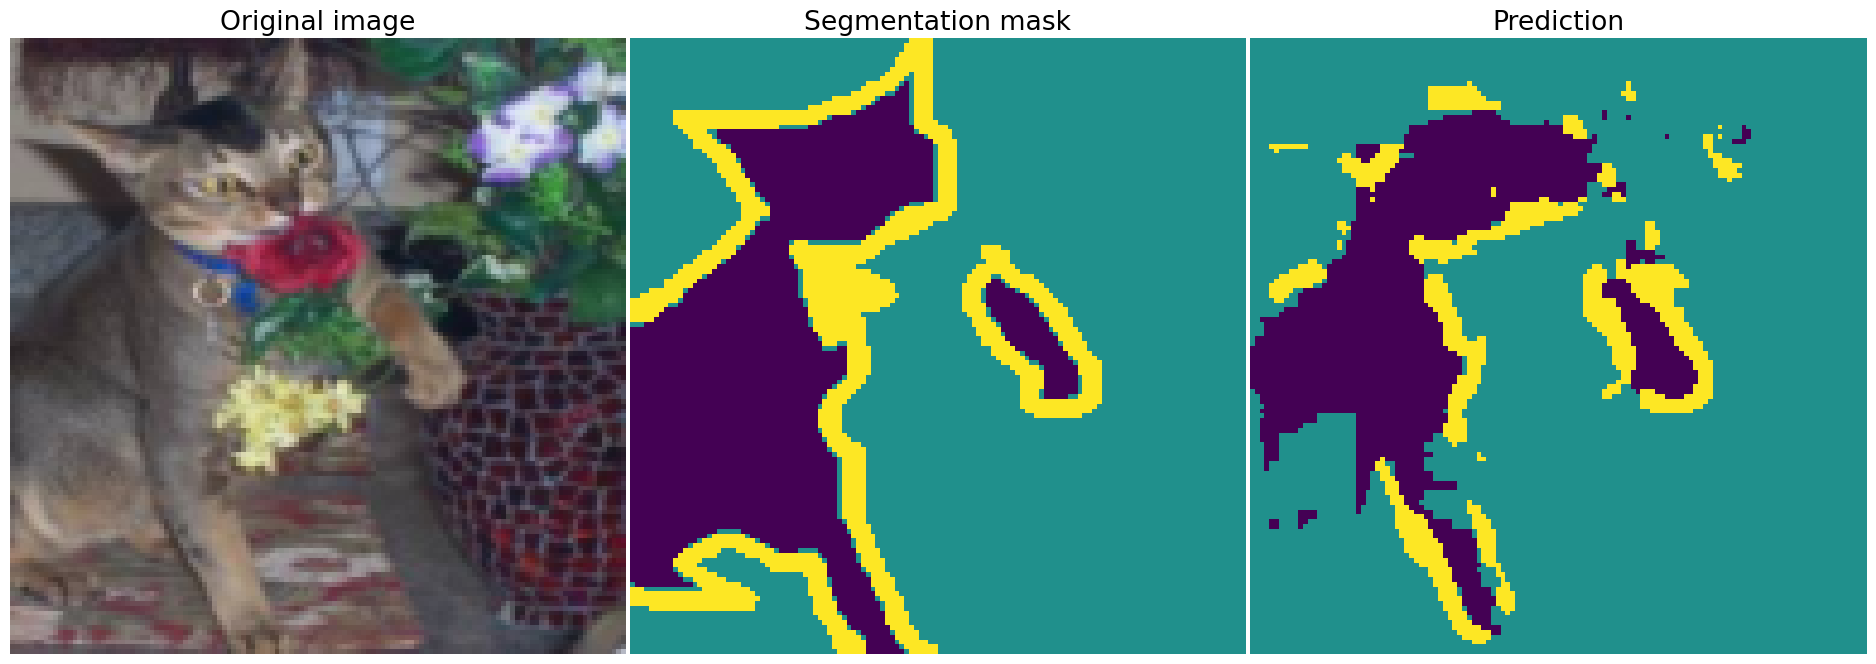

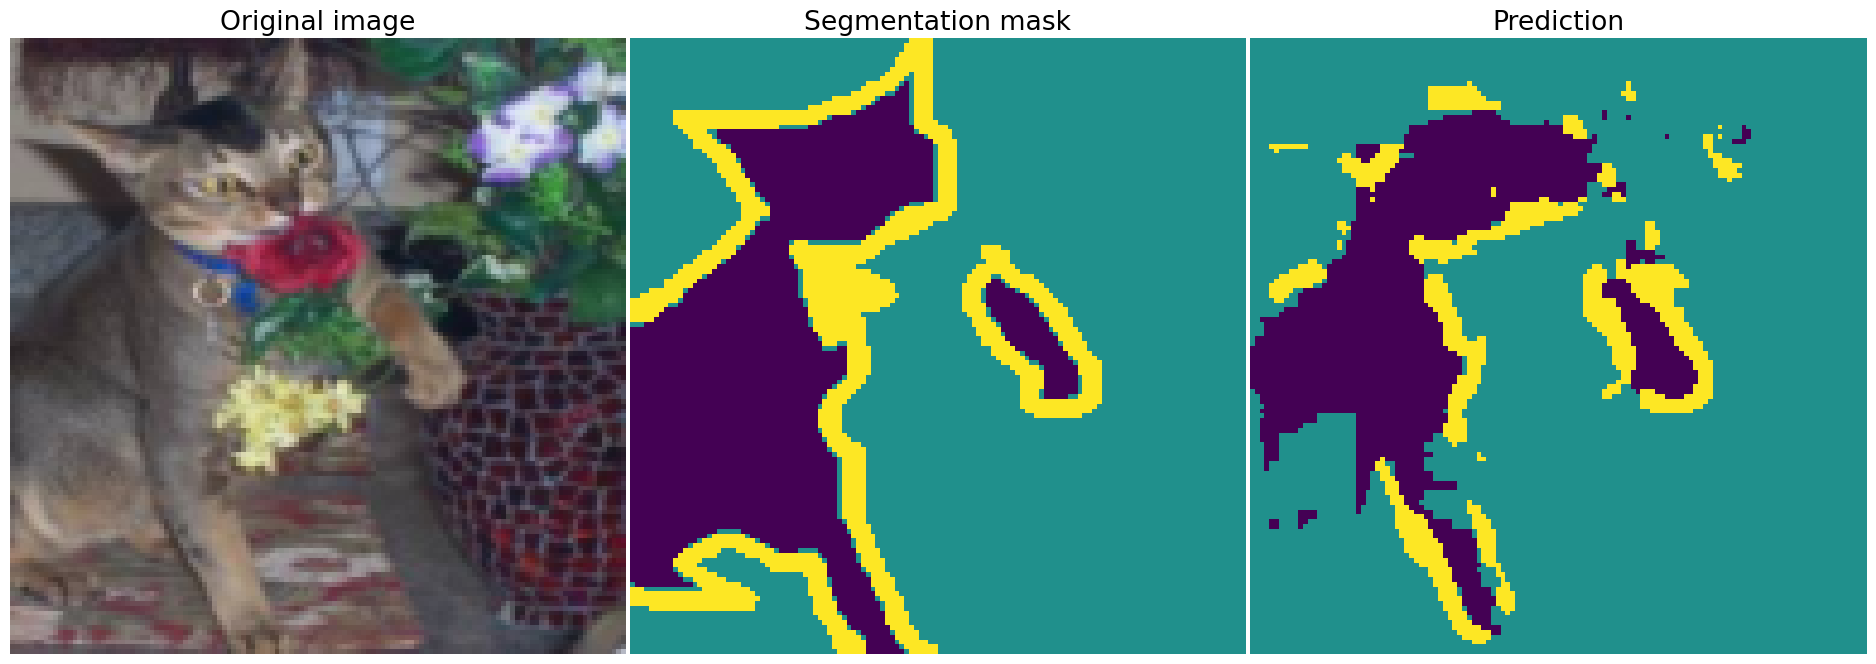

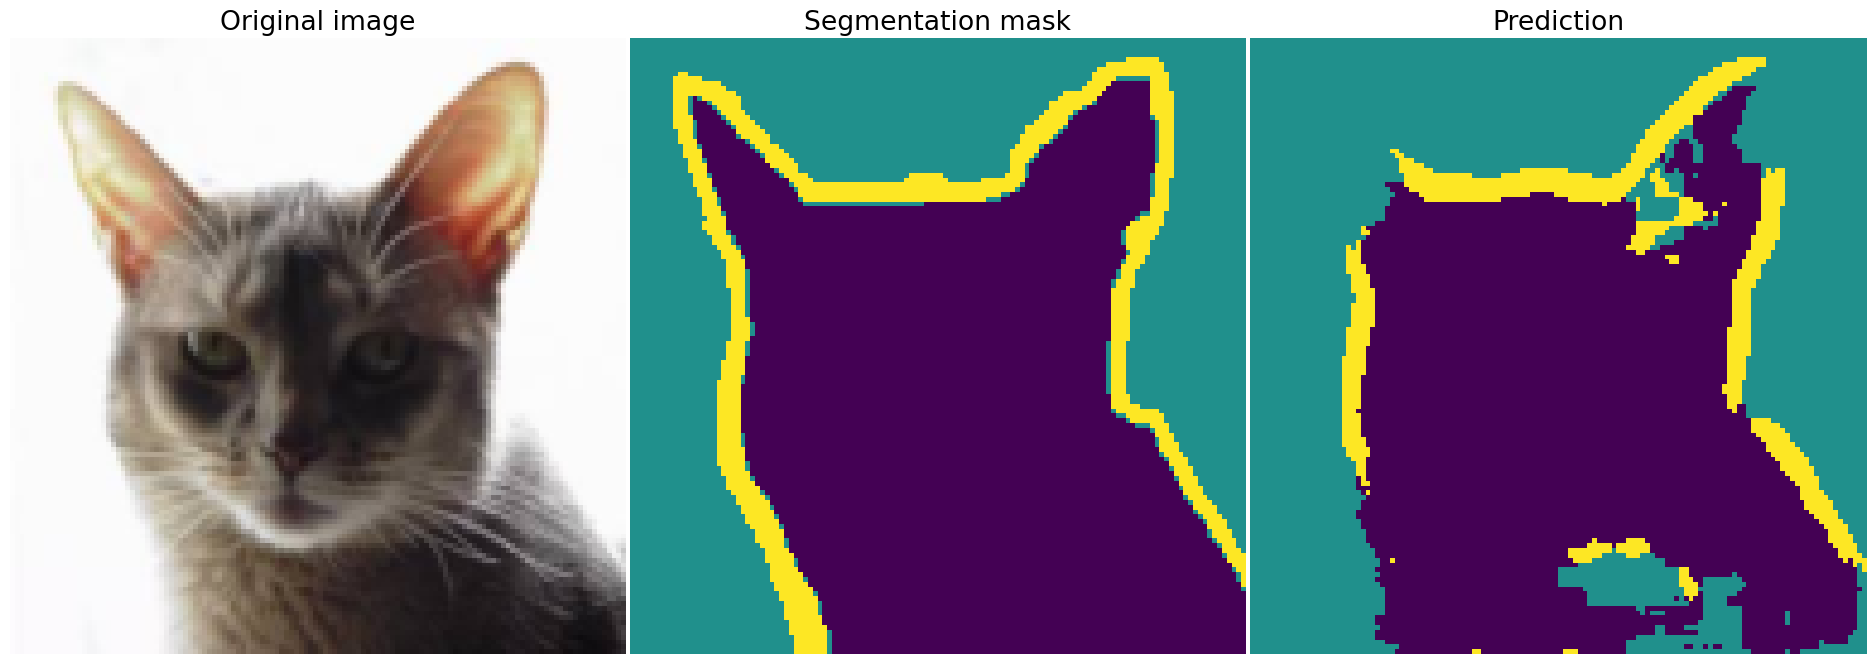

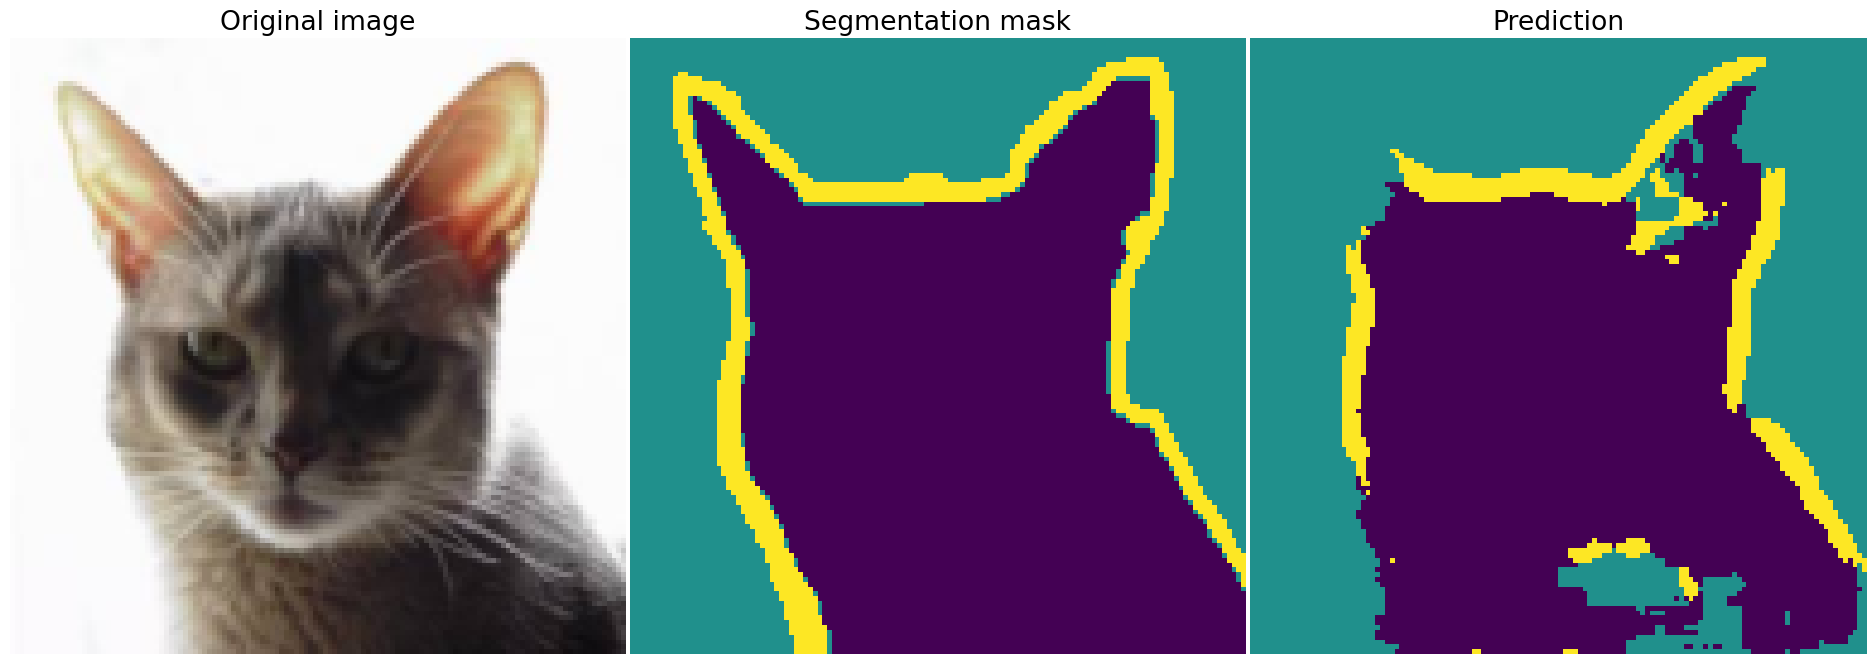

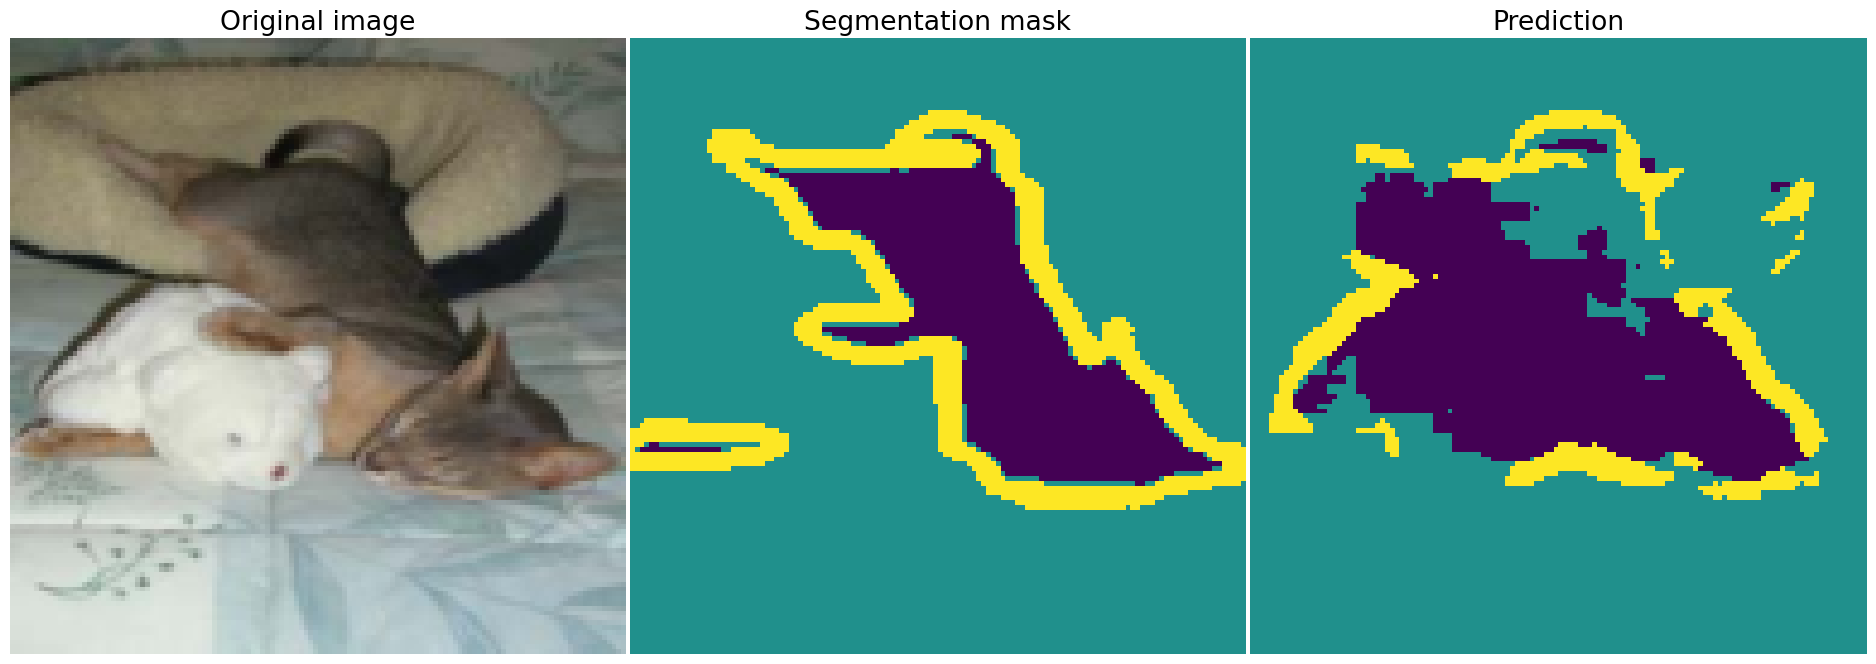

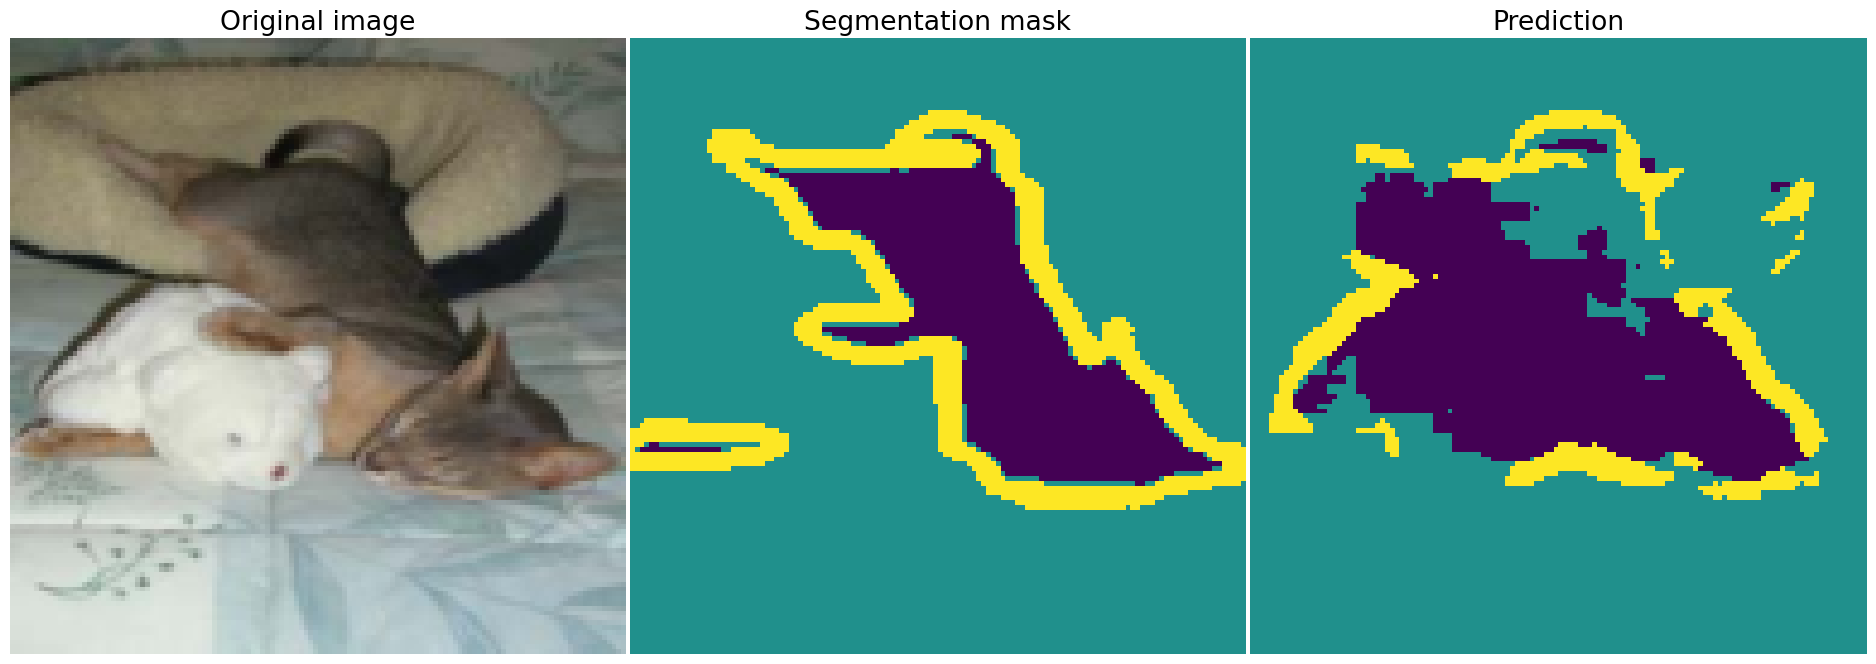

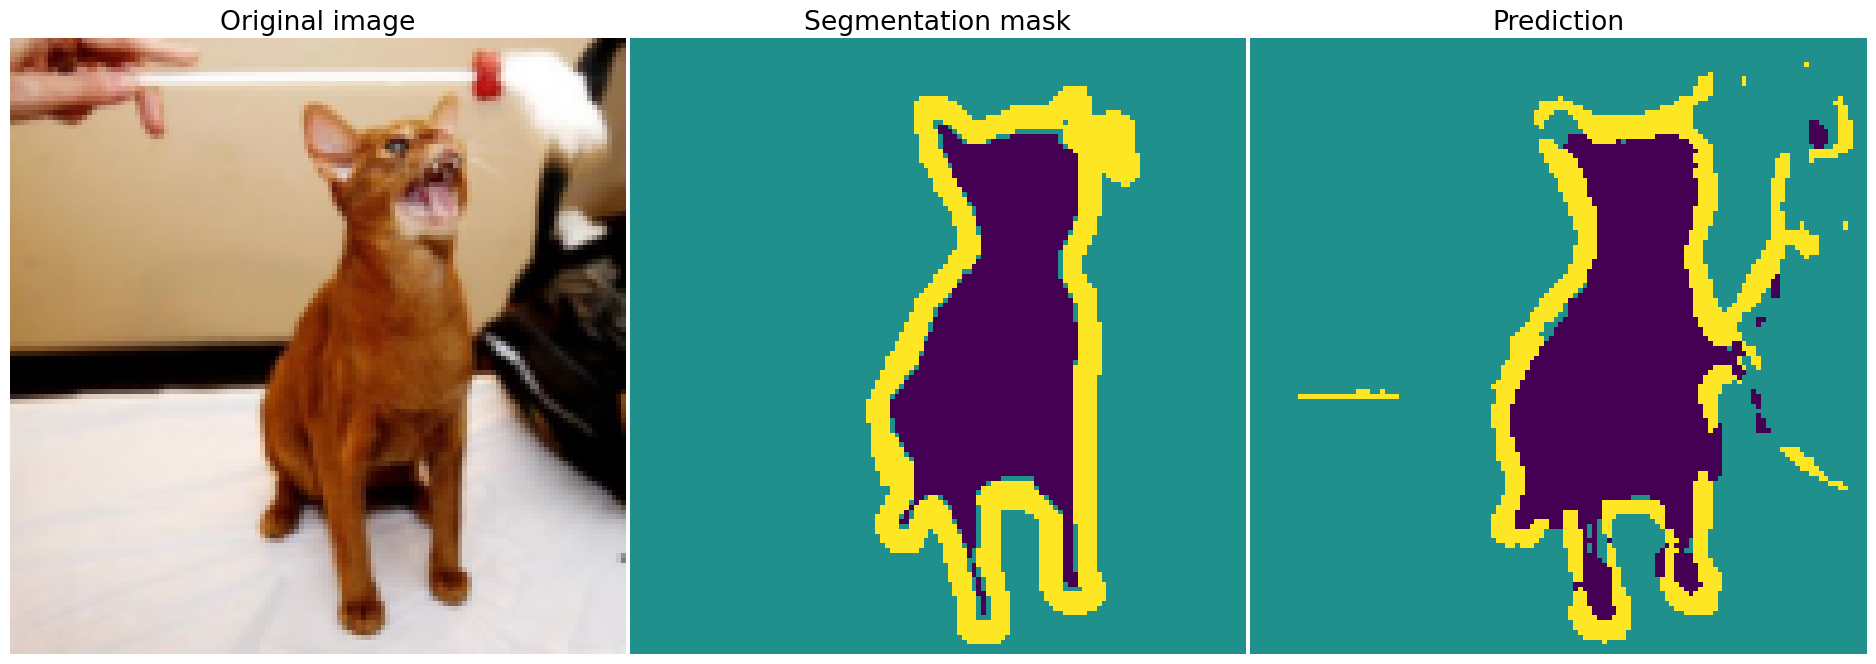

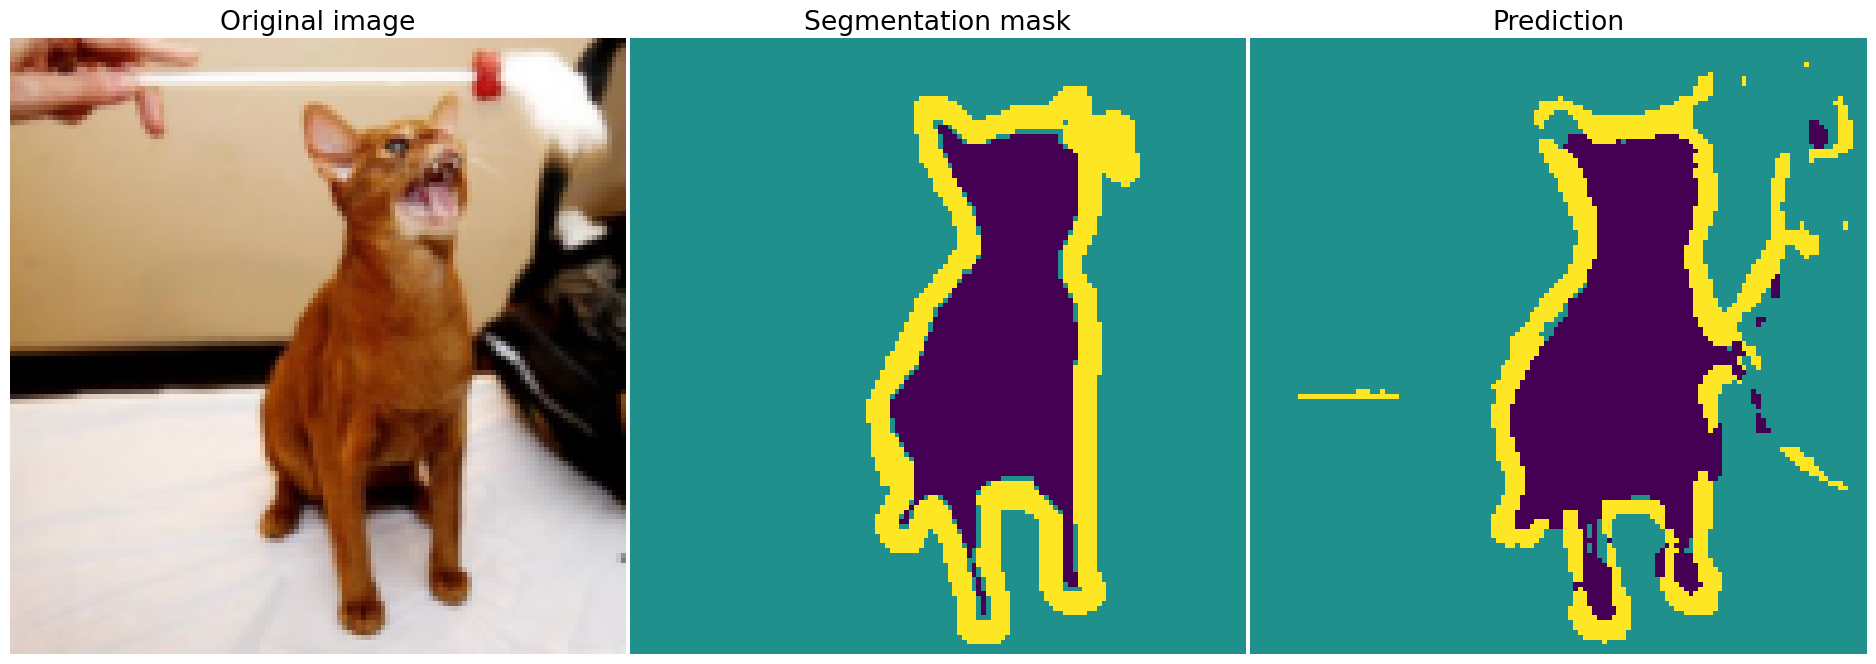

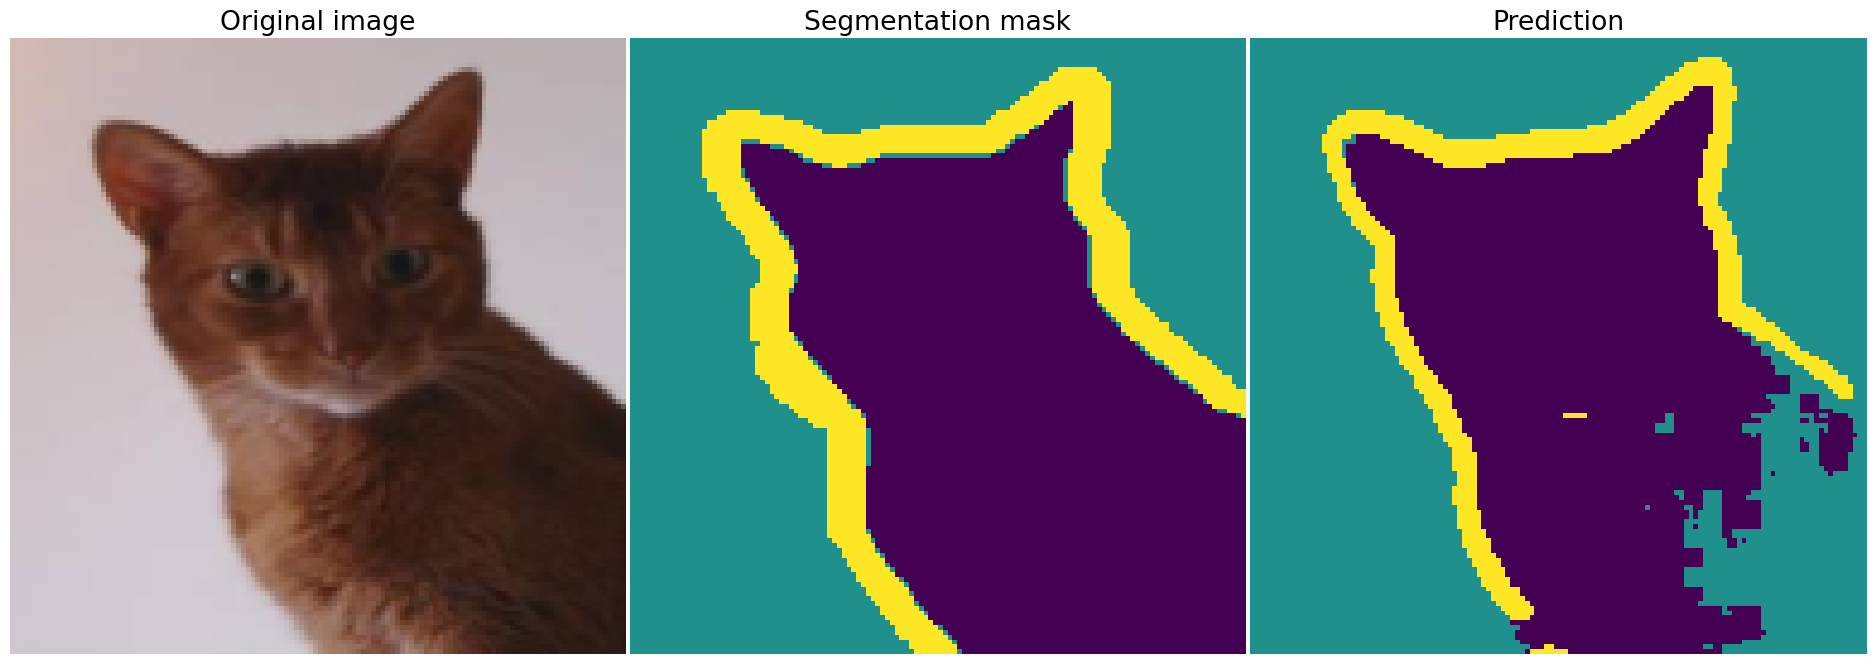

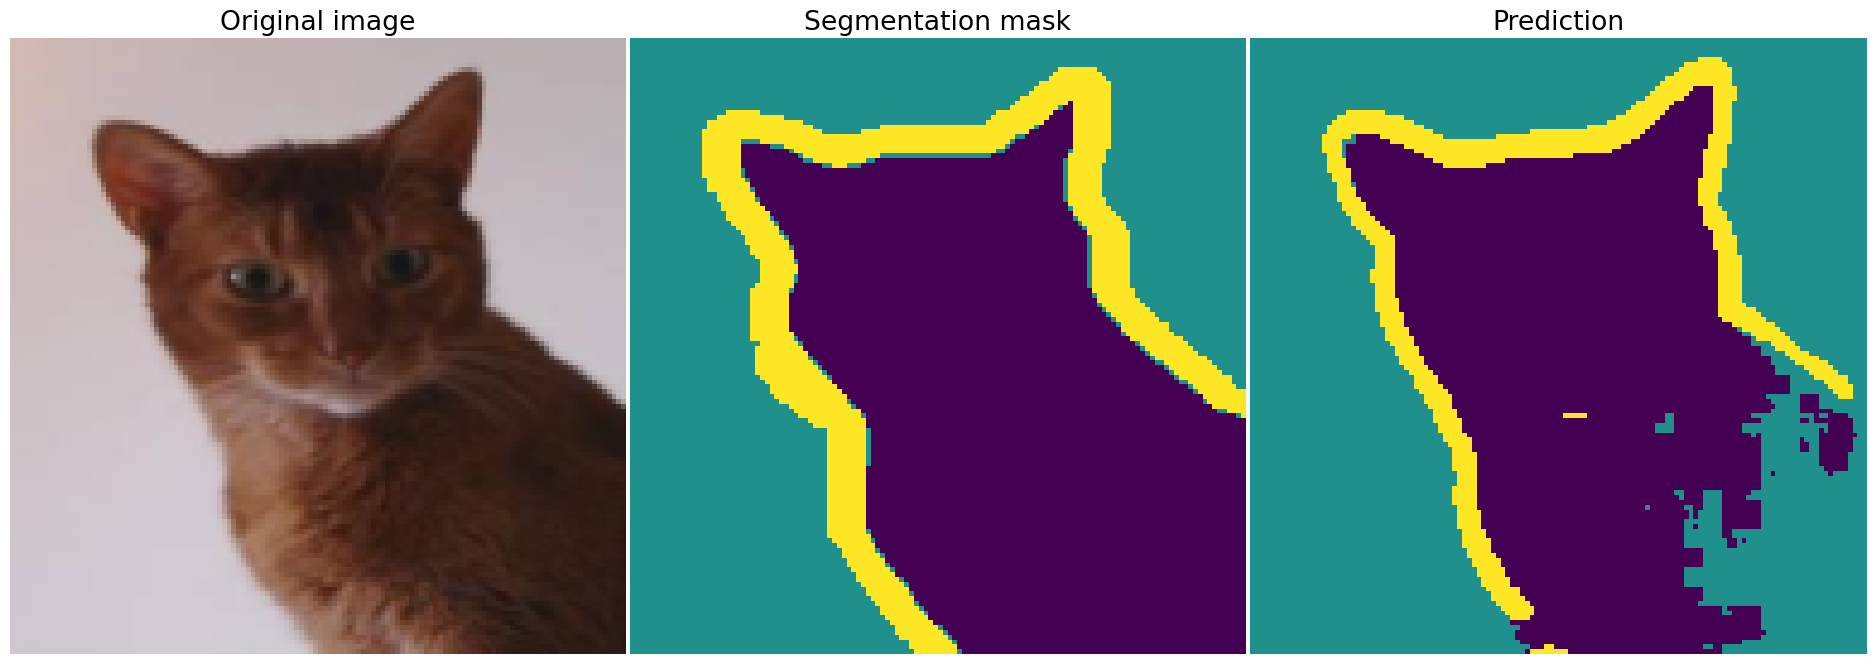

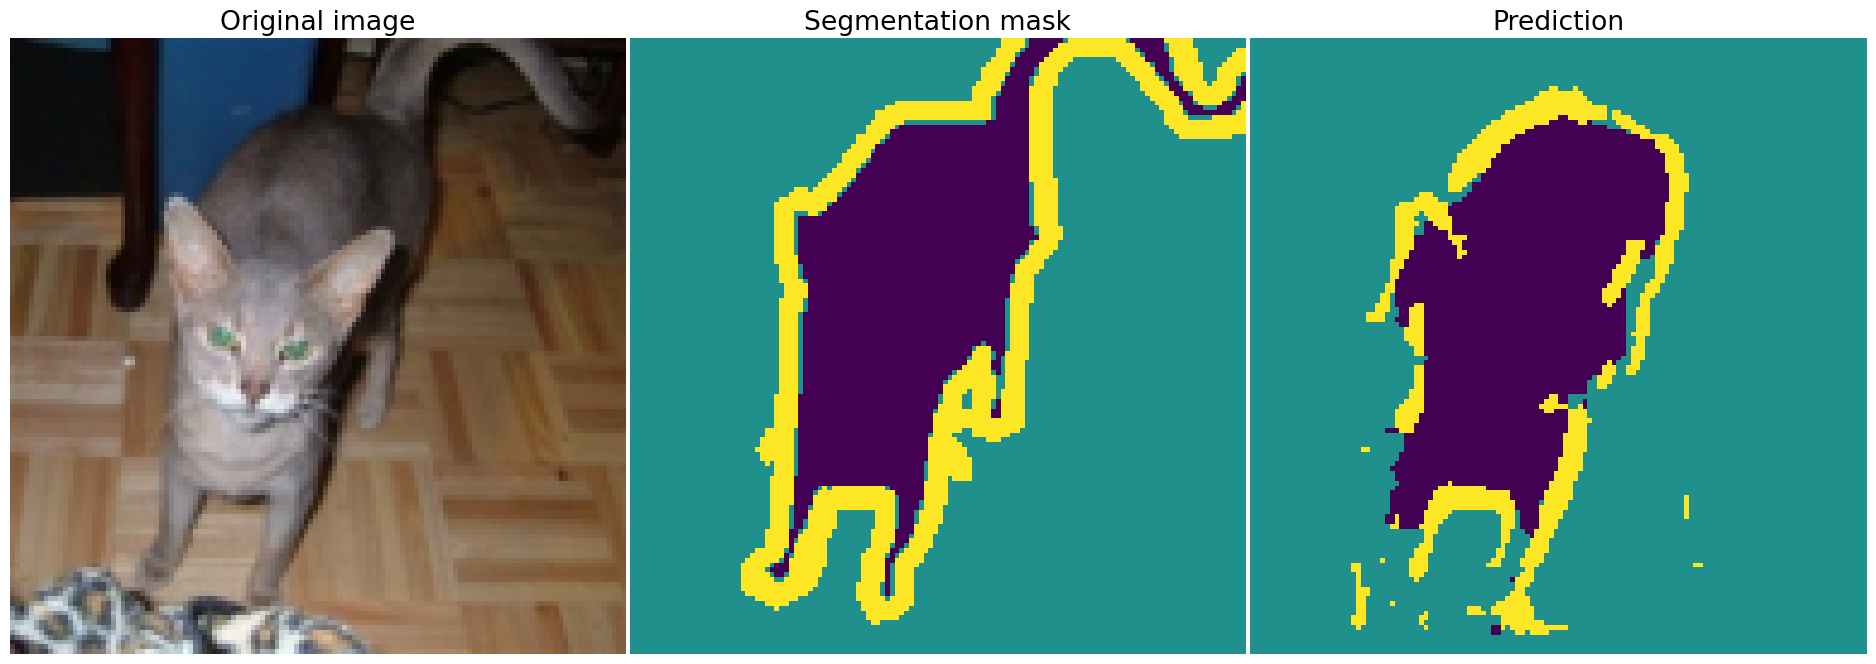

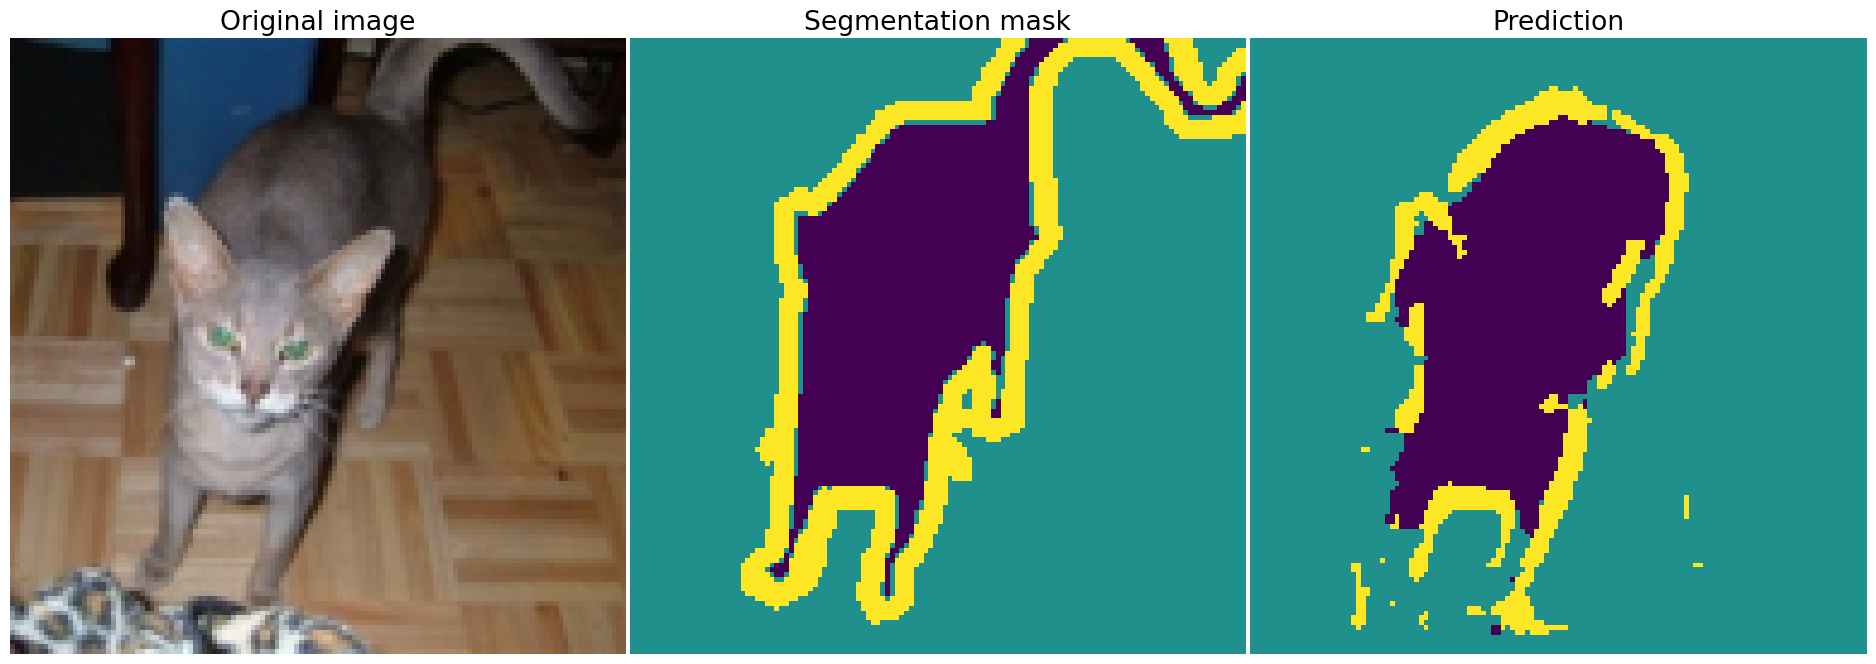

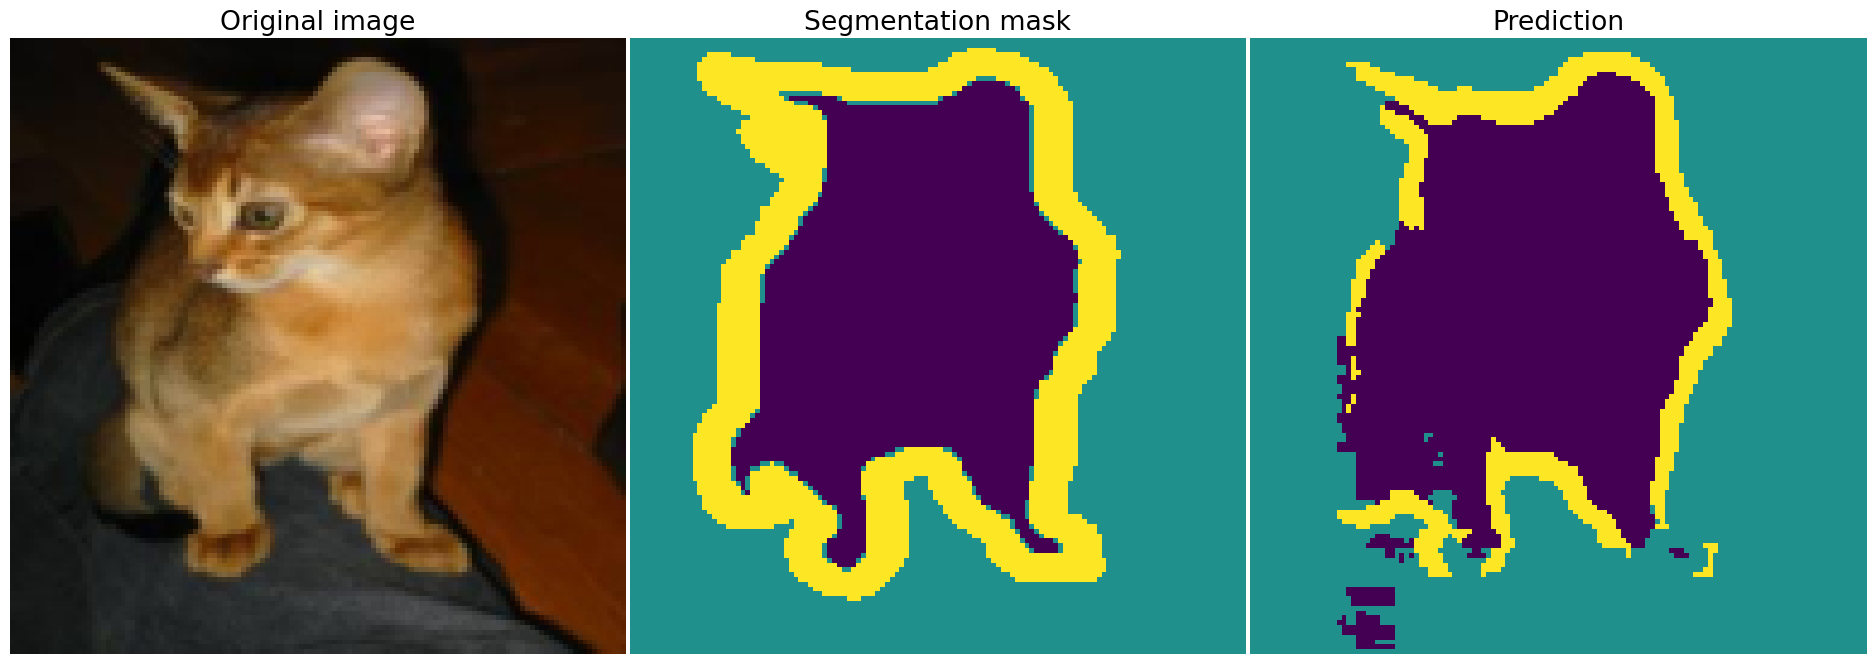

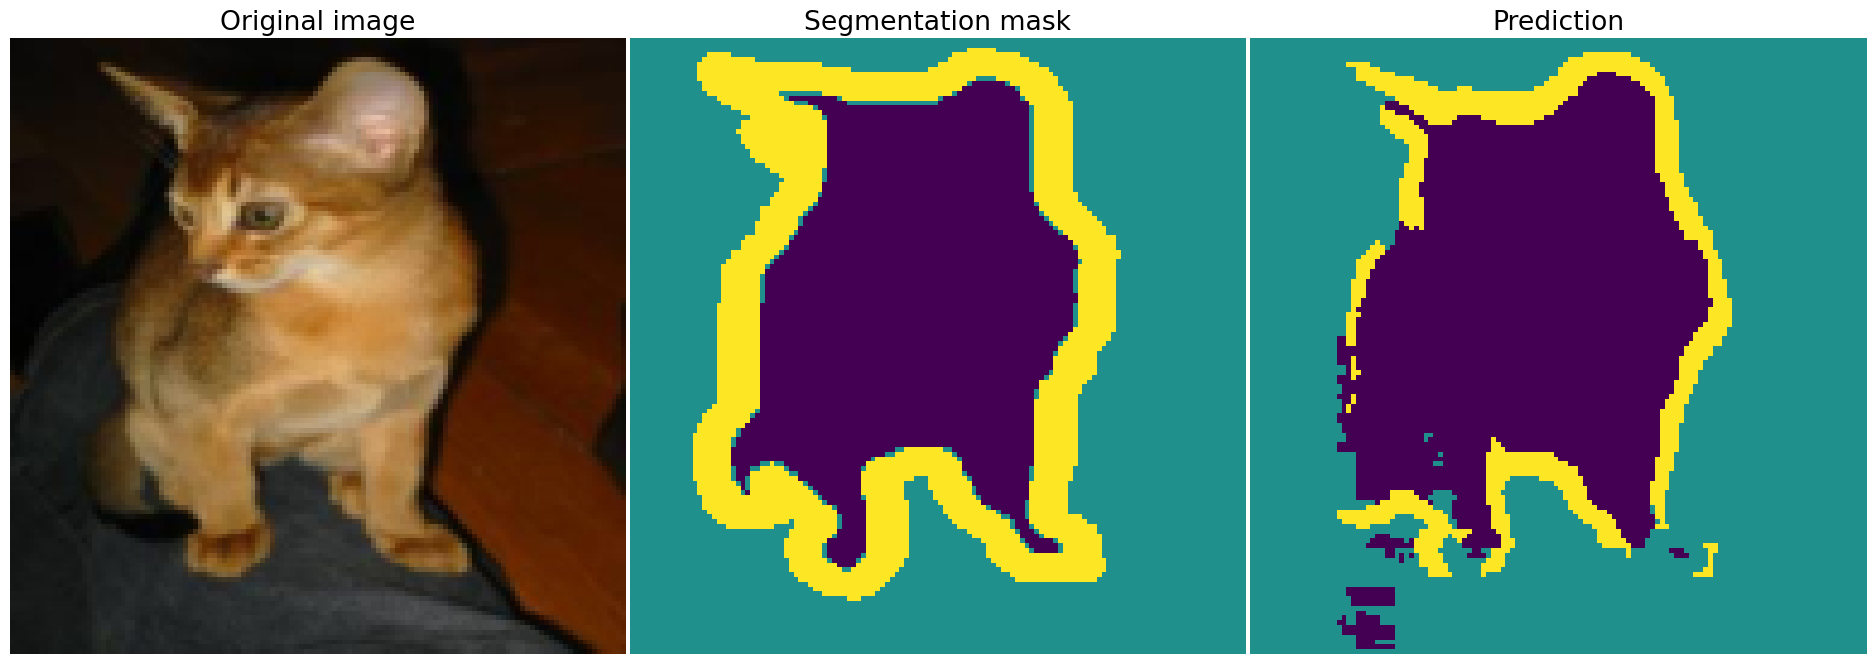

In [ ]:
visualize(model, next(iter(valid_loader)))

In [ ]:
visualize(model, next(iter(valid_loader)))

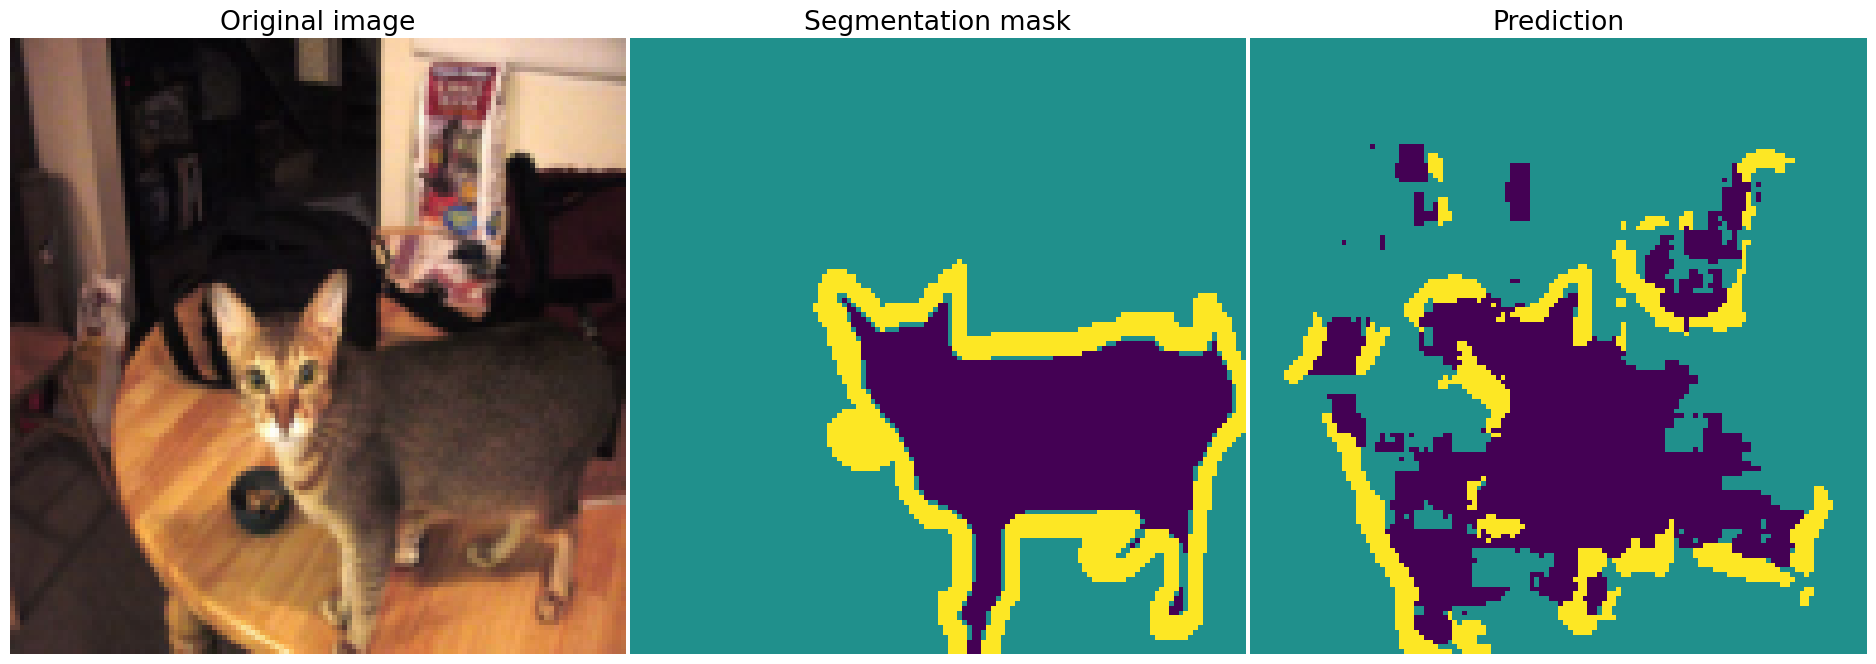

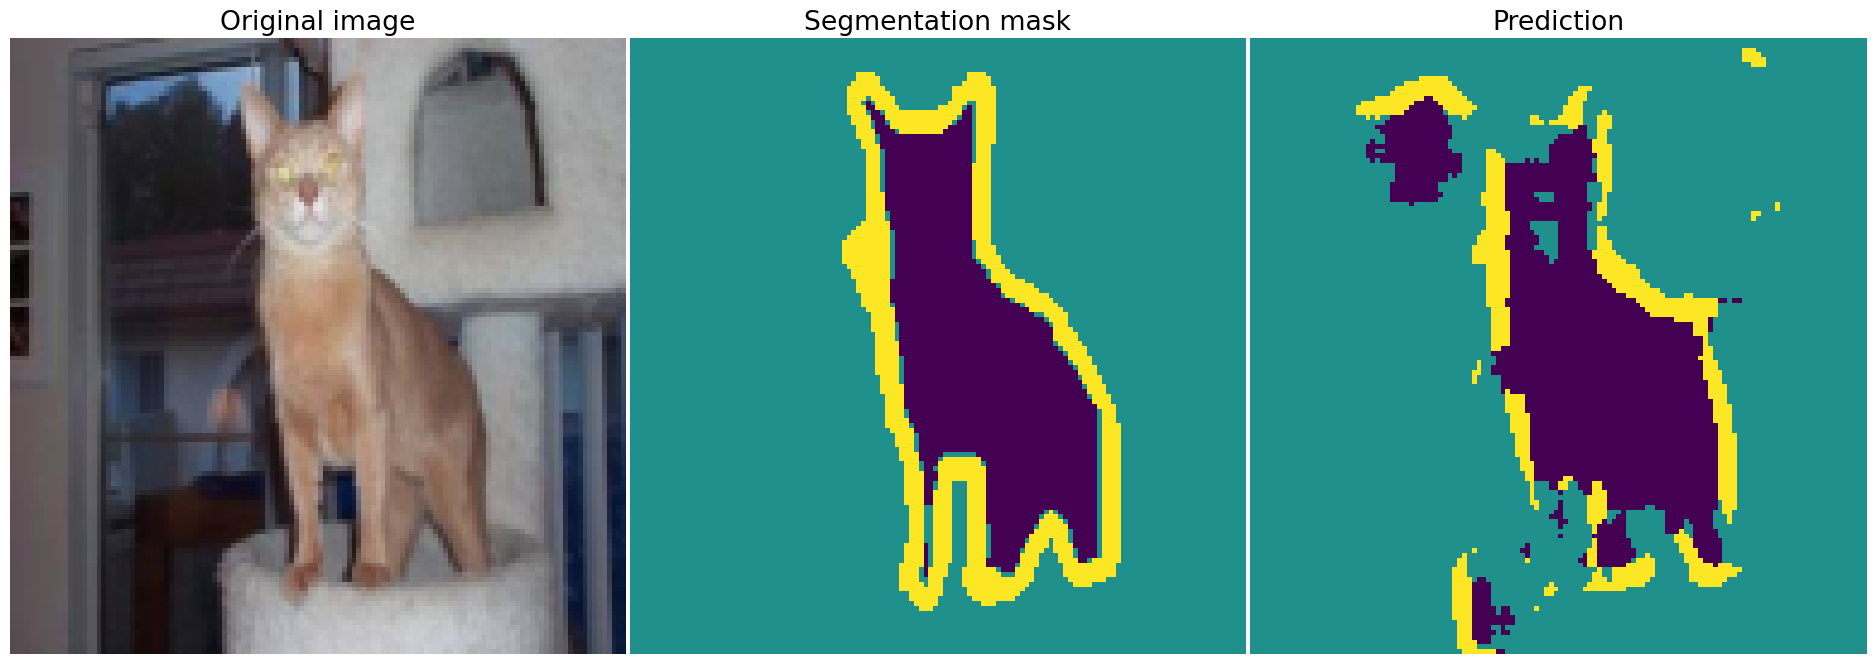

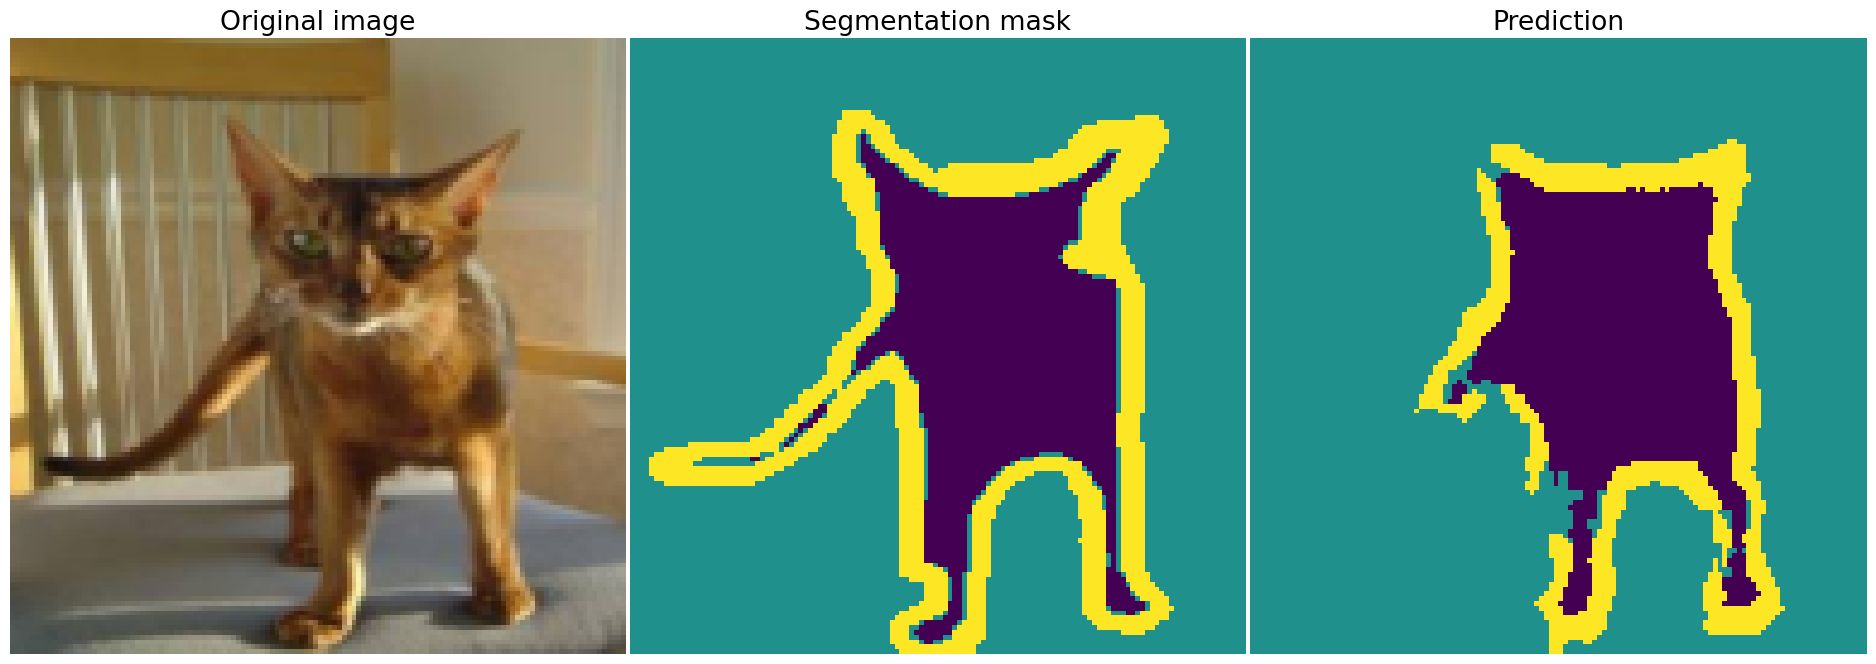

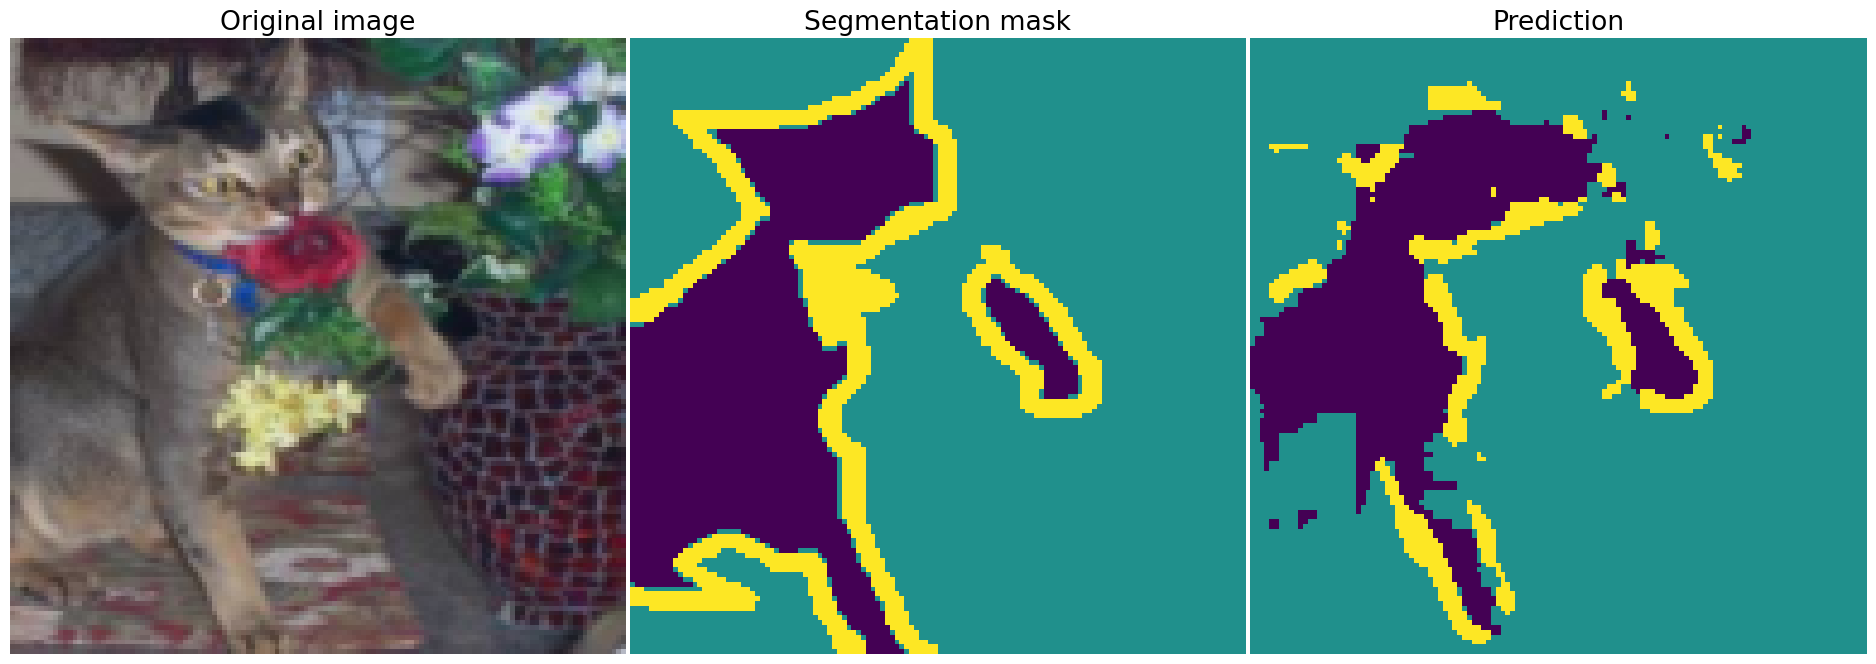

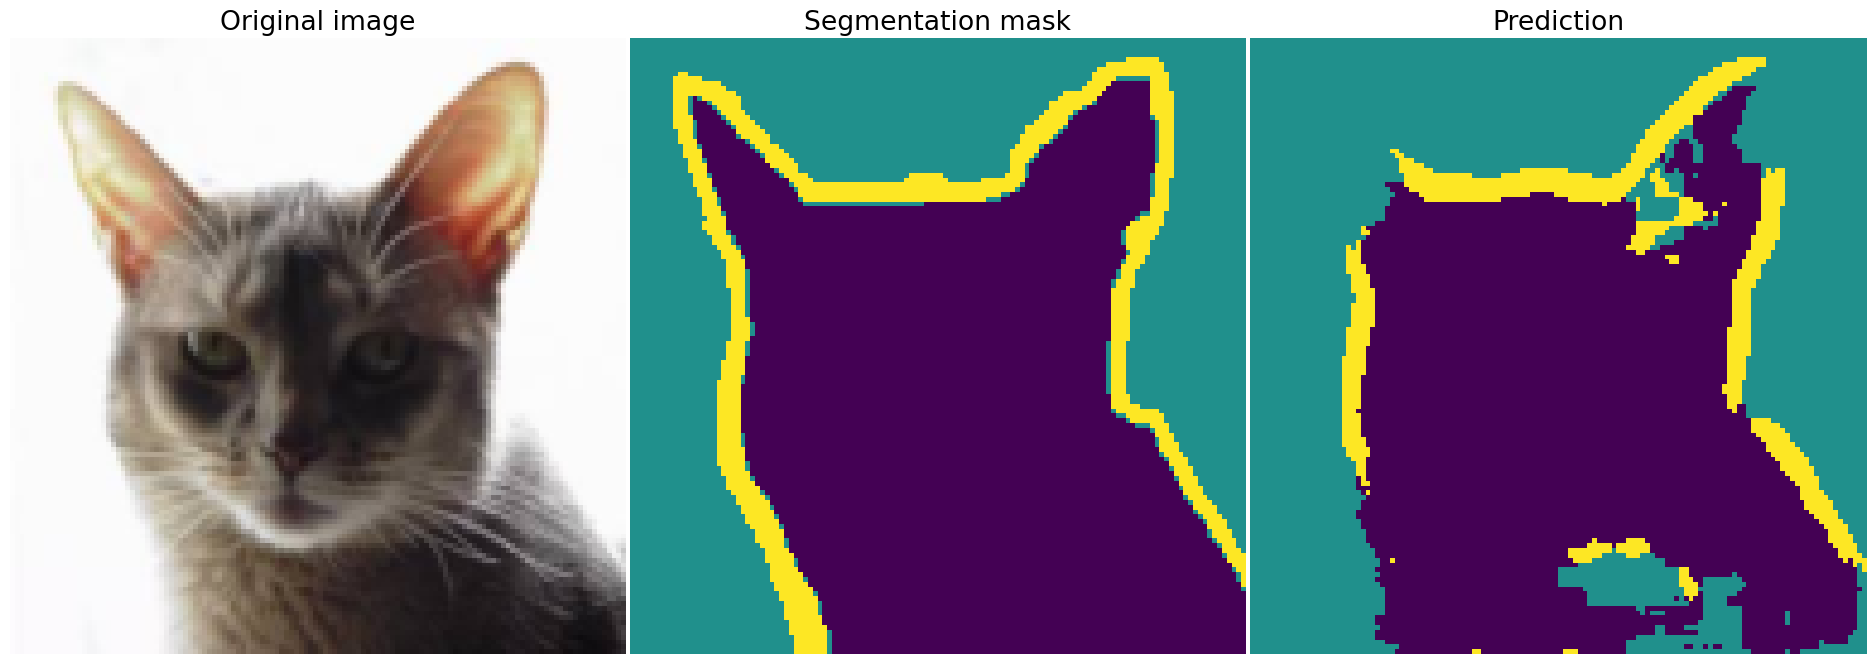

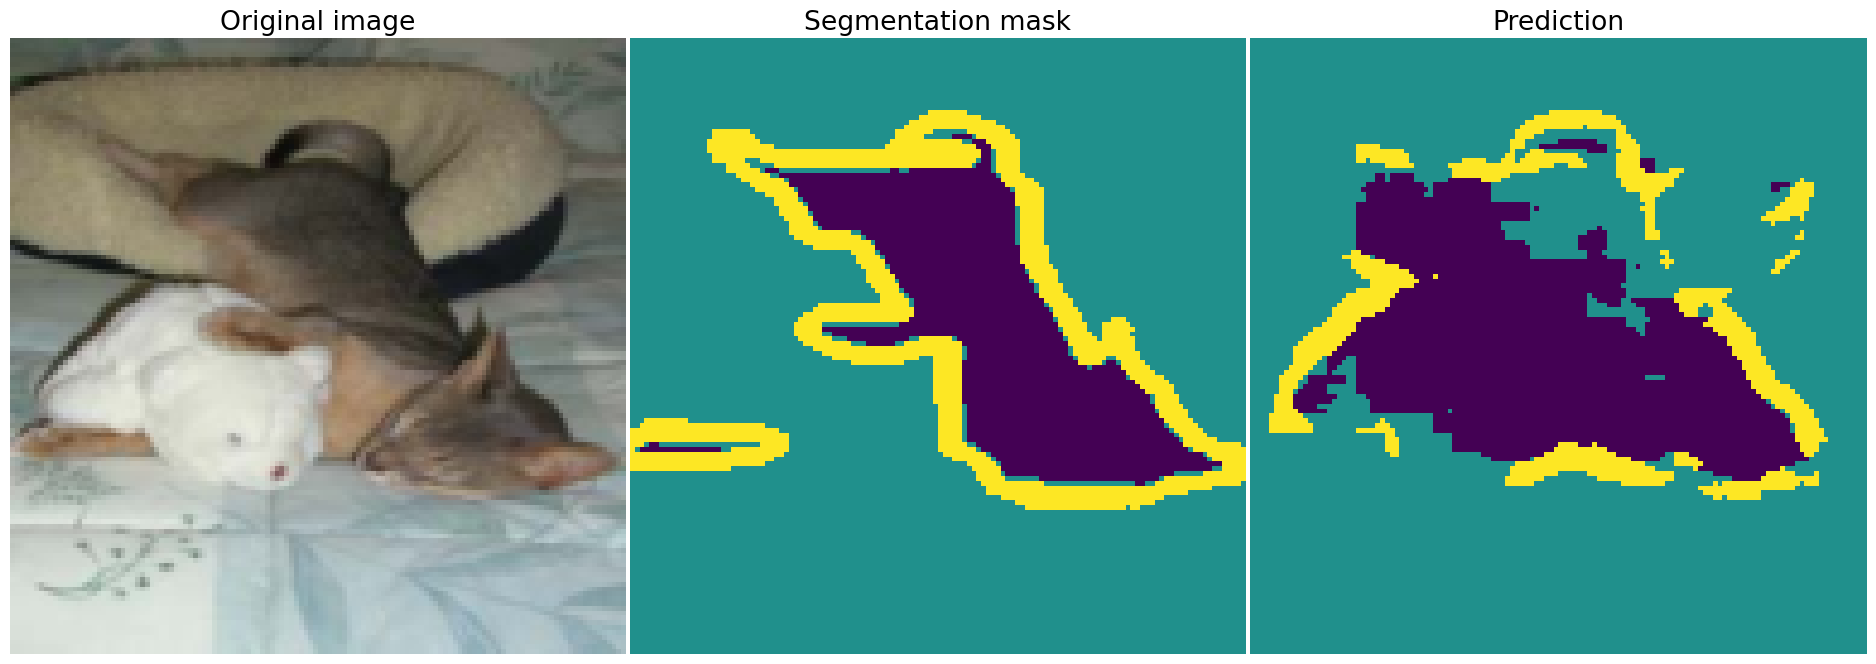

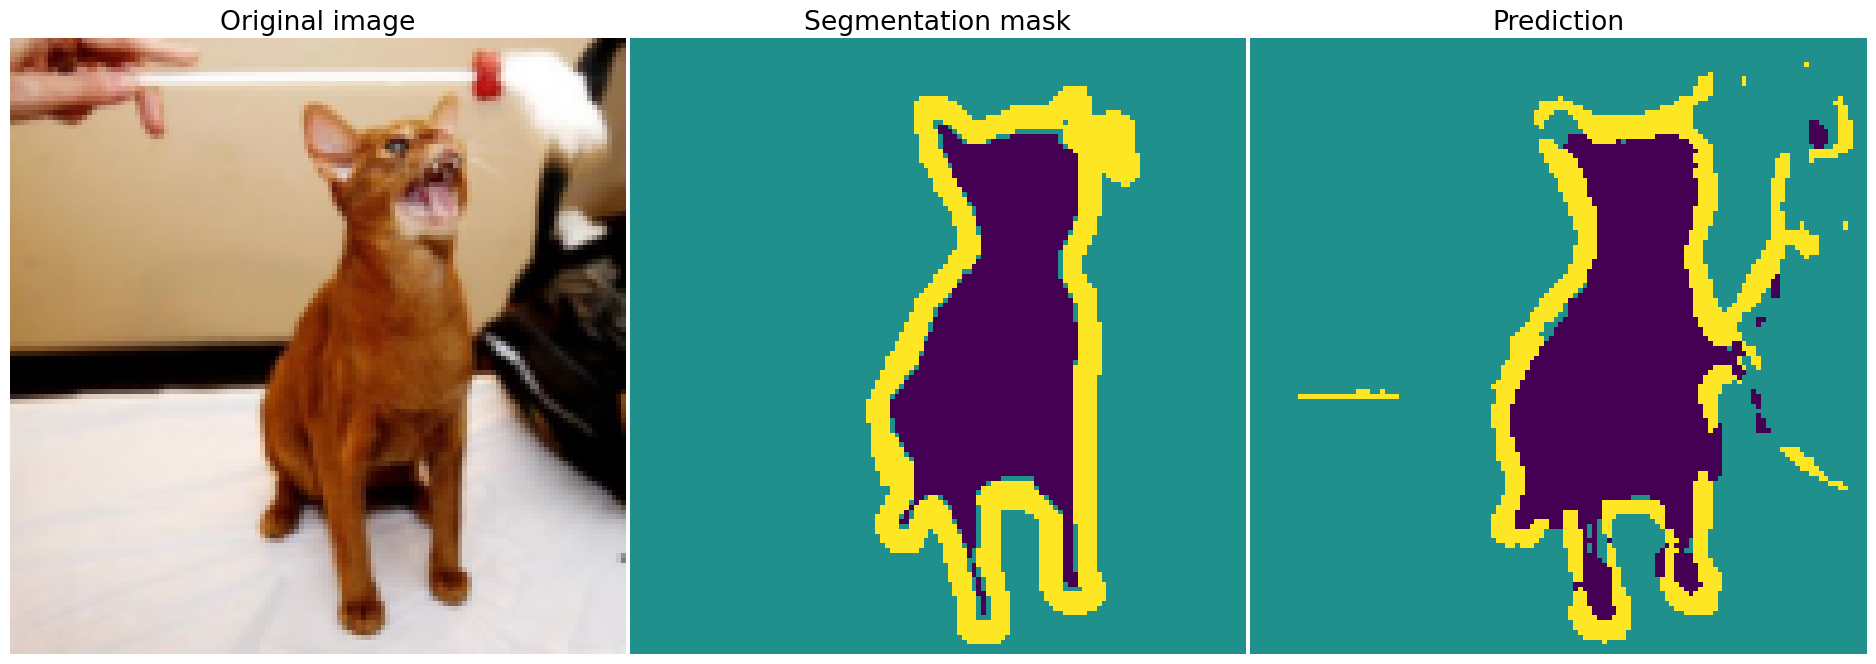

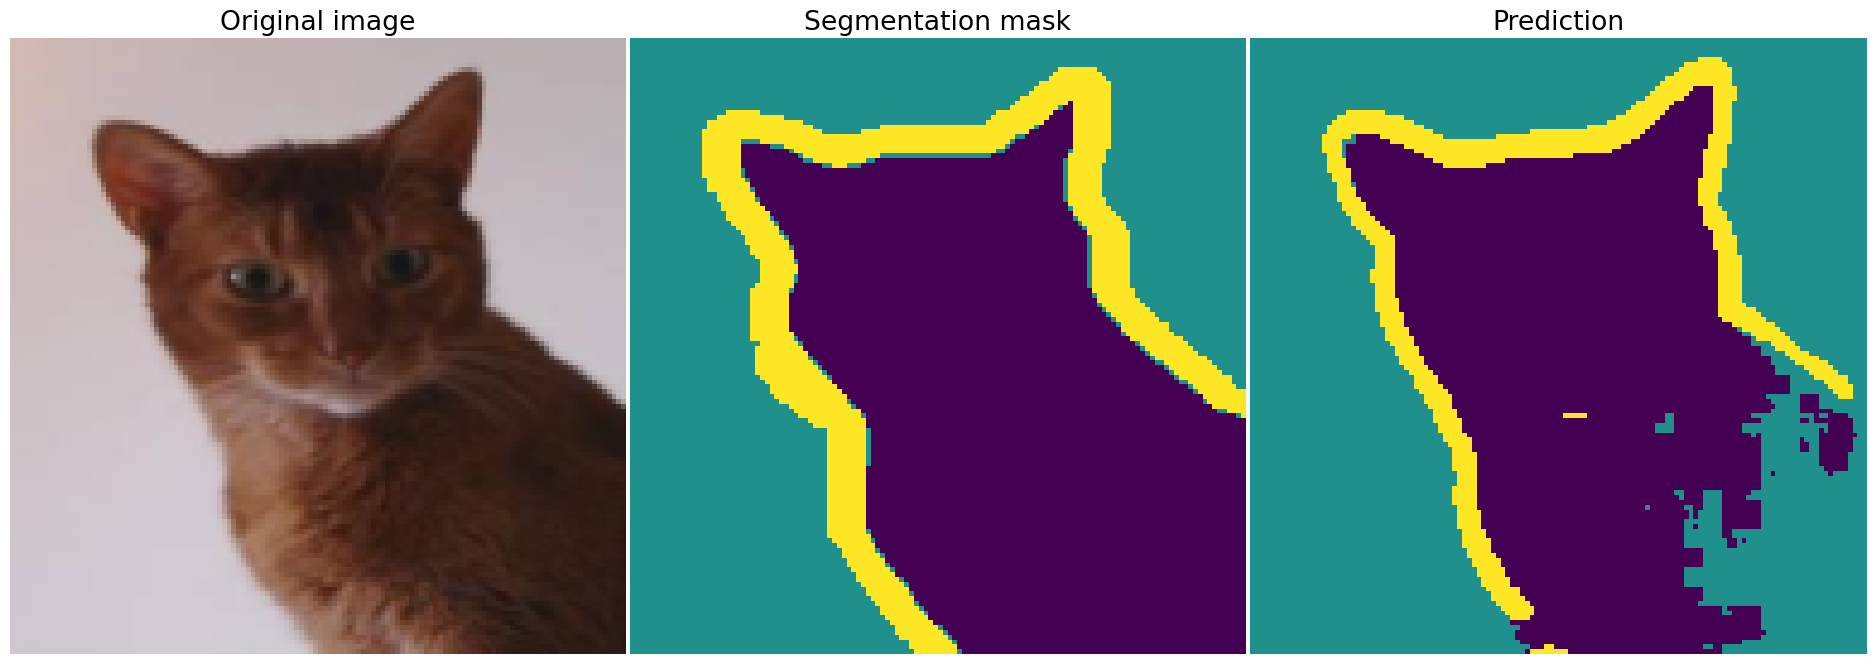

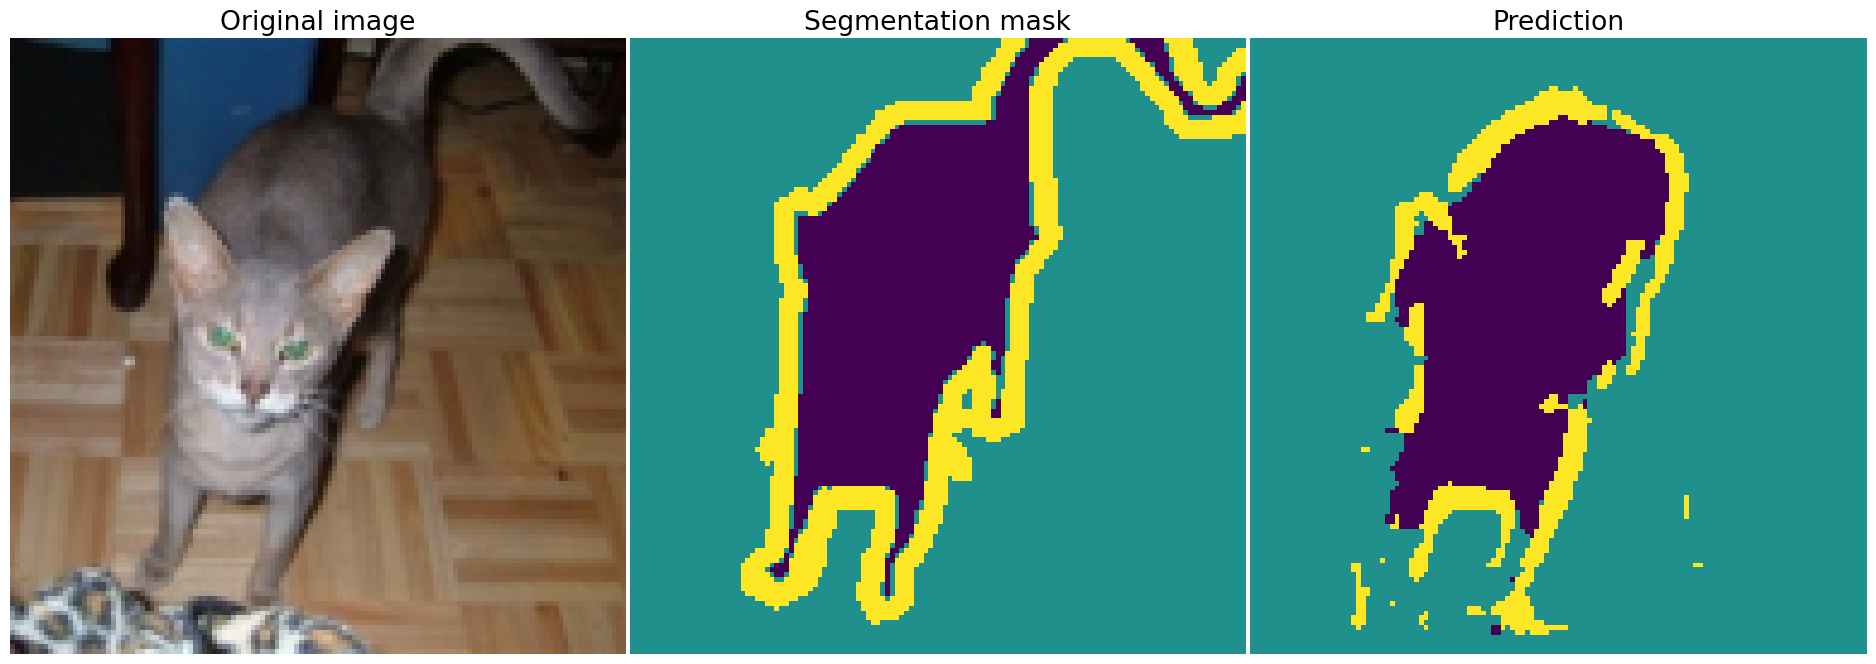

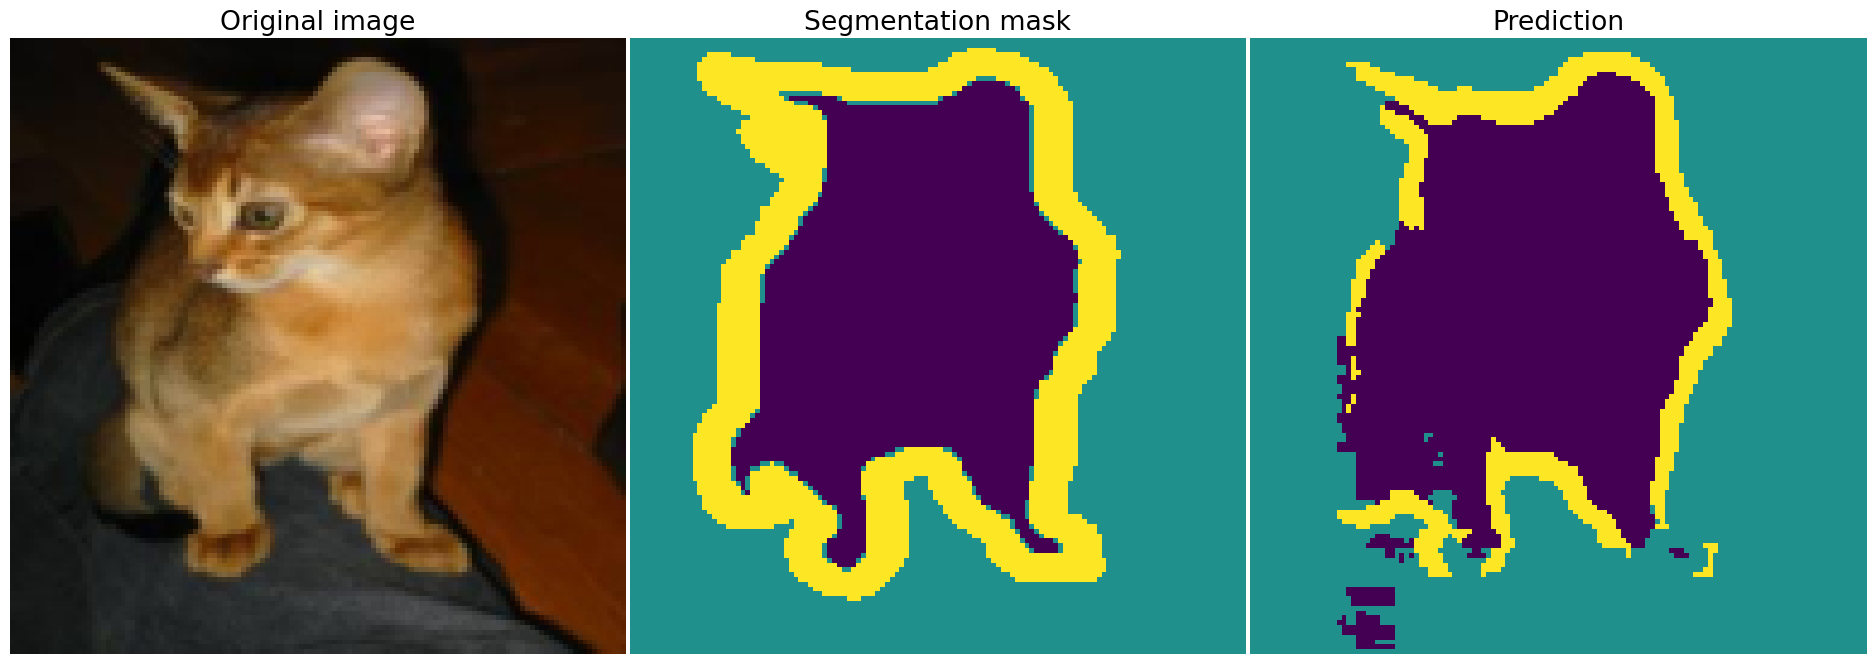

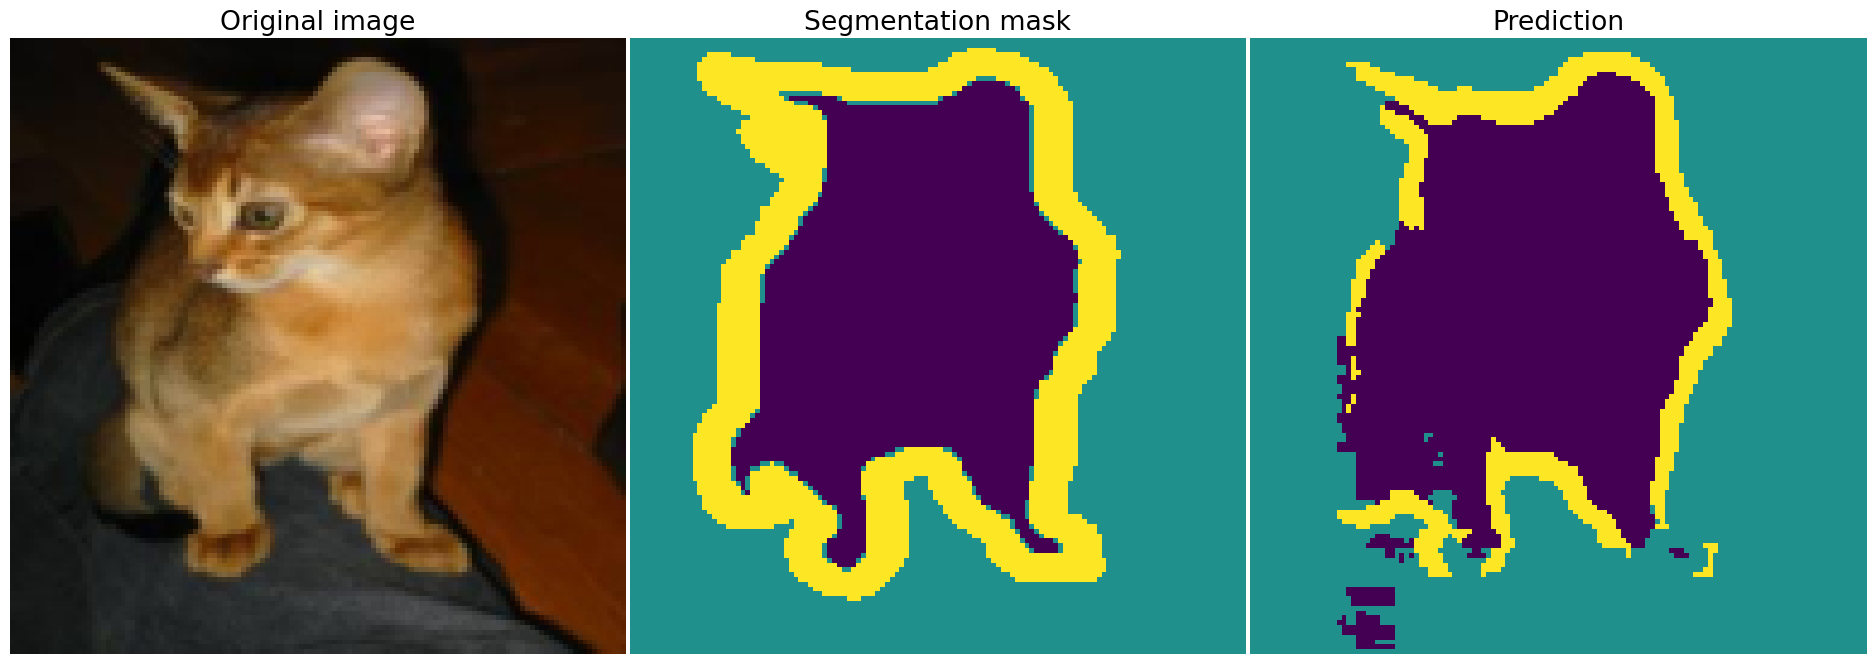

In [ ]:
visualize(model, next(iter(valid_loader)))